# Libraries and Constants


In [ ]:
%%capture
# Importing auxiliar .ipynbs
# Note: they have the libraries in the scrypts, so there is no need of importing them here

# Intructions -------------------------------------------------
# Folder with data and util should be in your drive
from google.colab import drive
drive.mount('/content/drive')

!pip install import_ipynb
import import_ipynb
import seaborn as sns
import random
from tensorflow.keras.utils import to_categorical, plot_model
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers
# !pip install tensorflow_addons
# import tensorflow_addons as tfa


# Changing directory in order to open the notebooks
os.chdir('/content/drive/MyDrive/Colab Notebooks')
import MAFAULDA_Functions

# Useful for FFT and Dynamic time warping
SAMPLES = 250000  # Hertz (number of cycles per second)
DURATION = 5  # Seconds
SAMPLE_RATE = 50000
seed = 1111

# Number of total samples
N = int(SAMPLE_RATE * DURATION)

In [ ]:
##################################################################
# GRAD - CAM (tool to visualize CNN choice)
##################################################################

def grad_cam(layer_name, data):
    grad_model = tf.keras.models.Model(
        [model2_.inputs], [model2_.get_layer(layer_name).output, model2_.output]
    )
    last_conv_layer_output, preds = grad_model(data)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

In [ ]:
###################################################
# Average - Spectrum frequencies
###################################################

def average_spectrum(vector, labels, name, model2_, Binary = True):

  input_size = 5000

  #########################################################
  # Calculating mean of each class spectrum
  #########################################################

  # Class activation map from the input layer to the last Conv. layer
  cnt = 0
  avl_normal, avl_HorMis, avl_Imb, avl_VerMis, avl_Under, avl_Over = [], [], [], [], [], []
  av_normal, av_HorMis, av_Imb, av_VerMis, av_Under, av_Over = [], [], [], [], [], []

  ###########################################################################

  for i in vector:

      data = np.expand_dims(i,0)
      pred = model2_.predict(data)
      real_label = np.argmax(labels[cnt])

      # Creating numpy arrays for different class activation maps
      if real_label == 0:
        if len(avl_normal) != 0:
          av_normal = np.concatenate((av_normal, data))
        else:
          av_normal = data
          avl_normal.append(1) # Filled

      elif real_label == 1:
        if len(avl_HorMis) != 0:
          av_HorMis = np.concatenate((av_HorMis, data))
        else:
          av_HorMis = data
          avl_HorMis.append(1) # Filled

      elif real_label == 2:
        if len(avl_Imb) != 0:
          av_Imb = np.concatenate((av_Imb, data))
        else:
          av_Imb = data
          avl_Imb.append(1) # Filled

      elif real_label == 3:
        if len(avl_VerMis) != 0:
          av_VerMis = np.concatenate((av_VerMis, data))
        else:
          av_VerMis = data
          avl_VerMis.append(1) # Filled

      elif real_label == 4:
        if len(avl_Over) != 0:
          av_Over = np.concatenate((av_Over, data))
        else:
          av_Over = data
          avl_Over.append(1) # Filled

      else:
        if len(avl_Under) != 0:
          av_Under = np.concatenate((av_Under, data))
        else:
          av_Under = data
          avl_Under.append(1) # Filled

      # Adding one to the counter
      cnt +=1

  #################################################################
  # Averaginig ºº
  ################################################################
  scaler = MinMaxScaler()

  if Binary:

    av_normal = scaler.fit_transform(np.average(av_normal, axis = 0))

    av_HorMis = scaler.fit_transform(np.average(av_HorMis, axis = 0))

    av_Imb = scaler.fit_transform(np.average(av_Imb, axis = 0))

    av_VerMis = scaler.fit_transform(np.average(av_VerMis, axis = 0))

    av_Over = scaler.fit_transform(np.average(av_Over, axis = 0))

    av_Under = scaler.fit_transform(np.average(av_Under, axis = 0))

  else:

    av_normal = scaler.fit_transform(np.average(av_normal, axis = 0))

    av_HorMis = scaler.fit_transform(np.average(av_HorMis, axis = 0))

    av_Imb = scaler.fit_transform(np.average(av_Imb, axis = 0))

    av_VerMis = scaler.fit_transform(np.average(av_VerMis, axis = 0))

  # ####################################################################
  # # Plotting average activation map fuctions for each class
  # ####################################################################

  xticks = [int(xf[i]) for i in range(0, input_size, 749)]
  ticks = [i for i in range(0, input_size, 749)]

  if Binary:

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex = True, figsize = (30,30))

    plt.suptitle('Average Spectrum for each class', fontsize = 30)

    ax1.plot(av_normal, 'k')
    ax1.set_title('Class 1 - Normal', fontsize = 25)

    ax2.plot(av_HorMis, 'k')
    ax2.set_title('Class 2 - Horizontal Misalignment', fontsize = 25)

    ax3.plot(av_Imb, 'k')
    ax3.set_title('Class 3 - Imbalance', fontsize = 25)

    ax4.plot(av_VerMis, 'k')
    ax4.set_title('Class 4 - Vertical Misalignment', fontsize = 25)

    ax5.plot(av_Over, 'k')
    ax5.set_title('Class 5 - Overhang', fontsize = 25)

    ax6.plot(av_Under, 'k')
    ax6.set_title('Class 6 - Underhang', fontsize = 25)
    ax6.set_xlim([-50,input_size])
    ax6.set_xticks(ticks)
    ax6.set_xticklabels(xticks)
    ax6.set_xlabel('Frequency (Hz)', fontsize = 15)

    # Saving figure
    path = '/content/drive/MyDrive/Photos_CNN/Average_Spectrum/' + name + '.jpg'
    fig.savefig(path)

  else:

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex = True, figsize = (30,30))

    plt.suptitle('Average Spectrum for Binary Problem', fontsize = 30)
    ax1.plot(av_normal, 'k')
    ax1.set_title('Class 1 - Normal', fontsize = 25)

    ax2.plot(av_HorMis, 'k')
    ax2.set_title('Class 2 - Cage Fault', fontsize = 25)

    ax3.plot(av_Imb, 'k')
    ax3.set_title('Class 3 - Outer Race', fontsize = 25)

    ax4.plot(av_VerMis, 'k')
    ax4.set_title('Class 4 - Ball Fault', fontsize = 25)
    ax4.set_xlim([-50,input_size])
    ax4.set_xticks(ticks)
    ax4.set_xticklabels(xticks)
    ax4.set_xlabel('Frequency (Hz)', fontsize = 15)

    # Saving figure
    path = '/content/drive/MyDrive/Photos_CNN/Average_Spectrum/' + name + '.jpg'
    fig.savefig(path)

In [ ]:
###################################################
# Cleaning plot
###################################################

def cleaning_plot(vector):

  # Obtaining stats from vector
  vector_stats = pd.DataFrame(vector[0]).describe()


  # taking 25% most important frequencies
  # cut_off = vector_stats.iloc[3,0] + (vector_stats.iloc[6,0] - vector_stats.iloc[3,0])
  cut_off = 0.5

  # Making values less than the cut off 0
  index = vector[0] < cut_off
  vector[0][index] = 0

  return vector

####################################################
# Average Heatmap
####################################################


def average_heatmap(vector, labels, name, model2_, Binary = True):

  #########################################################
  # Calculating mean of each class activation map
  #########################################################

  # Class activation map from the input layer to the last Conv. layer
  cnt = 0
  avl_normal, avl_HorMis, avl_Imb, avl_VerMis, avl_Under, avl_Over = [], [], [], [], [], []
  av_normal, av_HorMis, av_Imb, av_VerMis, av_Under, av_Over = [], [], [], [], [], []

  ###########################################################################

  for i in vector:

      data = np.expand_dims(i,0)
      pred = model2_.predict(data)
      real_label = np.argmax(labels[cnt])

      heatmap = grad_cam(layer_name,data)

      # Creating numpy arrays for different class activation maps
      if real_label == 0:
        if len(avl_normal) != 0:
          av_normal = np.concatenate((av_normal, heatmap), axis = 0)
        else:
          av_normal = heatmap
          avl_normal.append(1) # Filled

      elif real_label == 1:
        if len(avl_HorMis) != 0:
          av_HorMis = np.concatenate((av_HorMis, heatmap), axis = 0)
        else:
          av_HorMis = heatmap
          avl_HorMis.append(1) # Filled

      elif real_label == 2:
        if len(avl_Imb) != 0:
          av_Imb = np.concatenate((av_Imb, heatmap), axis = 0)
        else:
          av_Imb = heatmap
          avl_Imb.append(1) # Filled

      elif real_label == 3:
        if len(avl_VerMis) != 0:
          av_VerMis = np.concatenate((av_VerMis, heatmap), axis = 0)
        else:
          av_VerMis = heatmap
          avl_VerMis.append(1) # Filled

      elif real_label == 4:
        if len(avl_Over) != 0:
          av_Over = np.concatenate((av_Over, heatmap), axis = 0)
        else:
          av_Over = heatmap
          avl_Over.append(1) # Filled

      else:
        if len(avl_Under) != 0:
          av_Under = np.concatenate((av_Under, heatmap), axis = 0)
        else:
          av_Under = heatmap
          avl_Under.append(1) # Filled

      # Adding one to the counter
      cnt +=1

  #################################################################
  # Averaginig now and cleaning plot
  ################################################################
  scaler = StandardScaler()

  if Binary:
    av_normal = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_normal, axis=0),0).reshape(-1,1)),1,0))

    av_HorMis = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_HorMis, axis=0),0).reshape(-1,1)),1,0))

    av_Imb = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_Imb, axis=0),0).reshape(-1,1)),1,0))

    av_VerMis = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_VerMis, axis=0),0).reshape(-1,1)),1,0))

    av_Over = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_Over, axis=0),0).reshape(-1,1)),1,0))

    av_Under = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_Under, axis=0),0).reshape(-1,1)),1,0))

  else:

    av_normal = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_normal, axis=0),0).reshape(-1,1)),1,0))

    av_HorMis = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_HorMis, axis=0),0).reshape(-1,1)),1,0))

    av_Imb = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_Imb, axis=0),0).reshape(-1,1)),1,0))

    av_VerMis = cleaning_plot(np.moveaxis(scaler.fit_transform(np.expand_dims(np.average(av_VerMis, axis=0),0).reshape(-1,1)),1,0))


  ####################################################################
  # Plotting average activation map fuctions for each class
  ####################################################################

  input_size = 5000
  xticks = [int(xf[i]) for i in range(0, input_size, 749)]
  ticks = [i for i in range(0, input_size, 749)]

  if Binary:

    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex = True, figsize = (30,30))

    plt.suptitle('Average Class Activation Map', fontsize = 30)

    ax1.imshow(av_normal, cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax1.set_title('Class 1 - Normal', fontsize = 25)

    ax2.imshow(av_HorMis,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax2.set_title('Class 2 - Horizontal Misalignment', fontsize = 25)

    ax3.imshow(av_Imb,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax3.set_title('Class 3 - Imbalance', fontsize = 25)

    ax4.imshow(av_VerMis,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax4.set_title('Class 4 - Vertical Misalignment', fontsize = 25)

    ax5.imshow(av_Over,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax5.set_title('Class 5 - Overhang', fontsize = 25)

    ax6.imshow(av_Under,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax6.set_title('Class 6 - Underhang', fontsize = 25)
    ax6.set_xlim([0,input_size])
    ax6.set_xticks(ticks = ticks)
    ax6.set_xticklabels(xticks)
    ax6.set_xlabel('Frequenxy (Hz)', fontsize = 15)

    # Saving figure
    path = '/content/drive/MyDrive/Photos_CNN/Average/' + name + '.jpg'
    fig.savefig(path)

  else:

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex = True, figsize = (30,30))

    plt.suptitle('Average Class Activation Map', fontsize = 30)

    ax1.imshow(av_normal, cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax1.set_title('Class 1 - Normal', fontsize = 25)

    ax2.imshow(av_HorMis,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax2.set_title('Class 2 - Cage Fault', fontsize = 25)

    ax3.imshow(av_Imb,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax3.set_title('Class 3 - Outer Race', fontsize = 25)

    ax4.imshow(av_VerMis,cmap='Reds', aspect="auto", interpolation='nearest',extent=[0,input_size,i.min(),i.max()], alpha=1)
    ax4.set_title('Class 4 - Vertical Ball Fault', fontsize = 25)
    ax4.set_xlim([0,input_size])
    ax4.set_xticks(ticks = ticks)
    ax4.set_xticklabels(xticks)
    ax4.set_xlabel('Frequenxy (Hz)', fontsize = 15)

    # Saving figure
    path = '/content/drive/MyDrive/Photos_CNN/Average/' + name + '.jpg'
    fig.savefig(path)

In [ ]:
###########################################################################
# Saving all images from test set in each particular class
###########################################################################
directories = ['/content/drive/MyDrive/Photos_CNN/Normal',
               '/content/drive/MyDrive/Photos_CNN/HorMis',
               '/content/drive/MyDrive/Photos_CNN/Imbalance',
               '/content/drive/MyDrive/Photos_CNN/VerMis',
               '/content/drive/MyDrive/Photos_CNN/Overhang',
               '/content/drive/MyDrive/Photos_CNN/Underhang',
               '/content/drive/MyDrive/Photos_CNN/Incorrect']

def image_allocation(pred, fig, stacked = True):

  if stacked:
    if pred == 0:
      fig.savefig(directories[0]+ '/' + str(cnt)+'_PlotStacked.png')
    elif pred == 1:
      fig.savefig(directories[1]+ '/' + str(cnt)+'_PlotStacked.png')
    elif pred == 2:
      fig.savefig(directories[2]+ '/' + str(cnt)+'_PlotStacked.png')
    elif pred == 3:
      fig.savefig(directories[3]+ '/' + str(cnt)+'_PlotStacked.png')
    elif pred == 4:
      fig.savefig(directories[4]+ '/' + str(cnt)+'_PlotStacked.png')
    else:
      fig.savefig(directories[5]+ '/' + str(cnt)+'_PlotStacked.png')

    plt.close()

  else:
    if pred == 0:
      fig.savefig(directories[0]+ '/' + str(cnt)+'_Plot6Accelerometer.png')
    elif pred == 1:
      fig.savefig(directories[1]+ '/' + str(cnt)+'_Plot6Accelerometer.png')
    elif pred == 2:
      fig.savefig(directories[2]+ '/' + str(cnt)+'_Plot6Accelerometer.png')
    elif pred == 3:
      fig.savefig(directories[3]+ '/' + str(cnt)+'_Plot6Accelerometer.png')
    elif pred == 4:
      fig.savefig(directories[4]+ '/' + str(cnt)+'_Plot6Accelerometer.png')
    else:
      fig.savefig(directories[5]+ '/' + str(cnt)+'_Plot6Accelerometer.png')

    plt.close()

# Loading MAFAULDA dataset after FFT

## Normal

In [ ]:
datasets, time = MAFAULDA_Functions.LoadNormal()

input_size = 5000

scaler = MinMaxScaler()

### Fast Fourier Trasformation - FFT

#### Acceleremoter - Underhang

In [ ]:
BandPass = 7509

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(49):
  xf, yf, new_sig = MAFAULDA_Functions.UnderAxialFFT(datasets, time, index = i, BandPass = BandPass)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(49):
  xf, yf, new_sig = MAFAULDA_Functions.UnderRadialFFT(datasets, time, index = i, BandPass = BandPass)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(49):
  xf, yf, new_sig = MAFAULDA_Functions.UnderTangencialFFT(datasets, time, index = i, BandPass = BandPass)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions 3x49

new_sig_underhang = np.array([new_sig_axial,
                     new_sig_radiale,
                     new_sig_tangencial])

print('The shape of the resulting matrix is:', new_sig_underhang.shape)

The shape of the resulting matrix is: (3, 49, 5000, 1)


#### Acceleremoter - Overhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(49):
  xf, yf, new_sig = MAFAULDA_Functions.OverAxialFFT(datasets, time, index = i, BandPass = BandPass)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(49):
  xf, yf, new_sig = MAFAULDA_Functions.OverRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(49):
  xf, yf, new_sig = MAFAULDA_Functions.OverTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_signal = np.concatenate((new_sig_underhang,
                                         np.array([new_sig_axial,
                                                    new_sig_radiale,
                                                    new_sig_tangencial])))

new_signal.shape

(6, 49, 5000, 1)

## Horizontal Misalignment

In [ ]:
datasets, time = MAFAULDA_Functions.LoadHorMis()

### Fast Fourier Trasformation - FFT

#### Acceleremoter - Underhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(197):
  xf, yf, new_sig = MAFAULDA_Functions.UnderAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(197):
  xf, yf, new_sig = MAFAULDA_Functions.UnderRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(197):
  xf, yf, new_sig = MAFAULDA_Functions.UnderTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.array([new_sig_axial,
                     new_sig_radiale,
                     new_sig_tangencial])

#### Acceleremoter - Overhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(197):
  xf, yf, new_sig = MAFAULDA_Functions.OverAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(197):
  xf, yf, new_sig = MAFAULDA_Functions.OverRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(197):
  xf, yf, new_sig = MAFAULDA_Functions.OverTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.concatenate((new_sig_underhang,
                                         np.array([new_sig_axial,
                                                    new_sig_radiale,
                                                    new_sig_tangencial])))

new_sig_underhang.shape

(6, 197, 5000, 1)

In [ ]:
new_signal = np.concatenate((new_signal, new_sig_underhang), axis = 1)

new_signal.shape

(6, 246, 5000, 1)

## Imbalance

In [ ]:
datasets, time = MAFAULDA_Functions.LoadImbalance()

### Fast Fourier Trasformation - FFT

#### Acceleremoter - Underhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(333):
  xf, yf, new_sig = MAFAULDA_Functions.UnderAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(333):
  xf, yf, new_sig = MAFAULDA_Functions.UnderRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(333):
  xf, yf, new_sig = MAFAULDA_Functions.UnderTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.array([new_sig_axial,
                     new_sig_radiale,
                     new_sig_tangencial])

#### Acceleremoter - Overhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(333):
  xf, yf, new_sig = MAFAULDA_Functions.OverAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(333):
  xf, yf, new_sig = MAFAULDA_Functions.OverRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(333):
  xf, yf, new_sig = MAFAULDA_Functions.OverTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.concatenate((new_sig_underhang,
                                         np.array([new_sig_axial,
                                                    new_sig_radiale,
                                                    new_sig_tangencial])))

new_sig_underhang.shape

(6, 333, 5000, 1)

In [ ]:
new_signal = np.concatenate((new_signal, new_sig_underhang), axis = 1)

new_signal.shape

(6, 579, 5000, 1)

## Vertical Misalignment

In [ ]:
datasets, time = MAFAULDA_Functions.LoadVerMis()

### Fast Fourier Trasformation - FFT

#### Acceleremoter - Underhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(301):
  xf, yf, new_sig = MAFAULDA_Functions.UnderAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(301):
  xf, yf, new_sig = MAFAULDA_Functions.UnderRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(301):
  xf, yf, new_sig = MAFAULDA_Functions.UnderTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.array([new_sig_axial,
                     new_sig_radiale,
                     new_sig_tangencial])

#### Acceleremoter - Overhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(301):
  xf, yf, new_sig = MAFAULDA_Functions.OverAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(301):
  xf, yf, new_sig = MAFAULDA_Functions.OverRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(301):
  xf, yf, new_sig = MAFAULDA_Functions.OverTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.concatenate((new_sig_underhang,
                                         np.array([new_sig_axial,
                                                    new_sig_radiale,
                                                    new_sig_tangencial])))

new_sig_underhang.shape

(6, 301, 5000, 1)

In [ ]:
new_signal = np.concatenate((new_signal, new_sig_underhang), axis = 1)

new_signal.shape

(6, 880, 5000, 1)

## Overhang

In [ ]:
datasets, time = MAFAULDA_Functions.LoadOverhang()

### Fast Fourier Trasformation - FFT

#### Acceleremoter - Underhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(513):
  xf, yf, new_sig = MAFAULDA_Functions.UnderAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(513):
  xf, yf, new_sig = MAFAULDA_Functions.UnderRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(513):
  xf, yf, new_sig = MAFAULDA_Functions.UnderTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.array([new_sig_axial,
                     new_sig_radiale,
                     new_sig_tangencial])

#### Acceleremoter - Overhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(513):
  xf, yf, new_sig = MAFAULDA_Functions.OverAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(513):
  xf, yf, new_sig = MAFAULDA_Functions.OverRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(513):
  xf, yf, new_sig = MAFAULDA_Functions.OverTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.concatenate((new_sig_underhang,
                                         np.array([new_sig_axial,
                                                    new_sig_radiale,
                                                    new_sig_tangencial])))

new_sig_underhang.shape

(6, 513, 5000, 1)

In [ ]:
new_signal = np.concatenate((new_signal, new_sig_underhang), axis = 1)

new_signal.shape

(6, 1393, 5000, 1)

In [ ]:
del new_sig_underhang
del datasets, time



## Underhang

In [ ]:
datasets, time = MAFAULDA_Functions.LoadUnderhang()

### Fast Fourier Trasformation - FFT

#### Acceleremoter - Underhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(558):
  xf, yf, new_sig = MAFAULDA_Functions.UnderAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(558):
  xf, yf, new_sig = MAFAULDA_Functions.UnderRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(558):
  xf, yf, new_sig = MAFAULDA_Functions.UnderTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.array([new_sig_axial,
                     new_sig_radiale,
                     new_sig_tangencial])

#### Acceleremoter - Overhang

In [ ]:
###############################################################
# Axial
###############################################################

new_sig_axial = []

for i in range(558):
  xf, yf, new_sig = MAFAULDA_Functions.OverAxialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_axial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Radiale
###############################################################

new_sig_radiale = []

for i in range(558):
  xf, yf, new_sig = MAFAULDA_Functions.OverRadialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_radiale.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
###############################################################
# Tangencial
###############################################################

new_sig_tangencial = []

for i in range(558):
  xf, yf, new_sig = MAFAULDA_Functions.OverTangencialFFT(datasets, time, index = i, BandPass = 5)
  new_sig_tangencial.append(scaler.fit_transform(np.abs(yf[0:input_size]).reshape(-1,1)))

In [ ]:
# Joining all FFT from axial, radial and tangecial into a matrix of dimensions

new_sig_underhang = np.concatenate((new_sig_underhang,
                                         np.array([new_sig_axial,
                                                    new_sig_radiale,
                                                    new_sig_tangencial])))

new_sig_underhang.shape

(6, 558, 5000, 1)

In [ ]:
new_signal = np.concatenate((new_signal, new_sig_underhang), axis = 1)

new_signal.shape

(6, 1951, 5000, 1)

In [ ]:
del new_sig_underhang
del datasets, time

# Experiments

In [ ]:
##############################
# Creating labels
##############################

underhang_y = []

# Normal
for i in range(49):
  underhang_y.append(0)

# Hor Mis
for i in range(197):
  underhang_y.append(1)

# Imbalance
for i in range(333):
  underhang_y.append(2)

# Ver Mis
for i in range(301):
  underhang_y.append(3)

# Overhang
for i in range(513):
  underhang_y.append(4)

# Underhang
for i in range(558):
  underhang_y.append(5)

underhang_y = np.array(underhang_y)

In [ ]:
##########################################################
# Splitting and shuffling the data
##########################################################

new_signal2 = new_signal.reshape(6, 1951, input_size)

# Splitting it 65% - 35% (train-test)
all_indices = list(range(len(new_signal[0])))
# , stratify = underhang_y
train_ind, test_ind = train_test_split(all_indices,stratify = underhang_y, test_size=0.2, shuffle = True,
                                       random_state = 420)

X_train = np.moveaxis(new_signal2[:,train_ind,:], 0, -1)
X_test = np.moveaxis(new_signal2[:,test_ind, :], 0, -1)
# One-hot encoding
y_train = to_categorical(underhang_y[train_ind])
y_test = to_categorical(underhang_y[test_ind])

print("""
########################################
# Underhang Accelerometer
########################################
""")
print('Underhang - Training size:', X_train.shape)
print('Underhang - Test size:', X_test.shape)
print('Underhang_y - Training size:', y_train.shape)
print('Underhang_y - Test size:', y_test.shape)



########################################
# Underhang Accelerometer
########################################

Underhang - Training size: (1560, 5000, 6)
Underhang - Test size: (391, 5000, 6)
Underhang_y - Training size: (1560, 6)
Underhang_y - Test size: (391, 6)


## CNN

In [ ]:
# Obtaining the same model as described in the paper

##################################################
# GOOD
##################################################


num_errors = 6
input_shape = (input_size ,6)
kernel_size = 9
pool_size = 2
dropout = 0.1

model2_ =  Sequential([
                    Conv1D(filters=16,
                                    kernel_size=13,
                                    activation='relu',
                                    input_shape=input_shape,
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    BatchNormalization(),

                    Dropout(dropout),

                    Conv1D(filters=32,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    BatchNormalization(),

                    Conv1D(filters=128,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    # dropout added as regularizer
                    Dropout(dropout),

                    Conv1D(filters=32,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    Conv1D(filters=16,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),


                    Flatten(),

                    Dense(num_errors),
                    Activation('softmax')

  ])
model2_.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 5000, 16)          1264      
                                                                 
 batch_normalization_21 (Bat  (None, 5000, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 5000, 16)          0         
                                                                 
 conv1d_29 (Conv1D)          (None, 5000, 32)          6688      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 2500, 32)         0         
 g1D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 2500, 32)        

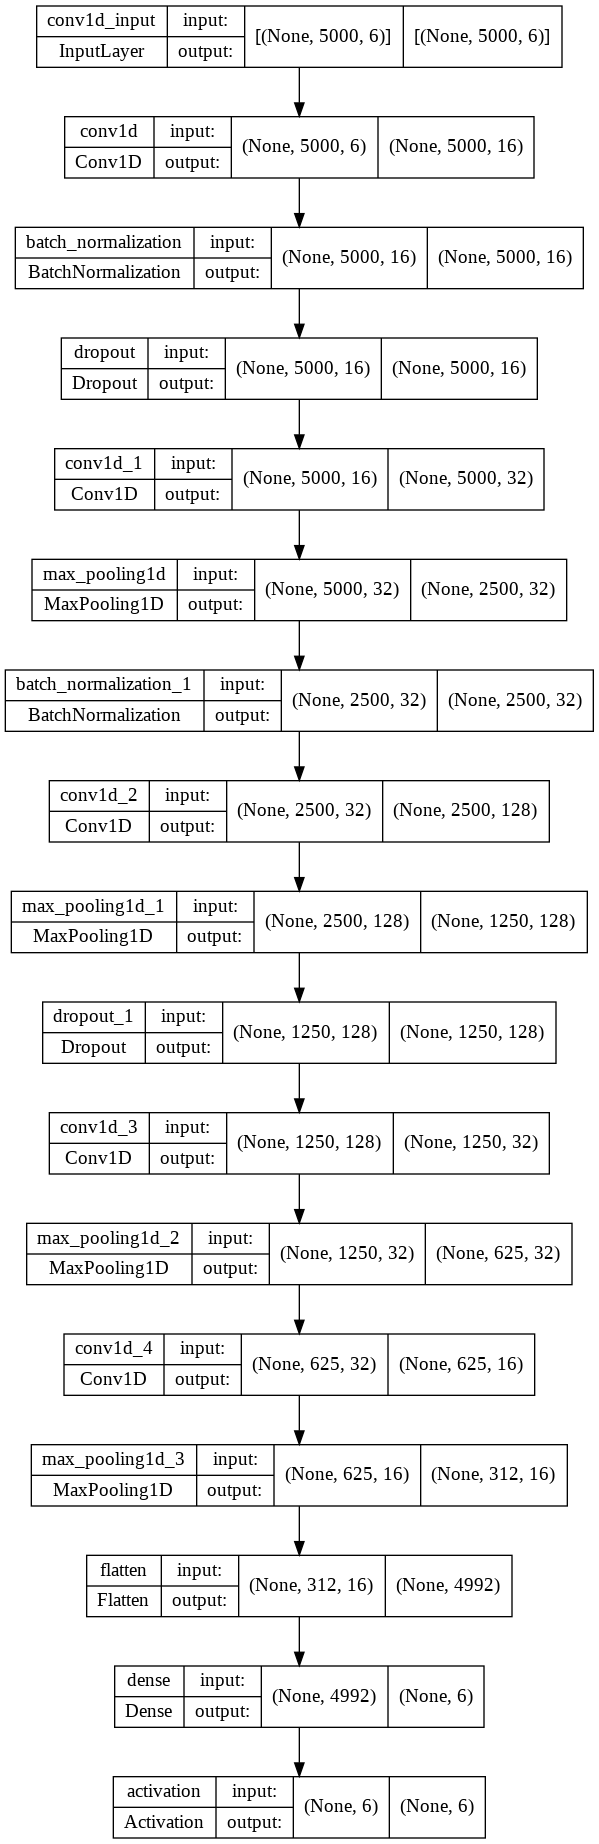

In [ ]:
plot_model(model2_, show_shapes=True)

In [ ]:
########################################
# Training the model now (Underhang)
########################################
import tensorflow as tf

checkpoint_filepath = '/content/drive/MyDrive/best_model.hdf5'
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)

opt = tf.keras.optimizers.Adam(
    learning_rate= 0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
  )

model2_.compile(loss='CategoricalCrossentropy',
              optimizer= opt,
              metrics=['accuracy'])

# train the network
output = model2_.fit(X_train, y_train, epochs = 100, batch_size=8,
                    validation_data = (X_test , y_test),
                    callbacks = [save_best_model])

Epoch 1/100
193/195 [============================>.] - ETA: 0s - loss: 1.7517 - accuracy: 0.5440
Epoch 1: val_accuracy improved from -inf to 0.28645, saving model to /content/drive/MyDrive/best_model.hdf5
195/195 [==============================] - 5s 18ms/step - loss: 1.7460 - accuracy: 0.5455 - val_loss: 1.6976 - val_accuracy: 0.2864
Epoch 2/100
194/195 [============================>.] - ETA: 0s - loss: 0.8628 - accuracy: 0.8982
Epoch 2: val_accuracy improved from 0.28645 to 0.36061, saving model to /content/drive/MyDrive/best_model.hdf5
195/195 [==============================] - 3s 15ms/step - loss: 0.8621 - accuracy: 0.8981 - val_loss: 2.0786 - val_accuracy: 0.3606
Epoch 3/100
193/195 [============================>.] - ETA: 0s - loss: 0.6222 - accuracy: 0.9560
Epoch 3: val_accuracy improved from 0.36061 to 0.88747, saving model to /content/drive/MyDrive/best_model.hdf5
195/195 [==============================] - 3s 15ms/step - loss: 0.6212 - accuracy: 0.9558 - val_loss: 0.8007 - val_

In [ ]:
# ######################################################
# # Setting the weights for the best model found and saving the model
# model2_.load_weights(checkpoint_filepath)
# # Guardar el Modelo (Just only once if u are running the network again)
# model2_.save('/content/drive/MyDrive/Model_CNN.h5')

######################################################################
# Loading model (already trained)
model2_ = keras.models.load_model('/content/drive/MyDrive/Model_CNN.h5')
#####################################################################

In [ ]:
# Minimum value of cross entropy

print("The minimum loss training found is:", round(min(output.history['loss']),6) ," and was found in epoch number:", np.argmin(output.history['loss']))
print("The minimum loss test found is:", round(min(output.history['val_loss']),6) ," and was found in epoch number:", np.argmin(output.history['val_loss']))

# Maximum accuracy

print("The maximum accuracy training found is:", round(100*max(output.history['accuracy']),2) ,"% and was found in epoch number:", np.argmax(output.history['accuracy']))
print("The maximum accuracy test found is:", round(100*max(output.history['val_accuracy']),2) ,"% and was found in epoch number:", np.argmax(output.history['val_accuracy']))

The minimum loss training found is: 0.017246  and was found in epoch number: 99
The minimum loss test found is: 0.024432  and was found in epoch number: 99
The maximum accuracy training found is: 100.0 % and was found in epoch number: 22
The maximum accuracy test found is: 99.74 % and was found in epoch number: 17


(0.0, 0.4)

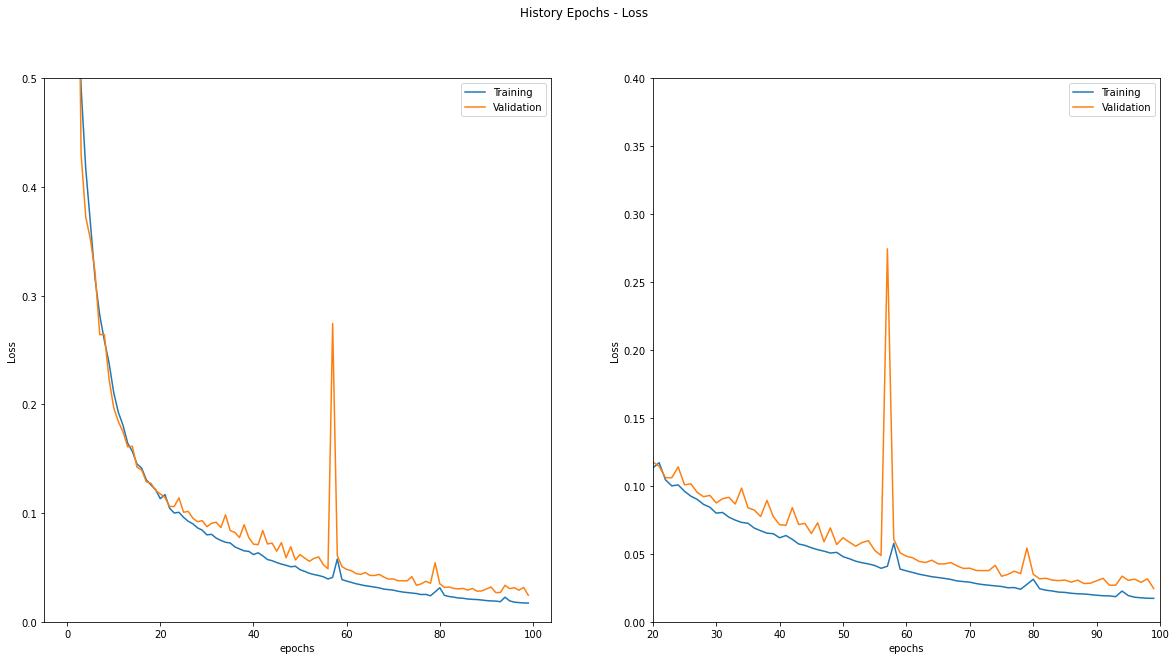

In [ ]:
# Plotting loss and val_loss vs epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
fig.suptitle('History Epochs - Loss')

ax1.plot(range(100),output.history['loss'],output.history['val_loss'])
ax1.set(ylabel= "Loss", xlabel = "epochs")
ax1.legend(["Training", "Validation"],loc = "best")
ax1.set_ylim([0, 0.5])

ax2.plot(range(100),output.history['loss'],output.history['val_loss'])
ax2.set(ylabel= "Loss", xlabel = "epochs")
ax2.legend(["Training", "Validation"],loc = "best")
ax2.set_xlim([20,100])
ax2.set_ylim([0, 0.4])

(0.94, 1.02)

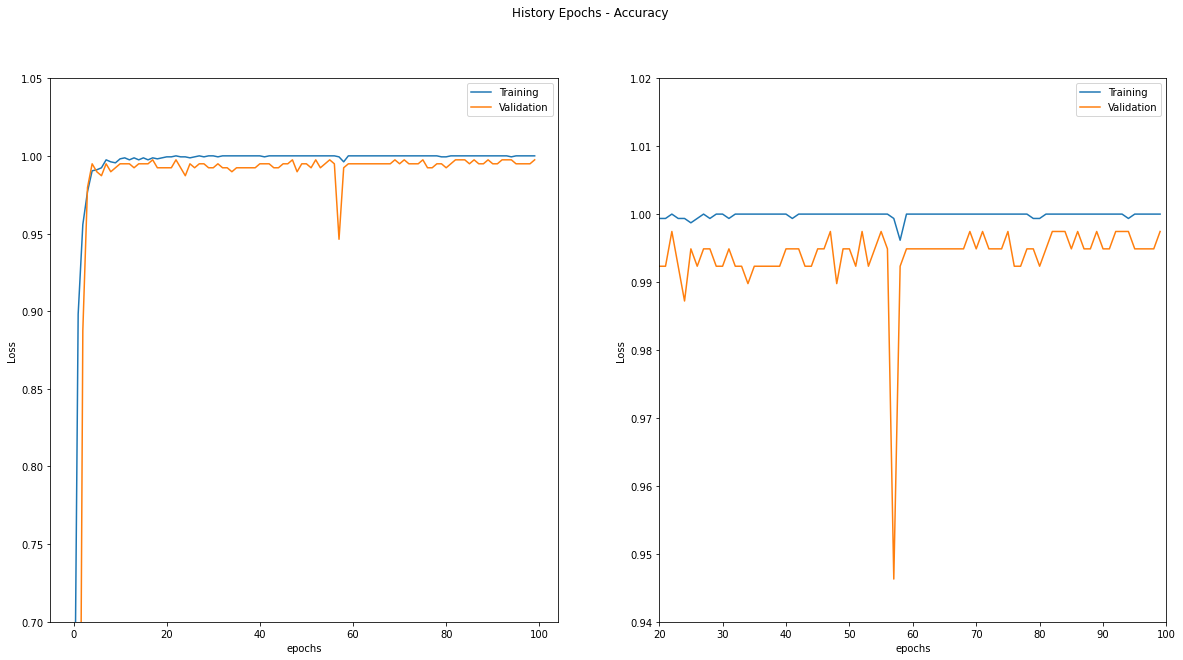

In [ ]:
# Plotting accuracy and val_accuracy vs epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
fig.suptitle('History Epochs - Accuracy')

ax1.plot(range(100),output.history['accuracy'],output.history['val_accuracy'])
ax1.set(ylabel= "Loss", xlabel = "epochs")
ax1.legend(["Training", "Validation"],loc = "best")
ax1.set_ylim([0.7, 1.05])

ax2.plot(range(100),output.history['accuracy'],output.history['val_accuracy'])
ax2.set(ylabel= "Loss", xlabel = "epochs")
ax2.legend(["Training", "Validation"],loc = "best")
ax2.set_xlim([20,100])
ax2.set_ylim([0.94, 1.02])

In [ ]:
_, acc = model2_.evaluate(X_test,
                        y_test,
                        batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

_, acc = model2_.evaluate(X_train,
                        y_train,
                        batch_size=32)
print("\Train accuracy: %.1f%%" % (100.0 * acc))

13/13 [==============================] - 1s 12ms/step - loss: 0.1288 - accuracy: 0.9974

Test accuracy: 99.7%
49/49 [==============================] - 1s 10ms/step - loss: 0.1189 - accuracy: 0.9994
\Train accuracy: 99.9%


[Text(0, 0.5, 'Normal'),
 Text(0, 1.5, 'Hor Mis'),
 Text(0, 2.5, 'Imbalance'),
 Text(0, 3.5, 'Ver Mis'),
 Text(0, 4.5, 'Overhang'),
 Text(0, 5.5, 'Underhang')]

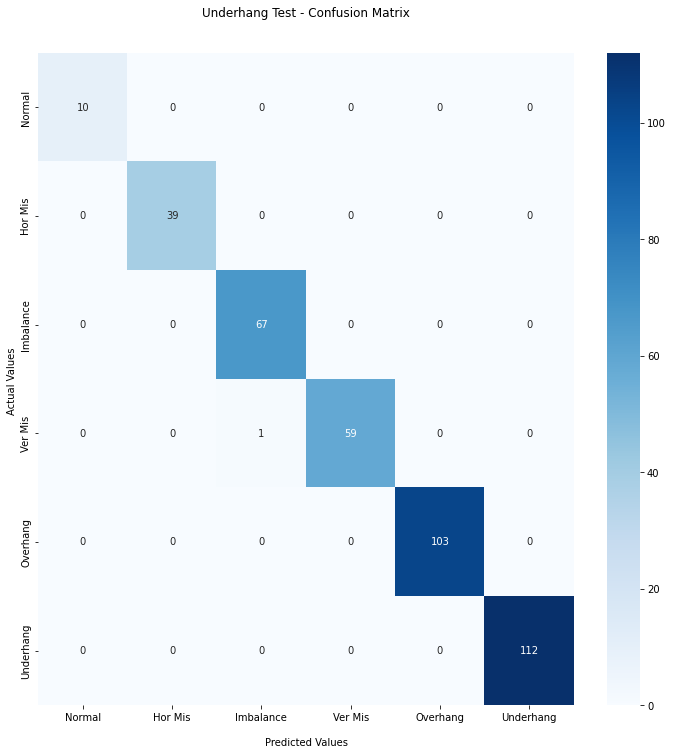

In [ ]:
# COnfusion matrix resulting

y_pred = model2_.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
underhang_y_test_cm = np.argmax(y_test, axis = -1)
matrix = confusion_matrix(underhang_y_test_cm, y_pred)

figure = plt.figure(figsize = (12,12))

ax = sns.heatmap(matrix, annot=True, cmap='Blues',fmt = 'g')

ax.set_title('Underhang Test - Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])
ax.yaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])

In [ ]:
# Accuracy per class
names = ['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang']

for i in range(6):
  ac =0
  tot = 0
  for j in range(6):
    if i == j:
      ac += matrix[i][j]
      tot += matrix[i][j]
    else:
      tot += matrix[i][j]

  print("The accuracy for class", names[i], 'is:', round(100*ac/tot, 2), '% = ', ac, '/', tot)

The accuracy for class Normal is: 100.0 % =  10 / 10
The accuracy for class Hor Mis is: 100.0 % =  39 / 39
The accuracy for class Imbalance is: 100.0 % =  67 / 67
The accuracy for class Ver Mis is: 98.33 % =  59 / 60
The accuracy for class Overhang is: 100.0 % =  103 / 103
The accuracy for class Underhang is: 100.0 % =  112 / 112


### Explainability using Grad - CAM techniques

In [ ]:
# Needed for visualization

layer_name = "conv1d_24"  # last layer
cnt = 0
xticks = [int(xf[i]) for i in range(0, input_size, 749)]
ticks = [i for i in range(0, input_size, 749)]

In [ ]:
###########################################################################
# Independent heatmaps for each data point
###########################################################################

cnt_2 = 0

for i in X_test:
    data = np.expand_dims(i,0)
    pred = model2_.predict(data)
    # Printing a class in particular
    actual_class = np.argmax(y_test[cnt_2])


    if np.argmax(pred) != actual_class:

      heatmap = grad_cam(layer_name,data)

      fig1, (ax1) = plt.subplots(1, sharex = True, figsize = (30,10))

      ###########################################################################
      # AX1 - CNN selection with stacked data
      ###########################################################################

      ax1.imshow(heatmap, cmap='Reds', aspect="auto" ,extent=[0,5000,i.min(),i.max()], alpha=0.8)
      ax1.plot(i,'k')
      ax1.set_ylabel('Normalised Amplitud frequency')
      ax1.set_title('HeatMap for Incorrect data point')

      # Plotting 7 plots:
      # - Stacking on all 6 frequencies
      # - Axial/Radial/Tangencial Underhang Accelerometer
      # - Axial/Radial/Tangencial Overhang Accelerometer

      ###########################################################################
      # AX2 - Stacked data with colors
      ###########################################################################


      # df = pd.DataFrame(i)

      # ax2.plot(df.iloc[:,0], label = 'AxialUn')
      # ax2.plot(df.iloc[:,1], label = 'RadialUn')
      # ax2.plot(df.iloc[:,2], label = 'TangUn')
      # ax2.plot(df.iloc[:,3], label = 'AxialOv')
      # ax2.plot(df.iloc[:,4], label = 'RadialOv')
      # ax2.plot(df.iloc[:,5], label = 'TangOv')
      # ax2.set_title('Stacked data with colors')
      # ax2.set_xlabel('Frequency (Hz)')
      # ax2.set_xticks(ticks = ticks)
      # ax2.set_xticklabels(xticks)
      # ax2.set_ylabel('Normalised Amplitud frequency')
      # ax2.legend()


      fig1.savefig(directories[6] + '/' + str(cnt)+'_PlotStacked.png')
      plt.close()

      # Saving photos
      ###########################################<################
      # if names[np.argmax(pred)] != names[np.argmax(y_test[cnt])]:
      #   fig1.savefig(directories[6] + '/' + str(cnt)+'_PlotStacked.png')
      #   plt.close()
      # else:
      #   image_allocation(np.argmax(pred), fig1)
      ##############################################################


      ###########################################################################
      # AX1 - 6 remaining graphs regarding accelerometer
      ###########################################################################

      # fig2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex = True, figsize = (30,30))

      # ax1.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax1.plot(df.iloc[:,0], 'k', label = 'AxialUn')
      # ax1.set_title('Axial - Underhang Accelerometer')
      # ax1.set_ylabel('Normalised Amplitud frequency')

      # ax2.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax2.plot(df.iloc[:,1], 'k', label = 'RadialUn')
      # ax2.set_title('Radiale - Underhang Accelerometer')
      # ax2.set_ylabel('Normalised Amplitud frequency')

      # ax3.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax3.plot(df.iloc[:,2], 'k', label = 'TangUn')
      # ax3.set_title('Tangencial - Underhang Accelerometer')
      # ax3.set_ylabel('Normalised Amplitud frequency')

      # ax4.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax4.plot(df.iloc[:,3], 'k', label = 'AxialOv')
      # ax4.set_title('Axial - Overhang Accelerometer')
      # ax4.set_ylabel('Normalised Amplitud frequency')

      # ax5.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax5.plot(df.iloc[:,4], 'k', label = 'RadialOv')
      # ax5.set_title('Radiale - Underhang Accelerometer')
      # ax5.set_ylabel('Normalised Amplitud frequency')

      # ax6.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax6.plot(df.iloc[:,5], 'k', label = 'TangOv')
      # ax6.set_title('Tangecial - Underhang Accelerometer')
      # ax6.set_xlabel('Frequency (Hz)')
      # ax6.set_xlim([0,7509])
      # ax6.set_ylabel('Normalised Amplitud frequency')
      # ax6.set_xticks(ticks = ticks)
      # ax6.set_xticklabels(xticks)

      # # Saving photos
      # ###########################################<################
      # if names[np.argmax(pred)] != names[np.argmax(y_test[cnt])]:
      #   fig2.savefig(directories[6]+ '/' +str(cnt)+'_Plot6Accelerometer.png')
      #   plt.close()
      # else:
      #   image_allocation(np.argmax(pred), fig2, stacked = False)
      # ##############################################################

    cnt_2 += 1



334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


390


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


In [ ]:
%%capture
################################################################
# Training + Test
################################################################

X = np.moveaxis(new_signal2, 0, -1)
y = to_categorical(underhang_y)
average_spectrum(X, y, 'Tran_Test', model2_ = model2_)
average_heatmap(X, y, 'Train_Test', model2_ = model2_)

In [ ]:
%%capture

################################################################
# Training
################################################################

average_heatmap(X_train, y_train, 'Train', model2_ = model2_)
average_spectrum(X_train, y_train, 'Train', model2_ = model2_)

################################################################
# Test
################################################################

average_heatmap(X_test, y_test, 'Test', model2_ = model2_)
average_spectrum(X_test, y_test, 'Test', model2_ = model2_)

## Hyperparametrizing CNN using Talos

In [ ]:
%%capture
!pip install talos
!pip install wrangle
import talos
import wrangle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# set the parameter space boundary
p = {'activation':['relu'],
     'optimizer': ['Adam'],
     'kernel_size_1':[7, 9, 11, 13],
     'kernel_size_2':[7, 9, 11, 13],
     'kernel_size_3':[7, 9, 11, 13],
     'learning_rate' : [1e-03, 1e-02, 1e-04, 1e-05],
     'pool_size' : [2,3,4],
     'padding': ['same'],
     'strides': [1],
     'filters_1': [16, 32, 64, 128],
     'filters_2': [16, 32, 64, 128],
     'filters_3': [16, 32, 64, 128],
     'dropout': [.01, 0.1, 0.05],
     'batch_size': [8]}

In [ ]:
# Saving best model - call back
# Note: it should be outside the function to make it globally for all the models

checkpoint_filepath = '/content/drive/MyDrive/hyper_CNN.hdf5'
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)

In [ ]:
# Obtaining the same model as described in the paper

def model_CNN(X_train, y_train, X_test, y_test, params):

  num_errors = 6
  input_shape = (input_size,6)

  model2_ =  Sequential([
                      Conv1D(filters=params['filters_1'],
                                      kernel_size=params['kernel_size_1'],
                                      activation= params['activation'],
                                      input_shape=input_shape,
                                      padding = params['padding'],
                                      strides = params['strides'],
                                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=regularizers.L2(1e-4),
                                      activity_regularizer=regularizers.L2(1e-5)),

                      BatchNormalization(),

                      Dropout(params['dropout']),

                      Conv1D(filters=params['filters_2'],
                                      kernel_size=params['kernel_size_2'],
                                      activation= params['activation'],
                                      input_shape=input_shape,
                                      padding = params['padding'],
                                      strides = params['strides'],
                                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=regularizers.L2(1e-4),
                                      activity_regularizer=regularizers.L2(1e-5)),

                      MaxPooling1D(params['pool_size']),

                      BatchNormalization(),

                      Conv1D(filters=params['filters_3'],
                                      kernel_size=params['kernel_size_3'],
                                      activation= params['activation'],
                                      input_shape=input_shape,
                                      padding = params['padding'],
                                      strides = params['strides'],
                                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=regularizers.L2(1e-4),
                                      activity_regularizer=regularizers.L2(1e-5)),

                      MaxPooling1D(params['pool_size']),

                      # dropout added as regularizer
                      Dropout(params['dropout']),

                      Conv1D(filters=params['filters_2'],
                                      kernel_size=params['kernel_size_2'],
                                      activation= params['activation'],
                                      input_shape=input_shape,
                                      padding = params['padding'],
                                      strides = params['strides'],
                                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=regularizers.L2(1e-4),
                                      activity_regularizer=regularizers.L2(1e-5)),

                      MaxPooling1D(params['pool_size']),

                      Conv1D(filters=params['filters_1'],
                                      kernel_size=params['kernel_size_1'],
                                      activation= params['activation'],
                                      input_shape=input_shape,
                                      padding = params['padding'],
                                      strides = params['strides'],
                                      kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                      bias_regularizer=regularizers.L2(1e-4),
                                      activity_regularizer=regularizers.L2(1e-5)),

                      MaxPooling1D(params['pool_size']),


                      Flatten(),

                      Dense(num_errors),
                      Activation('softmax')

    ])

  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto"
  )

  opt = tf.keras.optimizers.Adam(
    learning_rate= params['learning_rate'],
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
  )

  model2_.compile(loss='CategoricalCrossentropy',
                optimizer= opt,
                metrics=['accuracy'])

  # train the network
  output = model2_.fit(X_train, y_train, epochs = 50, batch_size=params['batch_size'],
                      validation_data = (X_test , y_test),
                      callbacks = [early_stopping, save_best_model])

  return output, model2_


In [ ]:
##############################################
# Hyperparametrizing
##############################################

os.chdir('/content/drive/MyDrive')
# Talos saves up the last epoch not the best model....

# start the experiment
scan_object = talos.Scan(x=X_train,
                         y=y_train,
                         x_val=X_test,
                         y_val=y_test,
                         model=model_CNN,
                         experiment_name='CNN_Hyper',
                         params=p,
                         round_limit = 200,
                         save_models = True,
                         save_weights = True)



  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.9291 - accuracy: 0.5052
Epoch 1: val_accuracy improved from -inf to 0.26343, saving model to /content/drive/MyDrive/hyper_CNN.hdf5
195/195 [==============================] - 6s 21ms/step - loss: 1.9264 - accuracy: 0.5064 - val_loss: 1.8482 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.1918 - accuracy: 0.8161
Epoch 2: val_accuracy improved from 0.26343 to 0.29668, saving model to /content/drive/MyDrive/hyper_CNN.hdf5
195/195 [==============================] - 3s 16ms/step - loss: 1.1895 - accuracy: 0.8179 - val_loss: 1.8292 - val_accuracy: 0.2967
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.8416 - accuracy: 0.9210
Epoch 3: val_accuracy improved from 0.29668 to 0.60614, saving model to /content/drive/MyDrive/hyper_CNN.hdf5
195/195 [==============================] - 3s 16ms/step - loss: 0.8404 - accuracy: 0.9218 - val_loss: 1.4015 - val_accura

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/0/assets
 16%|█▌        | 31/200 [1:11:11<6:28:06, 137.79s/it]


  0%|          | 1/200 [03:27<11:27:26, 207.27s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.7967 - accuracy: 0.5322
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 22ms/step - loss: 1.7923 - accuracy: 0.5346 - val_loss: 1.7439 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.8539 - accuracy: 0.8860
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.8519 - accuracy: 0.8865 - val_loss: 1.6622 - val_accuracy: 0.3453
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.5506 - accuracy: 0.9754
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.5490 - accuracy: 0.9756 - val_loss: 0.7619 - val_accuracy: 0.9233
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.4483 - accuracy: 0.9819
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/1/assets


  1%|          | 2/200 [06:50<11:15:58, 204.84s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.6985 - accuracy: 0.4056
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 12ms/step - loss: 1.6960 - accuracy: 0.4071 - val_loss: 1.7248 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 1.1663 - accuracy: 0.7212
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 10ms/step - loss: 1.1594 - accuracy: 0.7237 - val_loss: 1.8469 - val_accuracy: 0.3427
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.7886 - accuracy: 0.8547
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 10ms/step - loss: 0.7893 - accuracy: 0.8545 - val_loss: 1.7322 - val_accuracy: 0.4706
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.6149 - accuracy: 0.9220
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/2/assets


  2%|▏         | 3/200 [09:17<9:46:15, 178.56s/it] 

Epoch 1/50
189/195 [============================>.] - ETA: 0s - loss: 2.1093 - accuracy: 0.2388
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 11ms/step - loss: 2.1034 - accuracy: 0.2417 - val_loss: 1.7936 - val_accuracy: 0.2788
Epoch 2/50
190/195 [============================>.] - ETA: 0s - loss: 1.8693 - accuracy: 0.2822
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 8ms/step - loss: 1.8678 - accuracy: 0.2814 - val_loss: 1.7608 - val_accuracy: 0.2941
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.7875 - accuracy: 0.3288
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 1.7856 - accuracy: 0.3295 - val_loss: 1.6824 - val_accuracy: 0.3325
Epoch 4/50
189/195 [============================>.] - ETA: 0s - loss: 1.7265 - accuracy: 0.3690
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/3/assets


  2%|▏         | 4/200 [10:48<7:50:39, 144.08s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.4672 - accuracy: 0.3446
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 20ms/step - loss: 2.4664 - accuracy: 0.3442 - val_loss: 1.8779 - val_accuracy: 0.3632
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.0420 - accuracy: 0.4799
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 18ms/step - loss: 2.0388 - accuracy: 0.4821 - val_loss: 1.8347 - val_accuracy: 0.3657
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.8047 - accuracy: 0.5902
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 18ms/step - loss: 1.8034 - accuracy: 0.5910 - val_loss: 1.6922 - val_accuracy: 0.4092
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.6305 - accuracy: 0.6615
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/4/assets


  2%|▎         | 5/200 [14:16<9:02:16, 166.85s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.0164 - accuracy: 0.2713
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 24ms/step - loss: 2.0152 - accuracy: 0.2718 - val_loss: 1.7506 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7331 - accuracy: 0.2727
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 21ms/step - loss: 1.7325 - accuracy: 0.2718 - val_loss: 1.7021 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.7025 - accuracy: 0.2688
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 21ms/step - loss: 1.7013 - accuracy: 0.2712 - val_loss: 1.6853 - val_accuracy: 0.2864
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6801 - accuracy: 0.2707
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/5/assets


  3%|▎         | 6/200 [16:43<8:37:54, 160.18s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.0080 - accuracy: 0.6532
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 8s 32ms/step - loss: 2.0080 - accuracy: 0.6532 - val_loss: 1.9176 - val_accuracy: 0.2123
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.9914 - accuracy: 0.9494
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 30ms/step - loss: 0.9914 - accuracy: 0.9494 - val_loss: 1.7306 - val_accuracy: 0.8619
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.7271 - accuracy: 0.9801
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 29ms/step - loss: 0.7271 - accuracy: 0.9801 - val_loss: 1.0705 - val_accuracy: 0.9540
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.9891
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/6/assets


  4%|▎         | 7/200 [22:10<11:31:02, 214.83s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.5486 - accuracy: 0.2062
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 13ms/step - loss: 2.5464 - accuracy: 0.2064 - val_loss: 1.8331 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 2.0447 - accuracy: 0.3266
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 2.0434 - accuracy: 0.3263 - val_loss: 1.8137 - val_accuracy: 0.2864
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.8874 - accuracy: 0.3974
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.8874 - accuracy: 0.3974 - val_loss: 1.7418 - val_accuracy: 0.3606
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.7693 - accuracy: 0.4689
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/7/assets


  4%|▍         | 8/200 [23:59<9:39:06, 180.97s/it] 

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.7797 - accuracy: 0.5894
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 17ms/step - loss: 1.7727 - accuracy: 0.5917 - val_loss: 1.8971 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.9080 - accuracy: 0.9093
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 15ms/step - loss: 0.9081 - accuracy: 0.9090 - val_loss: 2.2865 - val_accuracy: 0.3120
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6329 - accuracy: 0.9650
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 14ms/step - loss: 0.6324 - accuracy: 0.9654 - val_loss: 1.8573 - val_accuracy: 0.3529
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5221 - accuracy: 0.9786
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/8/assets


  4%|▍         | 9/200 [26:27<9:04:05, 170.92s/it]

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 1.4454 - accuracy: 0.5053
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 12ms/step - loss: 1.4366 - accuracy: 0.5064 - val_loss: 1.4425 - val_accuracy: 0.5652
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.7637
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 0.8821 - accuracy: 0.7641 - val_loss: 7.5367 - val_accuracy: 0.3478
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.5767 - accuracy: 0.8653
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 10ms/step - loss: 0.5755 - accuracy: 0.8654 - val_loss: 0.7141 - val_accuracy: 0.8005
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.3968 - accuracy: 0.9182
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/9/assets


  5%|▌         | 10/200 [27:05<6:51:03, 129.81s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.0881 - accuracy: 0.7977
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 8s 31ms/step - loss: 1.0848 - accuracy: 0.7987 - val_loss: 1.9192 - val_accuracy: 0.2660
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.9622
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 28ms/step - loss: 0.3926 - accuracy: 0.9622 - val_loss: 1.8129 - val_accuracy: 0.4322
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.9910
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 28ms/step - loss: 0.2676 - accuracy: 0.9910 - val_loss: 0.7504 - val_accuracy: 0.9437
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.9723
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/10/assets


  6%|▌         | 11/200 [28:45<6:19:35, 120.50s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.9252 - accuracy: 0.2286
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 14ms/step - loss: 1.9278 - accuracy: 0.2269 - val_loss: 1.7899 - val_accuracy: 0.2634
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.7693 - accuracy: 0.3028
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.7691 - accuracy: 0.3038 - val_loss: 1.7477 - val_accuracy: 0.2455
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.7062 - accuracy: 0.3526
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.7062 - accuracy: 0.3526 - val_loss: 1.6653 - val_accuracy: 0.3069
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.6460 - accuracy: 0.3956
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/11/assets


  6%|▌         | 12/200 [30:41<6:14:03, 119.38s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.4602 - accuracy: 0.6412
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 7s 25ms/step - loss: 1.4551 - accuracy: 0.6436 - val_loss: 1.7196 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.6122 - accuracy: 0.9566
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 23ms/step - loss: 0.6108 - accuracy: 0.9564 - val_loss: 1.9396 - val_accuracy: 0.2890
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.4309 - accuracy: 0.9780
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 23ms/step - loss: 0.4312 - accuracy: 0.9776 - val_loss: 1.0504 - val_accuracy: 0.6343
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3349 - accuracy: 0.9948
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/12/assets


  6%|▋         | 13/200 [35:09<8:31:41, 164.18s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.7245 - accuracy: 0.2701
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 12ms/step - loss: 2.7168 - accuracy: 0.2718 - val_loss: 1.7544 - val_accuracy: 0.2583
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 2.1621 - accuracy: 0.3318
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 8ms/step - loss: 2.1566 - accuracy: 0.3340 - val_loss: 1.7679 - val_accuracy: 0.2583
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.9808 - accuracy: 0.3685
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 8ms/step - loss: 1.9797 - accuracy: 0.3686 - val_loss: 1.7570 - val_accuracy: 0.3299
Epoch 4/50
189/195 [============================>.] - ETA: 0s - loss: 1.9033 - accuracy: 0.4021
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/13/assets


  7%|▋         | 14/200 [37:36<8:13:01, 159.04s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.0064 - accuracy: 0.2966
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 15ms/step - loss: 2.0041 - accuracy: 0.3000 - val_loss: 1.8040 - val_accuracy: 0.3095
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 1.8160 - accuracy: 0.3999
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 1.8158 - accuracy: 0.3994 - val_loss: 1.7622 - val_accuracy: 0.3043
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 1.7013 - accuracy: 0.4647
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 1.7013 - accuracy: 0.4654 - val_loss: 1.6497 - val_accuracy: 0.4808
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.5933 - accuracy: 0.5438
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/14/assets


  8%|▊         | 15/200 [40:03<7:59:23, 155.48s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.0359 - accuracy: 0.7474
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 14ms/step - loss: 1.0269 - accuracy: 0.7506 - val_loss: 1.9618 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 0.3093 - accuracy: 0.9509
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 0.3145 - accuracy: 0.9487 - val_loss: 1.9459 - val_accuracy: 0.3223
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.9666
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 0.2414 - accuracy: 0.9673 - val_loss: 0.3939 - val_accuracy: 0.8900
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9876
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/15/assets


  8%|▊         | 16/200 [40:42<6:09:13, 120.40s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.1881 - accuracy: 0.2365
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 14ms/step - loss: 2.1891 - accuracy: 0.2353 - val_loss: 1.7898 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 2.0118 - accuracy: 0.3141
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 2.0087 - accuracy: 0.3167 - val_loss: 1.7398 - val_accuracy: 0.2967
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 1.9012 - accuracy: 0.3809
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 1.8989 - accuracy: 0.3821 - val_loss: 1.6929 - val_accuracy: 0.3478
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.8047 - accuracy: 0.4319
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/16/assets


  8%|▊         | 17/200 [43:09<6:31:52, 128.49s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.0598 - accuracy: 0.6147
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 7s 27ms/step - loss: 2.0575 - accuracy: 0.6160 - val_loss: 1.9483 - val_accuracy: 0.2992
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.9721 - accuracy: 0.9443
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 23ms/step - loss: 0.9717 - accuracy: 0.9429 - val_loss: 2.0076 - val_accuracy: 0.3299
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.9819
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 23ms/step - loss: 0.6847 - accuracy: 0.9821 - val_loss: 0.9789 - val_accuracy: 0.8056
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5386 - accuracy: 0.9896
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/17/assets


  9%|▉         | 18/200 [47:37<8:36:15, 170.20s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.6225 - accuracy: 0.6077
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 24ms/step - loss: 1.6225 - accuracy: 0.6077 - val_loss: 1.9152 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.7875 - accuracy: 0.9197
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 0.7856 - accuracy: 0.9205 - val_loss: 2.2778 - val_accuracy: 0.3120
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.5671 - accuracy: 0.9637
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 0.5668 - accuracy: 0.9635 - val_loss: 0.9683 - val_accuracy: 0.7928
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.4524 - accuracy: 0.9838
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/18/assets


 10%|▉         | 19/200 [51:20<9:21:46, 186.22s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.6183 - accuracy: 0.4987
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 15ms/step - loss: 1.6109 - accuracy: 0.5026 - val_loss: 1.6916 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 0.8461 - accuracy: 0.8436
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 13ms/step - loss: 0.8412 - accuracy: 0.8449 - val_loss: 1.8431 - val_accuracy: 0.4731
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.5008 - accuracy: 0.9575
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 0.4984 - accuracy: 0.9583 - val_loss: 1.3372 - val_accuracy: 0.5908
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.3741 - accuracy: 0.9836
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/19/assets


 10%|█         | 20/200 [53:13<8:12:55, 164.31s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.9334 - accuracy: 0.3724
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 15ms/step - loss: 1.9281 - accuracy: 0.3718 - val_loss: 1.7693 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 1.6540 - accuracy: 0.3959
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 13ms/step - loss: 1.6494 - accuracy: 0.3981 - val_loss: 1.7249 - val_accuracy: 0.2634
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 1.5720 - accuracy: 0.4588
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 1.5714 - accuracy: 0.4583 - val_loss: 1.6115 - val_accuracy: 0.3555
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.3953 - accuracy: 0.5131
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/20/assets


 10%|█         | 21/200 [53:56<6:20:49, 127.65s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.0169 - accuracy: 0.5987
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 23ms/step - loss: 2.0169 - accuracy: 0.5987 - val_loss: 1.8130 - val_accuracy: 0.3120
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.1717 - accuracy: 0.8731
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 21ms/step - loss: 1.1699 - accuracy: 0.8737 - val_loss: 2.0856 - val_accuracy: 0.3657
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.8513 - accuracy: 0.9495
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.8497 - accuracy: 0.9500 - val_loss: 1.4448 - val_accuracy: 0.6829
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.6773 - accuracy: 0.9812
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/21/assets


 11%|█         | 22/200 [57:17<7:24:41, 149.90s/it]

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 1.6579 - accuracy: 0.3882
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 12ms/step - loss: 1.6536 - accuracy: 0.3872 - val_loss: 3.6274 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.2099 - accuracy: 0.5946
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 10ms/step - loss: 1.2071 - accuracy: 0.5968 - val_loss: 1.3876 - val_accuracy: 0.5601
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.3869 - accuracy: 0.5078
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.3820 - accuracy: 0.5103 - val_loss: 1.9522 - val_accuracy: 0.2379
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.7968 - accuracy: 0.3041
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/22/assets


 12%|█▏        | 23/200 [57:37<5:27:07, 110.89s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.2377 - accuracy: 0.6914
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 21ms/step - loss: 1.2324 - accuracy: 0.6929 - val_loss: 1.7795 - val_accuracy: 0.2788
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 0.3631 - accuracy: 0.9316
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 19ms/step - loss: 0.3611 - accuracy: 0.9327 - val_loss: 1.8018 - val_accuracy: 0.2864
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.3082 - accuracy: 0.9558
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 19ms/step - loss: 0.3082 - accuracy: 0.9558 - val_loss: 0.6138 - val_accuracy: 0.8568
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.1812 - accuracy: 0.9910
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/23/assets


 12%|█▏        | 24/200 [58:23<4:28:11, 91.43s/it] 

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.9630 - accuracy: 0.4531
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 13ms/step - loss: 1.9542 - accuracy: 0.4564 - val_loss: 1.8880 - val_accuracy: 0.2634
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.1542 - accuracy: 0.7835
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 1.1520 - accuracy: 0.7840 - val_loss: 2.3122 - val_accuracy: 0.2634
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.7477 - accuracy: 0.9171
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 0.7461 - accuracy: 0.9179 - val_loss: 1.3604 - val_accuracy: 0.5524
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.9667
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/24/assets


 12%|█▎        | 25/200 [59:36<4:09:51, 85.67s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.0821 - accuracy: 0.7767
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 18ms/step - loss: 1.0725 - accuracy: 0.7788 - val_loss: 1.7066 - val_accuracy: 0.3248
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3328 - accuracy: 0.9637
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 16ms/step - loss: 0.3318 - accuracy: 0.9641 - val_loss: 1.5916 - val_accuracy: 0.5064
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9922
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 16ms/step - loss: 0.2058 - accuracy: 0.9923 - val_loss: 0.6978 - val_accuracy: 0.8389
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.1492 - accuracy: 0.9994
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/25/assets


 13%|█▎        | 26/200 [1:00:58<4:05:18, 84.59s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 2.0490 - accuracy: 0.5267
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 20ms/step - loss: 2.0433 - accuracy: 0.5282 - val_loss: 2.0977 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.0131 - accuracy: 0.9041
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 17ms/step - loss: 1.0099 - accuracy: 0.9051 - val_loss: 3.0331 - val_accuracy: 0.3299
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.7219 - accuracy: 0.9635
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 17ms/step - loss: 0.7219 - accuracy: 0.9635 - val_loss: 1.4018 - val_accuracy: 0.6624
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.9889
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/26/assets


 14%|█▎        | 27/200 [1:04:25<5:49:58, 121.38s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.6848 - accuracy: 0.4851
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 14ms/step - loss: 1.6798 - accuracy: 0.4872 - val_loss: 1.7376 - val_accuracy: 0.4220
Epoch 2/50
190/195 [============================>.] - ETA: 0s - loss: 0.8852 - accuracy: 0.8145
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 0.8796 - accuracy: 0.8154 - val_loss: 1.7948 - val_accuracy: 0.4297
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.5720 - accuracy: 0.9293
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 0.5709 - accuracy: 0.9282 - val_loss: 0.9805 - val_accuracy: 0.7289
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.4373 - accuracy: 0.9635
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/27/assets


 14%|█▍        | 28/200 [1:06:21<5:43:44, 119.91s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.7397 - accuracy: 0.5092
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 14ms/step - loss: 1.7313 - accuracy: 0.5128 - val_loss: 1.7644 - val_accuracy: 0.4552
Epoch 2/50
190/195 [============================>.] - ETA: 0s - loss: 1.0187 - accuracy: 0.8178
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.0157 - accuracy: 0.8179 - val_loss: 2.2337 - val_accuracy: 0.2864
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.7035 - accuracy: 0.9267
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 0.7025 - accuracy: 0.9256 - val_loss: 1.5944 - val_accuracy: 0.5882
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.9594
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/28/assets


 14%|█▍        | 29/200 [1:08:49<6:05:06, 128.11s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.9328 - accuracy: 0.3193
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 11ms/step - loss: 1.9276 - accuracy: 0.3231 - val_loss: 1.7383 - val_accuracy: 0.2864
Epoch 2/50
189/195 [============================>.] - ETA: 0s - loss: 1.4683 - accuracy: 0.5516
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 8ms/step - loss: 1.4667 - accuracy: 0.5513 - val_loss: 1.6516 - val_accuracy: 0.2890
Epoch 3/50
190/195 [============================>.] - ETA: 0s - loss: 1.1308 - accuracy: 0.7171
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 1.1284 - accuracy: 0.7179 - val_loss: 1.3794 - val_accuracy: 0.5090
Epoch 4/50
189/195 [============================>.] - ETA: 0s - loss: 0.8878 - accuracy: 0.8003
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/29/assets


 15%|█▌        | 30/200 [1:11:16<6:19:16, 133.86s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.4003 - accuracy: 0.2545
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 16ms/step - loss: 2.3987 - accuracy: 0.2551 - val_loss: 1.8312 - val_accuracy: 0.2634
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 2.0581 - accuracy: 0.3814
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 13ms/step - loss: 2.0581 - accuracy: 0.3814 - val_loss: 1.8215 - val_accuracy: 0.2992
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.8781 - accuracy: 0.4897
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 13ms/step - loss: 1.8781 - accuracy: 0.4897 - val_loss: 1.7167 - val_accuracy: 0.4962
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.7441 - accuracy: 0.5681
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/30/assets


 16%|█▌        | 31/200 [1:13:43<6:28:20, 137.87s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.6994 - accuracy: 0.4407
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 22ms/step - loss: 2.6954 - accuracy: 0.4404 - val_loss: 1.9275 - val_accuracy: 0.1535
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.4096 - accuracy: 0.6444
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 1.4047 - accuracy: 0.6468 - val_loss: 1.4677 - val_accuracy: 0.5652
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.8861 - accuracy: 0.8083
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.8807 - accuracy: 0.8103 - val_loss: 1.5681 - val_accuracy: 0.6650
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.8646
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/31/assets


 16%|█▌        | 32/200 [1:14:43<5:20:49, 114.58s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.2318 - accuracy: 0.3099
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 23ms/step - loss: 2.2308 - accuracy: 0.3083 - val_loss: 1.7886 - val_accuracy: 0.3171
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.8973 - accuracy: 0.4035
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 1.8973 - accuracy: 0.4045 - val_loss: 1.7318 - val_accuracy: 0.3043
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.7023 - accuracy: 0.5712
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 1.7037 - accuracy: 0.5699 - val_loss: 1.5538 - val_accuracy: 0.5601
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.4807 - accuracy: 0.6962
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/32/assets


 16%|█▋        | 33/200 [1:18:11<6:36:18, 142.39s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 2.5637 - accuracy: 0.2702
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 19ms/step - loss: 2.5579 - accuracy: 0.2712 - val_loss: 1.8556 - val_accuracy: 0.2558
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.1466 - accuracy: 0.4388
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 17ms/step - loss: 2.1458 - accuracy: 0.4385 - val_loss: 1.8806 - val_accuracy: 0.3683
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.8981 - accuracy: 0.5768
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 17ms/step - loss: 1.8929 - accuracy: 0.5808 - val_loss: 1.7328 - val_accuracy: 0.6036
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 1.6963 - accuracy: 0.6888
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/33/assets


 17%|█▋        | 34/200 [1:21:02<6:58:14, 151.17s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.3032 - accuracy: 0.6652
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 24ms/step - loss: 1.3010 - accuracy: 0.6660 - val_loss: 1.9806 - val_accuracy: 0.3325
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.4862 - accuracy: 0.9605
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 0.4842 - accuracy: 0.9609 - val_loss: 2.6442 - val_accuracy: 0.4425
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.9870
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 0.3203 - accuracy: 0.9872 - val_loss: 0.8988 - val_accuracy: 0.6880
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.2619 - accuracy: 0.9903
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/34/assets


 18%|█▊        | 35/200 [1:24:13<7:28:41, 163.16s/it]

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 1.2984 - accuracy: 0.5493
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 10ms/step - loss: 1.2906 - accuracy: 0.5526 - val_loss: 2.8101 - val_accuracy: 0.2864
Epoch 2/50
190/195 [============================>.] - ETA: 0s - loss: 0.7984 - accuracy: 0.7836
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 0.7902 - accuracy: 0.7846 - val_loss: 2.2916 - val_accuracy: 0.3581
Epoch 3/50
190/195 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.8408
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 0.6203 - accuracy: 0.8436 - val_loss: 0.8687 - val_accuracy: 0.7238
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.9298
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/35/assets


 18%|█▊        | 36/200 [1:24:43<5:36:23, 123.07s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.6957 - accuracy: 0.3652
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 20ms/step - loss: 1.6928 - accuracy: 0.3654 - val_loss: 1.7150 - val_accuracy: 0.4680
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.7155
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 18ms/step - loss: 0.9825 - accuracy: 0.7179 - val_loss: 1.3872 - val_accuracy: 0.5345
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.8277
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 18ms/step - loss: 0.7393 - accuracy: 0.8269 - val_loss: 0.7157 - val_accuracy: 0.7852
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.5191 - accuracy: 0.8854
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/36/assets


 18%|█▊        | 37/200 [1:25:30<4:32:42, 100.38s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.9601 - accuracy: 0.5960
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 25ms/step - loss: 1.9557 - accuracy: 0.5974 - val_loss: 1.7967 - val_accuracy: 0.4450
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.9248 - accuracy: 0.9339
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 0.9226 - accuracy: 0.9346 - val_loss: 1.6655 - val_accuracy: 0.4348
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6390 - accuracy: 0.9773
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 0.6374 - accuracy: 0.9776 - val_loss: 0.7769 - val_accuracy: 0.9642
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5042 - accuracy: 0.9942
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/37/assets


 19%|█▉        | 38/200 [1:29:15<6:11:49, 137.71s/it]

Epoch 1/50
188/195 [===========================>..] - ETA: 0s - loss: 1.1163 - accuracy: 0.6995
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 11ms/step - loss: 1.0955 - accuracy: 0.7077 - val_loss: 1.7293 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 0.3691 - accuracy: 0.9601
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 8ms/step - loss: 0.3677 - accuracy: 0.9603 - val_loss: 1.4996 - val_accuracy: 0.3990
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9859
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 0.2200 - accuracy: 0.9859 - val_loss: 0.9446 - val_accuracy: 0.7596
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9948
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/38/assets


 20%|█▉        | 39/200 [1:29:43<4:40:58, 104.71s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.1208 - accuracy: 0.6658
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 16ms/step - loss: 1.1168 - accuracy: 0.6667 - val_loss: 2.6101 - val_accuracy: 0.2864
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.9277
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 14ms/step - loss: 0.3589 - accuracy: 0.9288 - val_loss: 2.7815 - val_accuracy: 0.4373
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.1917 - accuracy: 0.9768
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 13ms/step - loss: 0.1914 - accuracy: 0.9769 - val_loss: 0.8893 - val_accuracy: 0.7340
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.1246 - accuracy: 0.9889
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/39/assets


 20%|██        | 40/200 [1:31:05<4:21:16, 97.98s/it] 

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.8151 - accuracy: 0.2564
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 15ms/step - loss: 1.8151 - accuracy: 0.2564 - val_loss: 1.7041 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 1.6912 - accuracy: 0.2736
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 1.6915 - accuracy: 0.2744 - val_loss: 1.6750 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6732 - accuracy: 0.2811
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 13ms/step - loss: 1.6742 - accuracy: 0.2808 - val_loss: 1.6552 - val_accuracy: 0.2864
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.6590 - accuracy: 0.2853
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/40/assets


 20%|██        | 41/200 [1:32:05<3:49:32, 86.62s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 3.0334 - accuracy: 0.2737
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 25ms/step - loss: 3.0334 - accuracy: 0.2737 - val_loss: 1.8644 - val_accuracy: 0.2992
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.4143 - accuracy: 0.3912
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 2.4113 - accuracy: 0.3904 - val_loss: 1.9106 - val_accuracy: 0.3811
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 2.1396 - accuracy: 0.5091
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 2.1371 - accuracy: 0.5096 - val_loss: 1.8539 - val_accuracy: 0.5550
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.9402 - accuracy: 0.6082
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/41/assets


 21%|██        | 42/200 [1:36:33<6:10:49, 140.82s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.7468 - accuracy: 0.7262
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 7s 25ms/step - loss: 1.7426 - accuracy: 0.7276 - val_loss: 1.9914 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.8939 - accuracy: 0.9521
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 23ms/step - loss: 0.8936 - accuracy: 0.9526 - val_loss: 2.2782 - val_accuracy: 0.3223
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.9903
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 23ms/step - loss: 0.6650 - accuracy: 0.9904 - val_loss: 1.4688 - val_accuracy: 0.6419
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.9929
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/42/assets


 22%|██▏       | 43/200 [1:41:00<7:47:41, 178.73s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 2.4167 - accuracy: 0.2676
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 20ms/step - loss: 2.4117 - accuracy: 0.2692 - val_loss: 1.8277 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.9426 - accuracy: 0.3827
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 18ms/step - loss: 1.9426 - accuracy: 0.3827 - val_loss: 1.8346 - val_accuracy: 0.3504
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.7762 - accuracy: 0.4955
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 18ms/step - loss: 1.7757 - accuracy: 0.4962 - val_loss: 1.7622 - val_accuracy: 0.4092
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 1.6418 - accuracy: 0.5664
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/43/assets


 22%|██▏       | 44/200 [1:44:00<7:45:39, 179.10s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.1274 - accuracy: 0.7085
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 12ms/step - loss: 1.1226 - accuracy: 0.7103 - val_loss: 1.9511 - val_accuracy: 0.2711
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.9551
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 0.3717 - accuracy: 0.9551 - val_loss: 3.3899 - val_accuracy: 0.2634
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9846
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 9ms/step - loss: 0.2197 - accuracy: 0.9846 - val_loss: 1.8451 - val_accuracy: 0.4476
Epoch 4/50
190/195 [============================>.] - ETA: 0s - loss: 0.1775 - accuracy: 0.9862
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/44/assets


 22%|██▎       | 45/200 [1:44:38<5:53:25, 136.81s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.6011 - accuracy: 0.6405
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 22ms/step - loss: 1.5959 - accuracy: 0.6423 - val_loss: 1.9003 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.6519 - accuracy: 0.9605
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 19ms/step - loss: 0.6514 - accuracy: 0.9609 - val_loss: 1.8243 - val_accuracy: 0.4578
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.4570 - accuracy: 0.9878
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 19ms/step - loss: 0.4568 - accuracy: 0.9878 - val_loss: 1.1203 - val_accuracy: 0.6445
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.3748 - accuracy: 0.9916
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/45/assets


 23%|██▎       | 46/200 [1:46:17<5:22:10, 125.53s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.9450 - accuracy: 0.3750
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 7s 26ms/step - loss: 2.9450 - accuracy: 0.3750 - val_loss: 1.9492 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.2902 - accuracy: 0.5609
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 2.2890 - accuracy: 0.5622 - val_loss: 2.0159 - val_accuracy: 0.2941
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.9698 - accuracy: 0.6820
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 1.9658 - accuracy: 0.6833 - val_loss: 1.8859 - val_accuracy: 0.3325
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.7485 - accuracy: 0.7642
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/46/assets


 24%|██▎       | 47/200 [1:50:44<7:08:32, 168.06s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 0.9473 - accuracy: 0.7636
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 18ms/step - loss: 0.9424 - accuracy: 0.7647 - val_loss: 1.7882 - val_accuracy: 0.3760
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.9754
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 16ms/step - loss: 0.2696 - accuracy: 0.9744 - val_loss: 1.6566 - val_accuracy: 0.3376
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9793
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 16ms/step - loss: 0.2031 - accuracy: 0.9795 - val_loss: 2.1457 - val_accuracy: 0.4271
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9819
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/47/assets


 24%|██▍       | 48/200 [1:52:12<6:04:21, 143.83s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.1349 - accuracy: 0.3455
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 17ms/step - loss: 2.1349 - accuracy: 0.3455 - val_loss: 1.7847 - val_accuracy: 0.3325
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.7778 - accuracy: 0.5477
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 14ms/step - loss: 1.7766 - accuracy: 0.5487 - val_loss: 1.7403 - val_accuracy: 0.3862
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.5206 - accuracy: 0.6759
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 14ms/step - loss: 1.5191 - accuracy: 0.6763 - val_loss: 1.4990 - val_accuracy: 0.6343
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.2891 - accuracy: 0.7983
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/48/assets


 24%|██▍       | 49/200 [1:54:36<6:02:13, 143.93s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.0817 - accuracy: 0.3019
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 25ms/step - loss: 2.0817 - accuracy: 0.3019 - val_loss: 1.8290 - val_accuracy: 0.3043
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.8001 - accuracy: 0.4573
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 1.7969 - accuracy: 0.4596 - val_loss: 1.7814 - val_accuracy: 0.3632
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6189 - accuracy: 0.5959
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 22ms/step - loss: 1.6172 - accuracy: 0.5981 - val_loss: 1.6285 - val_accuracy: 0.4169
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.4559 - accuracy: 0.6755
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/49/assets


 25%|██▌       | 50/200 [1:58:21<7:00:24, 168.16s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.0133 - accuracy: 0.7899
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 7s 29ms/step - loss: 1.0104 - accuracy: 0.7910 - val_loss: 1.8500 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3021 - accuracy: 0.9774
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 26ms/step - loss: 0.3019 - accuracy: 0.9776 - val_loss: 1.5857 - val_accuracy: 0.4680
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.9650
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 27ms/step - loss: 0.3171 - accuracy: 0.9654 - val_loss: 0.6843 - val_accuracy: 0.7852
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.2291 - accuracy: 0.9833
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/50/assets


 26%|██▌       | 51/200 [2:00:48<6:42:04, 161.91s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.5472 - accuracy: 0.4167
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 8s 31ms/step - loss: 2.5472 - accuracy: 0.4167 - val_loss: 1.8829 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.9135 - accuracy: 0.6411
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 29ms/step - loss: 1.9124 - accuracy: 0.6410 - val_loss: 1.8801 - val_accuracy: 0.2864
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.5542 - accuracy: 0.7583
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 29ms/step - loss: 1.5542 - accuracy: 0.7583 - val_loss: 1.5818 - val_accuracy: 0.4297
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.2979 - accuracy: 0.8295
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/51/assets


 26%|██▌       | 52/200 [2:05:38<8:14:29, 200.47s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.7666 - accuracy: 0.4865
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 13ms/step - loss: 1.7666 - accuracy: 0.4865 - val_loss: 1.7321 - val_accuracy: 0.2634
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 1.1363 - accuracy: 0.7871
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.1341 - accuracy: 0.7865 - val_loss: 2.2754 - val_accuracy: 0.4450
Epoch 3/50
190/195 [============================>.] - ETA: 0s - loss: 0.8127 - accuracy: 0.8908
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 10ms/step - loss: 0.8109 - accuracy: 0.8904 - val_loss: 1.7970 - val_accuracy: 0.4962
Epoch 4/50
190/195 [============================>.] - ETA: 0s - loss: 0.6642 - accuracy: 0.9342
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/52/assets


 26%|██▋       | 53/200 [2:08:06<7:32:06, 184.53s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.9469 - accuracy: 0.3769
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 22ms/step - loss: 1.9453 - accuracy: 0.3769 - val_loss: 1.7727 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.6252 - accuracy: 0.5654
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 19ms/step - loss: 1.6237 - accuracy: 0.5654 - val_loss: 1.6865 - val_accuracy: 0.3913
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.3850 - accuracy: 0.6703
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 19ms/step - loss: 1.3826 - accuracy: 0.6712 - val_loss: 1.3920 - val_accuracy: 0.6419
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.1490 - accuracy: 0.7830
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/53/assets


 27%|██▋       | 54/200 [2:11:23<7:38:11, 188.30s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.3047 - accuracy: 0.6418
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 25ms/step - loss: 1.3009 - accuracy: 0.6436 - val_loss: 1.5800 - val_accuracy: 0.5371
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.4614 - accuracy: 0.9702
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 23ms/step - loss: 0.4606 - accuracy: 0.9699 - val_loss: 1.2214 - val_accuracy: 0.5243
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.2921 - accuracy: 0.9929
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 23ms/step - loss: 0.2921 - accuracy: 0.9929 - val_loss: 0.4647 - val_accuracy: 0.9642
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9948
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/54/assets


 28%|██▊       | 55/200 [2:15:08<8:02:00, 199.45s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.2353 - accuracy: 0.6908
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 15ms/step - loss: 1.2252 - accuracy: 0.6942 - val_loss: 1.7077 - val_accuracy: 0.2890
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.4050 - accuracy: 0.9475
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 13ms/step - loss: 0.4056 - accuracy: 0.9468 - val_loss: 1.5849 - val_accuracy: 0.3376
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.9758
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 13ms/step - loss: 0.2500 - accuracy: 0.9763 - val_loss: 0.4015 - val_accuracy: 0.9412
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.1731 - accuracy: 0.9928
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/55/assets


 28%|██▊       | 56/200 [2:16:02<6:13:52, 155.78s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.7481 - accuracy: 0.4212
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 16ms/step - loss: 1.7481 - accuracy: 0.4212 - val_loss: 1.7815 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 1.4100 - accuracy: 0.5308
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 13ms/step - loss: 1.4073 - accuracy: 0.5321 - val_loss: 2.3348 - val_accuracy: 0.2916
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 1.2114 - accuracy: 0.6198
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 13ms/step - loss: 1.2076 - accuracy: 0.6212 - val_loss: 1.1721 - val_accuracy: 0.5627
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.0563 - accuracy: 0.6654
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/56/assets


 28%|██▊       | 57/200 [2:16:46<4:51:32, 122.33s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.7553 - accuracy: 0.6049
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 18ms/step - loss: 1.7508 - accuracy: 0.6058 - val_loss: 1.7918 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.9926 - accuracy: 0.8782
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 15ms/step - loss: 0.9931 - accuracy: 0.8776 - val_loss: 1.6233 - val_accuracy: 0.5422
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.7228 - accuracy: 0.9553
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 15ms/step - loss: 0.7212 - accuracy: 0.9558 - val_loss: 0.9575 - val_accuracy: 0.8721
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.9722
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/57/assets


 29%|██▉       | 58/200 [2:20:14<5:49:47, 147.80s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.3104 - accuracy: 0.2821
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 8s 34ms/step - loss: 2.3104 - accuracy: 0.2821 - val_loss: 1.9196 - val_accuracy: 0.2992
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.8491 - accuracy: 0.5327
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 32ms/step - loss: 1.8491 - accuracy: 0.5327 - val_loss: 1.9022 - val_accuracy: 0.3529
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.6090 - accuracy: 0.6654
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 33ms/step - loss: 1.6090 - accuracy: 0.6654 - val_loss: 1.7063 - val_accuracy: 0.4834
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.3989 - accuracy: 0.7449
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/58/assets


 30%|██▉       | 59/200 [2:25:41<7:53:50, 201.63s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.7640 - accuracy: 0.5173
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 16ms/step - loss: 1.7640 - accuracy: 0.5173 - val_loss: 1.7922 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.9605 - accuracy: 0.8628
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 13ms/step - loss: 0.9605 - accuracy: 0.8628 - val_loss: 1.9627 - val_accuracy: 0.4066
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.6565 - accuracy: 0.9535
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 13ms/step - loss: 0.6551 - accuracy: 0.9545 - val_loss: 1.0943 - val_accuracy: 0.7008
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.9737
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/59/assets


 30%|███       | 60/200 [2:27:55<7:03:16, 181.40s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.8461 - accuracy: 0.2798
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 22ms/step - loss: 1.8463 - accuracy: 0.2801 - val_loss: 1.7177 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.6936 - accuracy: 0.2636
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 1.6921 - accuracy: 0.2641 - val_loss: 1.6788 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6749 - accuracy: 0.2701
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 19ms/step - loss: 1.6740 - accuracy: 0.2705 - val_loss: 1.6544 - val_accuracy: 0.2864
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6561 - accuracy: 0.2837
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/60/assets


 30%|███       | 61/200 [2:29:44<6:10:07, 159.77s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.2632 - accuracy: 0.2500
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 13ms/step - loss: 2.2632 - accuracy: 0.2500 - val_loss: 1.8147 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.0180 - accuracy: 0.3407
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 10ms/step - loss: 2.0177 - accuracy: 0.3410 - val_loss: 1.8138 - val_accuracy: 0.2609
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.8650 - accuracy: 0.4262
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.8656 - accuracy: 0.4256 - val_loss: 1.7476 - val_accuracy: 0.2788
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.7752 - accuracy: 0.4760
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/61/assets


 31%|███       | 62/200 [2:32:12<5:58:52, 156.03s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.6763 - accuracy: 0.3788
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 22ms/step - loss: 2.6763 - accuracy: 0.3788 - val_loss: 1.8864 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.1179 - accuracy: 0.6108
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 2.1143 - accuracy: 0.6122 - val_loss: 1.9447 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.8013 - accuracy: 0.7170
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 1.8006 - accuracy: 0.7160 - val_loss: 1.7374 - val_accuracy: 0.4680
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.5519 - accuracy: 0.7863
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/62/assets


 32%|███▏      | 63/200 [2:35:39<6:31:16, 171.36s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.1250 - accuracy: 0.7294
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 22ms/step - loss: 1.1220 - accuracy: 0.7301 - val_loss: 1.8410 - val_accuracy: 0.2941
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.9553
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.3402 - accuracy: 0.9545 - val_loss: 1.5127 - val_accuracy: 0.7110
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2417 - accuracy: 0.9806
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.2413 - accuracy: 0.9808 - val_loss: 1.2009 - val_accuracy: 0.5294
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9903
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/63/assets


 32%|███▏      | 64/200 [2:37:04<5:29:48, 145.51s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.9941 - accuracy: 0.2938
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 16ms/step - loss: 1.9952 - accuracy: 0.2942 - val_loss: 1.8050 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.8278 - accuracy: 0.3904
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 14ms/step - loss: 1.8278 - accuracy: 0.3904 - val_loss: 1.7688 - val_accuracy: 0.2916
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.6943 - accuracy: 0.5155
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 14ms/step - loss: 1.6932 - accuracy: 0.5147 - val_loss: 1.6351 - val_accuracy: 0.3964
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.5412 - accuracy: 0.6103
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/64/assets


 32%|███▎      | 65/200 [2:39:31<5:28:40, 146.08s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.3338 - accuracy: 0.2706
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 13ms/step - loss: 2.3316 - accuracy: 0.2712 - val_loss: 1.7805 - val_accuracy: 0.2609
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.0375 - accuracy: 0.4072
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 2.0374 - accuracy: 0.4071 - val_loss: 1.7437 - val_accuracy: 0.3376
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 1.8498 - accuracy: 0.5164
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 1.8466 - accuracy: 0.5186 - val_loss: 1.6523 - val_accuracy: 0.4246
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.6968 - accuracy: 0.5851
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/65/assets


 33%|███▎      | 66/200 [2:41:23<5:03:01, 135.68s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.6087 - accuracy: 0.5952
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 6s 23ms/step - loss: 1.6073 - accuracy: 0.5962 - val_loss: 1.8576 - val_accuracy: 0.3836
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.8385 - accuracy: 0.9003
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.8360 - accuracy: 0.9013 - val_loss: 1.6980 - val_accuracy: 0.4910
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.5754 - accuracy: 0.9637
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 20ms/step - loss: 0.5752 - accuracy: 0.9641 - val_loss: 1.0707 - val_accuracy: 0.7570
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.4431 - accuracy: 0.9903
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/66/assets


 34%|███▎      | 67/200 [2:44:50<5:48:16, 157.12s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 0.8683 - accuracy: 0.7461
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 4s 15ms/step - loss: 0.8628 - accuracy: 0.7487 - val_loss: 1.9458 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.9624
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 11ms/step - loss: 0.2701 - accuracy: 0.9615 - val_loss: 1.8439 - val_accuracy: 0.5345
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.1953 - accuracy: 0.9825
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 2s 12ms/step - loss: 0.1960 - accuracy: 0.9821 - val_loss: 0.3529 - val_accuracy: 0.9693
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9896
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/67/assets


 34%|███▍      | 68/200 [2:46:17<4:59:26, 136.11s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 0.9132 - accuracy: 0.7784
Epoch 1: val_accuracy did not improve from 0.99744
195/195 [==============================] - 5s 17ms/step - loss: 0.9110 - accuracy: 0.7795 - val_loss: 1.7920 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.2722 - accuracy: 0.9689
Epoch 2: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 15ms/step - loss: 0.2713 - accuracy: 0.9692 - val_loss: 1.9103 - val_accuracy: 0.2890
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.1967 - accuracy: 0.9837
Epoch 3: val_accuracy did not improve from 0.99744
195/195 [==============================] - 3s 15ms/step - loss: 0.1975 - accuracy: 0.9827 - val_loss: 0.6976 - val_accuracy: 0.7801
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.1495 - accuracy: 0.9896
Epoch 4: val_accuracy did not improve from 0.99744
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/68/assets


 34%|███▍      | 69/200 [2:47:26<4:12:57, 115.86s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.0243 - accuracy: 0.8058
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 19ms/step - loss: 1.0243 - accuracy: 0.8058 - val_loss: 1.8284 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3680 - accuracy: 0.9646
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.3676 - accuracy: 0.9647 - val_loss: 1.7591 - val_accuracy: 0.3657
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2191 - accuracy: 0.9922
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.2186 - accuracy: 0.9923 - val_loss: 1.2692 - val_accuracy: 0.6445
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.2393 - accuracy: 0.9772
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/69/assets


 35%|███▌      | 70/200 [2:48:30<3:37:19, 100.30s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.5166 - accuracy: 0.5129
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 14ms/step - loss: 1.5142 - accuracy: 0.5141 - val_loss: 1.7475 - val_accuracy: 0.3043
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.7814 - accuracy: 0.8512
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 0.7790 - accuracy: 0.8519 - val_loss: 2.4688 - val_accuracy: 0.4936
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.4777 - accuracy: 0.9443
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 0.4777 - accuracy: 0.9436 - val_loss: 1.5979 - val_accuracy: 0.5780
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.9795
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/70/assets


 36%|███▌      | 71/200 [2:50:28<3:47:35, 105.86s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.9491 - accuracy: 0.4864
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 15ms/step - loss: 1.9413 - accuracy: 0.4904 - val_loss: 1.7508 - val_accuracy: 0.3990
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.1053 - accuracy: 0.7929
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 1.1053 - accuracy: 0.7929 - val_loss: 1.6894 - val_accuracy: 0.3095
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.7232 - accuracy: 0.9254
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 0.7228 - accuracy: 0.9256 - val_loss: 1.1455 - val_accuracy: 0.5831
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.9731
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/71/assets


 36%|███▌      | 72/200 [2:52:56<4:12:18, 118.27s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.5105 - accuracy: 0.4534
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 22ms/step - loss: 2.5047 - accuracy: 0.4532 - val_loss: 2.0648 - val_accuracy: 0.1714
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.6078 - accuracy: 0.5486
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 1.6049 - accuracy: 0.5513 - val_loss: 1.9794 - val_accuracy: 0.2864
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.7905 - accuracy: 0.4635
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 1.7905 - accuracy: 0.4635 - val_loss: 2.2345 - val_accuracy: 0.2916
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.4055 - accuracy: 0.5705
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/72/assets


 36%|███▋      | 73/200 [2:53:53<3:31:38, 99.99s/it] 

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.6762 - accuracy: 0.4291
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 30ms/step - loss: 2.6703 - accuracy: 0.4295 - val_loss: 2.0166 - val_accuracy: 0.1714
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.5924 - accuracy: 0.4846
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 28ms/step - loss: 1.5924 - accuracy: 0.4846 - val_loss: 1.7702 - val_accuracy: 0.3887
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.3593 - accuracy: 0.5712
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 28ms/step - loss: 1.3593 - accuracy: 0.5712 - val_loss: 1.3461 - val_accuracy: 0.5729
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.3430 - accuracy: 0.6160
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/73/assets


 37%|███▋      | 74/200 [2:55:59<3:46:09, 107.69s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.4882 - accuracy: 0.6791
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 26ms/step - loss: 1.4846 - accuracy: 0.6808 - val_loss: 1.7409 - val_accuracy: 0.3120
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.6335 - accuracy: 0.9696
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 0.6322 - accuracy: 0.9699 - val_loss: 1.4523 - val_accuracy: 0.5269
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.4447 - accuracy: 0.9935
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 0.4440 - accuracy: 0.9936 - val_loss: 0.6661 - val_accuracy: 0.9207
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.3629 - accuracy: 0.9961
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/74/assets


 38%|███▊      | 75/200 [2:59:59<5:07:27, 147.58s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.6454 - accuracy: 0.4501
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 15ms/step - loss: 1.6415 - accuracy: 0.4538 - val_loss: 1.7400 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.7746
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 0.9839 - accuracy: 0.7750 - val_loss: 2.3535 - val_accuracy: 0.2992
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6180 - accuracy: 0.9113
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 0.6166 - accuracy: 0.9115 - val_loss: 1.9382 - val_accuracy: 0.5422
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.4749 - accuracy: 0.9564
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/75/assets


 38%|███▊      | 76/200 [3:02:27<5:04:48, 147.49s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.4525 - accuracy: 0.5506
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 22ms/step - loss: 1.4525 - accuracy: 0.5506 - val_loss: 1.7788 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.7676 - accuracy: 0.8459
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 0.7638 - accuracy: 0.8474 - val_loss: 1.7453 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.5176 - accuracy: 0.9249
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 0.5191 - accuracy: 0.9244 - val_loss: 1.2000 - val_accuracy: 0.5831
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3886 - accuracy: 0.9728
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/76/assets


 38%|███▊      | 77/200 [3:05:54<5:39:07, 165.43s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.8173 - accuracy: 0.1684
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 17ms/step - loss: 2.8100 - accuracy: 0.1679 - val_loss: 1.8361 - val_accuracy: 0.1637
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 2.0373 - accuracy: 0.2467
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 2.0352 - accuracy: 0.2494 - val_loss: 1.8272 - val_accuracy: 0.2353
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.8955 - accuracy: 0.3251
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.8943 - accuracy: 0.3256 - val_loss: 1.7927 - val_accuracy: 0.2839
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.8216 - accuracy: 0.3588
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/77/assets


 39%|███▉      | 78/200 [3:08:28<5:29:16, 161.94s/it]

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 2.4684 - accuracy: 0.2053
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 11ms/step - loss: 2.4594 - accuracy: 0.2064 - val_loss: 1.7575 - val_accuracy: 0.2532
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.1465 - accuracy: 0.2817
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 2.1482 - accuracy: 0.2808 - val_loss: 1.7760 - val_accuracy: 0.2839
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 2.0092 - accuracy: 0.3057
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 2.0112 - accuracy: 0.3058 - val_loss: 1.7341 - val_accuracy: 0.3171
Epoch 4/50
189/195 [============================>.] - ETA: 0s - loss: 1.8911 - accuracy: 0.3479
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/78/assets


 40%|███▉      | 79/200 [3:10:55<5:17:42, 157.54s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.1959 - accuracy: 0.2623
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 25ms/step - loss: 2.1943 - accuracy: 0.2622 - val_loss: 1.8548 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.9431 - accuracy: 0.3860
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 23ms/step - loss: 1.9408 - accuracy: 0.3872 - val_loss: 1.8357 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.7710 - accuracy: 0.4922
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 23ms/step - loss: 1.7701 - accuracy: 0.4929 - val_loss: 1.7350 - val_accuracy: 0.2864
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.6541 - accuracy: 0.5583
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/79/assets


 40%|████      | 80/200 [3:14:49<6:01:00, 180.51s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.7142 - accuracy: 0.3802
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 2.7138 - accuracy: 0.3795 - val_loss: 1.8075 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.4873 - accuracy: 0.5298
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.4849 - accuracy: 0.5321 - val_loss: 1.7527 - val_accuracy: 0.2916
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.3205 - accuracy: 0.5706
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.3195 - accuracy: 0.5718 - val_loss: 1.4969 - val_accuracy: 0.3939
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.3824 - accuracy: 0.5415
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/80/assets


 40%|████      | 81/200 [3:15:59<4:52:18, 147.38s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.0076 - accuracy: 0.5972
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 2.0011 - accuracy: 0.5994 - val_loss: 1.9782 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.0033 - accuracy: 0.9152
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.0023 - accuracy: 0.9160 - val_loss: 2.3137 - val_accuracy: 0.5192
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.7050 - accuracy: 0.9806
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 0.7037 - accuracy: 0.9808 - val_loss: 1.4215 - val_accuracy: 0.6854
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5545 - accuracy: 0.9877
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/81/assets


 41%|████      | 82/200 [3:19:26<5:25:06, 165.31s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 0.9556 - accuracy: 0.7436
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 0.9531 - accuracy: 0.7449 - val_loss: 1.9728 - val_accuracy: 0.3223
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.3333 - accuracy: 0.9513
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.3333 - accuracy: 0.9513 - val_loss: 2.0562 - val_accuracy: 0.3504
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.2131 - accuracy: 0.9776
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.2131 - accuracy: 0.9776 - val_loss: 1.7198 - val_accuracy: 0.4348
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.1578 - accuracy: 0.9903
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/82/assets


 42%|████▏     | 83/200 [3:20:46<4:32:25, 139.71s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 2.3042 - accuracy: 0.1950
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 2.3010 - accuracy: 0.1962 - val_loss: 1.8098 - val_accuracy: 0.1918
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.0672 - accuracy: 0.2934
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 2.0653 - accuracy: 0.2936 - val_loss: 1.8012 - val_accuracy: 0.2583
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.9414 - accuracy: 0.3331
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 1.9411 - accuracy: 0.3333 - val_loss: 1.7726 - val_accuracy: 0.3043
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 1.8479 - accuracy: 0.3991
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/83/assets


 42%|████▏     | 84/200 [3:22:37<4:13:29, 131.12s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.2881 - accuracy: 0.6199
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 1.2881 - accuracy: 0.6199 - val_loss: 1.9128 - val_accuracy: 0.2711
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.8596 - accuracy: 0.8099
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.8585 - accuracy: 0.8096 - val_loss: 1.2865 - val_accuracy: 0.5524
Epoch 3/50
190/195 [============================>.] - ETA: 0s - loss: 0.4801 - accuracy: 0.9033
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.4769 - accuracy: 0.9051 - val_loss: 0.3814 - val_accuracy: 0.9565
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.3750 - accuracy: 0.9342
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/84/assets


 42%|████▎     | 85/200 [3:23:07<3:12:50, 100.61s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 2.3517 - accuracy: 0.2441
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 2.3459 - accuracy: 0.2462 - val_loss: 1.7583 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.0412 - accuracy: 0.2921
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 2.0387 - accuracy: 0.2929 - val_loss: 1.7639 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.9245 - accuracy: 0.3329
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 1.9243 - accuracy: 0.3333 - val_loss: 1.7330 - val_accuracy: 0.3069
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.8441 - accuracy: 0.3567
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/85/assets


 43%|████▎     | 86/200 [3:25:02<3:19:39, 105.09s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.5975 - accuracy: 0.1571
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 11ms/step - loss: 2.5975 - accuracy: 0.1571 - val_loss: 1.8254 - val_accuracy: 0.1228
Epoch 2/50
189/195 [============================>.] - ETA: 0s - loss: 2.1835 - accuracy: 0.2103
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 8ms/step - loss: 2.1812 - accuracy: 0.2115 - val_loss: 1.8220 - val_accuracy: 0.1841
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 2.0367 - accuracy: 0.2631
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 2.0352 - accuracy: 0.2641 - val_loss: 1.7852 - val_accuracy: 0.2839
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.9206 - accuracy: 0.3338
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/86/assets


 44%|████▎     | 87/200 [3:27:30<3:41:48, 117.77s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.7106 - accuracy: 0.3981
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 9s 36ms/step - loss: 2.7106 - accuracy: 0.3981 - val_loss: 1.9734 - val_accuracy: 0.3683
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.9953 - accuracy: 0.6564
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 34ms/step - loss: 1.9953 - accuracy: 0.6564 - val_loss: 1.9112 - val_accuracy: 0.4041
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.6708 - accuracy: 0.7628
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 34ms/step - loss: 1.6708 - accuracy: 0.7628 - val_loss: 1.6558 - val_accuracy: 0.5575
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.4584 - accuracy: 0.8231
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/87/assets


 44%|████▍     | 88/200 [3:33:04<5:41:04, 182.72s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.8915 - accuracy: 0.4551
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 1.8915 - accuracy: 0.4551 - val_loss: 1.7355 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.0762 - accuracy: 0.8063
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.0748 - accuracy: 0.8058 - val_loss: 1.7119 - val_accuracy: 0.2890
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.7301 - accuracy: 0.9130
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.7303 - accuracy: 0.9128 - val_loss: 1.2099 - val_accuracy: 0.5678
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5680 - accuracy: 0.9495
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/88/assets


 44%|████▍     | 89/200 [3:35:48<5:27:34, 177.07s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.2140 - accuracy: 0.4624
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 29ms/step - loss: 2.2127 - accuracy: 0.4654 - val_loss: 1.8969 - val_accuracy: 0.4015
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.7915 - accuracy: 0.6628
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 26ms/step - loss: 1.7915 - accuracy: 0.6628 - val_loss: 1.8871 - val_accuracy: 0.2890
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.5151 - accuracy: 0.7481
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 26ms/step - loss: 1.5174 - accuracy: 0.7468 - val_loss: 1.6259 - val_accuracy: 0.5090
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.3046 - accuracy: 0.8177
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/89/assets


 45%|████▌     | 90/200 [3:40:12<6:12:42, 203.30s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.0195 - accuracy: 0.3297
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 2.0190 - accuracy: 0.3301 - val_loss: 1.7688 - val_accuracy: 0.2864
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 1.7710 - accuracy: 0.5150
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.7690 - accuracy: 0.5147 - val_loss: 1.7013 - val_accuracy: 0.2890
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.5244 - accuracy: 0.6898
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.5213 - accuracy: 0.6910 - val_loss: 1.4681 - val_accuracy: 0.5422
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.2767 - accuracy: 0.7506
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/90/assets


 46%|████▌     | 91/200 [3:42:56<5:47:45, 191.43s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 2.4704 - accuracy: 0.2865
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 2.4597 - accuracy: 0.2885 - val_loss: 1.7805 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7506 - accuracy: 0.2979
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.7502 - accuracy: 0.2974 - val_loss: 1.7635 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.7032 - accuracy: 0.3251
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.7048 - accuracy: 0.3250 - val_loss: 1.8607 - val_accuracy: 0.2864
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6769 - accuracy: 0.3225
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/91/assets


 46%|████▌     | 92/200 [3:45:23<5:20:41, 178.16s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 2.0286 - accuracy: 0.1898
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 15ms/step - loss: 2.0257 - accuracy: 0.1929 - val_loss: 1.8268 - val_accuracy: 0.2634
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.8152 - accuracy: 0.3551
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 1.8152 - accuracy: 0.3551 - val_loss: 1.8022 - val_accuracy: 0.2634
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 1.7270 - accuracy: 0.4215
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 1.7243 - accuracy: 0.4231 - val_loss: 1.7067 - val_accuracy: 0.3299
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.6338 - accuracy: 0.5205
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/92/assets


 46%|████▋     | 93/200 [3:47:37<4:53:49, 164.76s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.6391 - accuracy: 0.4058
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 12ms/step - loss: 1.6414 - accuracy: 0.4058 - val_loss: 2.0769 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.4024 - accuracy: 0.5432
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 1.3996 - accuracy: 0.5436 - val_loss: 2.3178 - val_accuracy: 0.3120
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.2994 - accuracy: 0.5788
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 1.2994 - accuracy: 0.5788 - val_loss: 1.8206 - val_accuracy: 0.3734
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.8404 - accuracy: 0.7733
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/93/assets


 47%|████▋     | 94/200 [3:48:14<3:43:38, 126.59s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.7537 - accuracy: 0.4375
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 12ms/step - loss: 1.7513 - accuracy: 0.4391 - val_loss: 1.7670 - val_accuracy: 0.1714
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 1.2170 - accuracy: 0.6198
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 1.2071 - accuracy: 0.6244 - val_loss: 2.7572 - val_accuracy: 0.3760
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.9108 - accuracy: 0.7358
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.9087 - accuracy: 0.7372 - val_loss: 1.0311 - val_accuracy: 0.6931
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.8099 - accuracy: 0.7728
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/94/assets


 48%|████▊     | 95/200 [3:49:01<2:59:37, 102.64s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.4850 - accuracy: 0.6179
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 20ms/step - loss: 1.4829 - accuracy: 0.6179 - val_loss: 1.7454 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.8244 - accuracy: 0.8724
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 17ms/step - loss: 0.8244 - accuracy: 0.8724 - val_loss: 1.9241 - val_accuracy: 0.2890
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.5646 - accuracy: 0.9491
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 17ms/step - loss: 0.5644 - accuracy: 0.9487 - val_loss: 1.2574 - val_accuracy: 0.5729
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.4409 - accuracy: 0.9774
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/95/assets


 48%|████▊     | 96/200 [3:51:28<3:21:02, 115.98s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 3.4178 - accuracy: 0.3526
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 33ms/step - loss: 3.4178 - accuracy: 0.3526 - val_loss: 1.9079 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 2.4949 - accuracy: 0.5833
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 31ms/step - loss: 2.4949 - accuracy: 0.5833 - val_loss: 2.2105 - val_accuracy: 0.2864
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 2.0916 - accuracy: 0.7115
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 31ms/step - loss: 2.0916 - accuracy: 0.7115 - val_loss: 2.1580 - val_accuracy: 0.3223
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.8352 - accuracy: 0.7788
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/96/assets


 48%|████▊     | 97/200 [3:56:34<4:56:42, 172.84s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.0209 - accuracy: 0.2660
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 25ms/step - loss: 2.0209 - accuracy: 0.2660 - val_loss: 1.8170 - val_accuracy: 0.2813
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.8232 - accuracy: 0.3685
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.8232 - accuracy: 0.3679 - val_loss: 1.7555 - val_accuracy: 0.3683
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6941 - accuracy: 0.5000
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.6942 - accuracy: 0.5006 - val_loss: 1.6307 - val_accuracy: 0.4450
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.5435 - accuracy: 0.6146
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/97/assets


 49%|████▉     | 98/200 [4:00:16<5:18:59, 187.65s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.7077 - accuracy: 0.5690
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 1.6969 - accuracy: 0.5731 - val_loss: 1.7940 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.7656 - accuracy: 0.9223
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 0.7639 - accuracy: 0.9218 - val_loss: 2.1757 - val_accuracy: 0.2890
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.5246 - accuracy: 0.9754
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 0.5246 - accuracy: 0.9756 - val_loss: 0.9315 - val_accuracy: 0.8414
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.9870
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/98/assets


 50%|████▉     | 99/200 [4:02:47<4:57:19, 176.63s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 2.7366 - accuracy: 0.2533
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 2.7292 - accuracy: 0.2526 - val_loss: 1.8989 - val_accuracy: 0.1560
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 2.2286 - accuracy: 0.3424
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 2.2255 - accuracy: 0.3449 - val_loss: 1.9460 - val_accuracy: 0.2097
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 2.0061 - accuracy: 0.4469
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 2.0069 - accuracy: 0.4455 - val_loss: 1.8384 - val_accuracy: 0.4425
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.8677 - accuracy: 0.5231
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/99/assets


 50%|█████     | 100/200 [4:05:14<4:39:44, 167.85s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.2632 - accuracy: 0.3076
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 19ms/step - loss: 2.2608 - accuracy: 0.3090 - val_loss: 1.8744 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.8916 - accuracy: 0.5154
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 17ms/step - loss: 1.8916 - accuracy: 0.5154 - val_loss: 1.8655 - val_accuracy: 0.3427
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6674 - accuracy: 0.6405
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 17ms/step - loss: 1.6662 - accuracy: 0.6410 - val_loss: 1.6699 - val_accuracy: 0.4220
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 1.5010 - accuracy: 0.7018
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/100/assets


 50%|█████     | 101/200 [4:08:41<4:56:24, 179.64s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.1586 - accuracy: 0.7122
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 30ms/step - loss: 1.1586 - accuracy: 0.7122 - val_loss: 1.8398 - val_accuracy: 0.2634
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.9423
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 28ms/step - loss: 0.4319 - accuracy: 0.9423 - val_loss: 1.7640 - val_accuracy: 0.3606
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9845
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 29ms/step - loss: 0.2143 - accuracy: 0.9846 - val_loss: 0.5807 - val_accuracy: 0.8542
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9904
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/101/assets


 51%|█████     | 102/200 [4:09:59<4:03:39, 149.18s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 3.2192 - accuracy: 0.3038
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 33ms/step - loss: 3.2192 - accuracy: 0.3038 - val_loss: 2.1481 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.9932 - accuracy: 0.3128
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 31ms/step - loss: 1.9932 - accuracy: 0.3128 - val_loss: 1.9855 - val_accuracy: 0.2685
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.7632 - accuracy: 0.4083
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 31ms/step - loss: 1.7632 - accuracy: 0.4083 - val_loss: 1.6175 - val_accuracy: 0.4118
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 2.1568 - accuracy: 0.3667
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/102/assets


 52%|█████▏    | 103/200 [4:11:27<3:31:06, 130.58s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.2584 - accuracy: 0.6839
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 23ms/step - loss: 1.2517 - accuracy: 0.6872 - val_loss: 1.6322 - val_accuracy: 0.2941
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.4441 - accuracy: 0.9767
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.4435 - accuracy: 0.9763 - val_loss: 1.2322 - val_accuracy: 0.5320
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.9942
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.2971 - accuracy: 0.9936 - val_loss: 0.4992 - val_accuracy: 0.9616
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.2473 - accuracy: 0.9955
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/103/assets


 52%|█████▏    | 104/200 [4:14:54<4:05:44, 153.59s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 4.6121 - accuracy: 0.4710
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 9s 35ms/step - loss: 4.5956 - accuracy: 0.4724 - val_loss: 2.2188 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.2885 - accuracy: 0.7237
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 33ms/step - loss: 1.2885 - accuracy: 0.7237 - val_loss: 2.7051 - val_accuracy: 0.2992
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.0324 - accuracy: 0.8051
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 34ms/step - loss: 1.0324 - accuracy: 0.8051 - val_loss: 2.8471 - val_accuracy: 0.6113
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.0600 - accuracy: 0.7981
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/104/assets


 52%|█████▎    | 105/200 [4:16:18<3:30:23, 132.88s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.4354 - accuracy: 0.2759
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 15ms/step - loss: 2.4360 - accuracy: 0.2750 - val_loss: 1.8207 - val_accuracy: 0.2634
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 2.1568 - accuracy: 0.3840
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 2.1568 - accuracy: 0.3840 - val_loss: 1.8435 - val_accuracy: 0.3248
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.9263 - accuracy: 0.5013
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 1.9248 - accuracy: 0.5013 - val_loss: 1.7509 - val_accuracy: 0.3913
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 1.7144 - accuracy: 0.6106
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/105/assets


 53%|█████▎    | 106/200 [4:18:29<3:27:07, 132.21s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.4730 - accuracy: 0.2744
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 2.4730 - accuracy: 0.2744 - val_loss: 1.7358 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7304 - accuracy: 0.3517
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.7312 - accuracy: 0.3506 - val_loss: 1.7946 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.5621 - accuracy: 0.4391
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.5617 - accuracy: 0.4391 - val_loss: 1.5695 - val_accuracy: 0.4757
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.5650 - accuracy: 0.4436
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/106/assets


 54%|█████▎    | 107/200 [4:19:56<3:03:59, 118.71s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 0.8762 - accuracy: 0.8061
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 0.8761 - accuracy: 0.8064 - val_loss: 1.7363 - val_accuracy: 0.2916
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 0.2472 - accuracy: 0.9777
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 0.2463 - accuracy: 0.9776 - val_loss: 1.2794 - val_accuracy: 0.6189
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9844
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 0.1777 - accuracy: 0.9846 - val_loss: 0.3712 - val_accuracy: 0.9309
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.1305 - accuracy: 0.9949
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/107/assets


 54%|█████▍    | 108/200 [4:21:24<2:47:35, 109.30s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.0474 - accuracy: 0.7128
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 11ms/step - loss: 1.0474 - accuracy: 0.7128 - val_loss: 2.4543 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.3745 - accuracy: 0.9365
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.3745 - accuracy: 0.9365 - val_loss: 3.4042 - val_accuracy: 0.2864
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.2221 - accuracy: 0.9762
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.2222 - accuracy: 0.9756 - val_loss: 1.4351 - val_accuracy: 0.5499
Epoch 4/50
190/195 [============================>.] - ETA: 0s - loss: 0.1610 - accuracy: 0.9888
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/108/assets


 55%|█████▍    | 109/200 [4:22:19<2:21:16, 93.15s/it] 

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.8686 - accuracy: 0.4679
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 10s 41ms/step - loss: 2.8686 - accuracy: 0.4679 - val_loss: 1.9788 - val_accuracy: 0.2251
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.5326 - accuracy: 0.5917
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 38ms/step - loss: 1.5326 - accuracy: 0.5917 - val_loss: 1.4785 - val_accuracy: 0.5703
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.6737 - accuracy: 0.6378
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 38ms/step - loss: 1.6737 - accuracy: 0.6378 - val_loss: 7.4625 - val_accuracy: 0.5985
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 2.0794 - accuracy: 0.3147
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/109/assets


 55%|█████▌    | 110/200 [4:23:17<2:04:00, 82.68s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.8307 - accuracy: 0.4090
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 12ms/step - loss: 1.8307 - accuracy: 0.4090 - val_loss: 1.7513 - val_accuracy: 0.3274
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.2540 - accuracy: 0.6853
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 1.2540 - accuracy: 0.6853 - val_loss: 1.6365 - val_accuracy: 0.3018
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.8773 - accuracy: 0.8385
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.8773 - accuracy: 0.8385 - val_loss: 0.9759 - val_accuracy: 0.7494
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.6781 - accuracy: 0.9009
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/110/assets


 56%|█████▌    | 111/200 [4:24:53<2:08:20, 86.52s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.0717 - accuracy: 0.7584
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 19ms/step - loss: 1.0651 - accuracy: 0.7609 - val_loss: 1.7913 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3746 - accuracy: 0.9555
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 17ms/step - loss: 0.3740 - accuracy: 0.9558 - val_loss: 1.6596 - val_accuracy: 0.3095
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2666 - accuracy: 0.9786
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.2657 - accuracy: 0.9788 - val_loss: 0.9909 - val_accuracy: 0.6726
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.1924 - accuracy: 0.9922
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/111/assets


 56%|█████▌    | 112/200 [4:25:53<1:55:30, 78.75s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.9558 - accuracy: 0.3848
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 12ms/step - loss: 1.9471 - accuracy: 0.3910 - val_loss: 1.7537 - val_accuracy: 0.2634
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 1.3313 - accuracy: 0.6882
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 1.3254 - accuracy: 0.6917 - val_loss: 1.9707 - val_accuracy: 0.3376
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.9134 - accuracy: 0.8516
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 0.9125 - accuracy: 0.8526 - val_loss: 1.4581 - val_accuracy: 0.5703
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.6989 - accuracy: 0.9203
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/112/assets


 56%|█████▋    | 113/200 [4:27:38<2:05:28, 86.54s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.5443 - accuracy: 0.3692
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 31ms/step - loss: 2.5443 - accuracy: 0.3692 - val_loss: 1.9160 - val_accuracy: 0.2941
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 2.0765 - accuracy: 0.5365
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 29ms/step - loss: 2.0765 - accuracy: 0.5365 - val_loss: 1.9154 - val_accuracy: 0.3657
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.8313 - accuracy: 0.6508
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 29ms/step - loss: 1.8306 - accuracy: 0.6513 - val_loss: 1.7505 - val_accuracy: 0.4910
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.6540 - accuracy: 0.7179
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/113/assets


 57%|█████▋    | 114/200 [4:33:05<3:47:31, 158.74s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.7047 - accuracy: 0.3691
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 1.7030 - accuracy: 0.3679 - val_loss: 1.7145 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.4517 - accuracy: 0.4462
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 1.4516 - accuracy: 0.4474 - val_loss: 1.6072 - val_accuracy: 0.2992
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.1219 - accuracy: 0.6088
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 8ms/step - loss: 1.1164 - accuracy: 0.6090 - val_loss: 0.6956 - val_accuracy: 0.7775
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.8687 - accuracy: 0.7168
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/114/assets


 57%|█████▊    | 115/200 [4:33:40<2:52:20, 121.65s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.8455 - accuracy: 0.4051
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 1.8455 - accuracy: 0.4051 - val_loss: 1.7203 - val_accuracy: 0.3427
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.2444 - accuracy: 0.6859
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 1.2423 - accuracy: 0.6872 - val_loss: 1.9507 - val_accuracy: 0.5038
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.8699 - accuracy: 0.8203
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 0.8683 - accuracy: 0.8212 - val_loss: 1.6682 - val_accuracy: 0.5217
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.6674 - accuracy: 0.9087
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/115/assets


 58%|█████▊    | 116/200 [4:36:08<3:01:01, 129.30s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.0584 - accuracy: 0.7428
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 1.0459 - accuracy: 0.7462 - val_loss: 1.7966 - val_accuracy: 0.4450
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.9603
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 0.2966 - accuracy: 0.9603 - val_loss: 1.5049 - val_accuracy: 0.3274
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.1616 - accuracy: 0.9890
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 0.1616 - accuracy: 0.9891 - val_loss: 0.5744 - val_accuracy: 0.9105
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.1125 - accuracy: 0.9987
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/116/assets


 58%|█████▊    | 117/200 [4:36:54<2:24:21, 104.35s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.5087 - accuracy: 0.5361
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 1.5056 - accuracy: 0.5372 - val_loss: 1.7647 - val_accuracy: 0.2660
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.6885 - accuracy: 0.8866
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 0.6870 - accuracy: 0.8872 - val_loss: 1.5433 - val_accuracy: 0.3427
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.9564
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.4139 - accuracy: 0.9564 - val_loss: 0.6098 - val_accuracy: 0.9284
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.9851
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/117/assets


 59%|█████▉    | 118/200 [4:40:21<3:04:45, 135.19s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.9003 - accuracy: 0.2630
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 22ms/step - loss: 1.9009 - accuracy: 0.2622 - val_loss: 1.7735 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7329 - accuracy: 0.3679
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 1.7312 - accuracy: 0.3705 - val_loss: 1.7458 - val_accuracy: 0.3504
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.5877 - accuracy: 0.5227
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 1.5857 - accuracy: 0.5244 - val_loss: 1.6109 - val_accuracy: 0.5013
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.4346 - accuracy: 0.5991
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/118/assets


 60%|█████▉    | 119/200 [4:43:36<3:26:38, 153.07s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.4323 - accuracy: 0.7159
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 1.4286 - accuracy: 0.7167 - val_loss: 1.8985 - val_accuracy: 0.3913
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.5664 - accuracy: 0.9839
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.5659 - accuracy: 0.9840 - val_loss: 1.9391 - val_accuracy: 0.4936
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.4057 - accuracy: 0.9949
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.4057 - accuracy: 0.9949 - val_loss: 0.9600 - val_accuracy: 0.6829
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3362 - accuracy: 0.9955
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/119/assets


 60%|██████    | 120/200 [4:47:03<3:45:45, 169.32s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 0.8751 - accuracy: 0.7889
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 26ms/step - loss: 0.8721 - accuracy: 0.7904 - val_loss: 1.7539 - val_accuracy: 0.3095
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3333 - accuracy: 0.9573
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 23ms/step - loss: 0.3325 - accuracy: 0.9577 - val_loss: 1.5095 - val_accuracy: 0.4629
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2040 - accuracy: 0.9864
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 23ms/step - loss: 0.2036 - accuracy: 0.9865 - val_loss: 0.7282 - val_accuracy: 0.7749
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9832
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/120/assets


 60%|██████    | 121/200 [4:48:40<3:14:35, 147.79s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 2.4948 - accuracy: 0.2068
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 2.4902 - accuracy: 0.2090 - val_loss: 1.8418 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 2.0497 - accuracy: 0.3730
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 2.0498 - accuracy: 0.3750 - val_loss: 1.8307 - val_accuracy: 0.2890
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.8717 - accuracy: 0.5039
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 1.8727 - accuracy: 0.5032 - val_loss: 1.7329 - val_accuracy: 0.3760
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.7232 - accuracy: 0.6056
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/121/assets


 61%|██████    | 122/200 [4:51:01<3:09:22, 145.67s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.1547 - accuracy: 0.3280
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 30ms/step - loss: 2.1531 - accuracy: 0.3282 - val_loss: 1.9012 - val_accuracy: 0.2737
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.7725 - accuracy: 0.5609
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 29ms/step - loss: 1.7725 - accuracy: 0.5609 - val_loss: 1.8243 - val_accuracy: 0.3529
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.5522 - accuracy: 0.6946
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 28ms/step - loss: 1.5519 - accuracy: 0.6942 - val_loss: 1.5887 - val_accuracy: 0.5601
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.3550 - accuracy: 0.7790
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/122/assets


 62%|██████▏   | 123/200 [4:55:42<3:58:53, 186.16s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 3.6420 - accuracy: 0.2848
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 30ms/step - loss: 3.6394 - accuracy: 0.2859 - val_loss: 1.8843 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.6869 - accuracy: 0.4794
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 28ms/step - loss: 2.6862 - accuracy: 0.4776 - val_loss: 2.0309 - val_accuracy: 0.2864
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 2.2629 - accuracy: 0.6256
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 29ms/step - loss: 2.2625 - accuracy: 0.6256 - val_loss: 1.9350 - val_accuracy: 0.4655
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.9899 - accuracy: 0.7071
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/123/assets


 62%|██████▏   | 124/200 [5:01:09<4:49:26, 228.50s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.2395 - accuracy: 0.3776
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 35ms/step - loss: 2.2395 - accuracy: 0.3776 - val_loss: 1.9222 - val_accuracy: 0.3095
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.8685 - accuracy: 0.5840
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 33ms/step - loss: 1.8685 - accuracy: 0.5840 - val_loss: 1.9235 - val_accuracy: 0.3299
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.6079 - accuracy: 0.6962
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 34ms/step - loss: 1.6079 - accuracy: 0.6962 - val_loss: 1.7163 - val_accuracy: 0.5550
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.4071 - accuracy: 0.7737
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/124/assets


 62%|██████▎   | 125/200 [5:07:36<5:45:11, 276.15s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.5426 - accuracy: 0.4858
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 1.5382 - accuracy: 0.4865 - val_loss: 1.7720 - val_accuracy: 0.2967
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.7546 - accuracy: 0.8640
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 0.7509 - accuracy: 0.8654 - val_loss: 1.9987 - val_accuracy: 0.3120
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.4730 - accuracy: 0.9566
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 0.4719 - accuracy: 0.9571 - val_loss: 1.2545 - val_accuracy: 0.6215
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3682 - accuracy: 0.9722
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/125/assets


 63%|██████▎   | 126/200 [5:11:13<5:18:39, 258.37s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.7948 - accuracy: 0.2856
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 1.7956 - accuracy: 0.2833 - val_loss: 1.7014 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.6924 - accuracy: 0.2649
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.6934 - accuracy: 0.2635 - val_loss: 1.6677 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6645 - accuracy: 0.2584
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.6622 - accuracy: 0.2596 - val_loss: 1.6462 - val_accuracy: 0.2864
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6513 - accuracy: 0.2811
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/126/assets


 64%|██████▎   | 127/200 [5:12:58<4:18:21, 212.35s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.1101 - accuracy: 0.3446
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 2.1086 - accuracy: 0.3436 - val_loss: 1.8613 - val_accuracy: 0.1535
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 1.5681 - accuracy: 0.4473
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.5680 - accuracy: 0.4468 - val_loss: 1.8073 - val_accuracy: 0.1841
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.3313 - accuracy: 0.5376
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.3321 - accuracy: 0.5372 - val_loss: 1.4862 - val_accuracy: 0.4527
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.1045 - accuracy: 0.6231
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/127/assets


 64%|██████▍   | 128/200 [5:14:08<3:23:30, 169.59s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.6620 - accuracy: 0.5746
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 1.6540 - accuracy: 0.5776 - val_loss: 1.8102 - val_accuracy: 0.4501
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 0.9699 - accuracy: 0.8613
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 0.9677 - accuracy: 0.8609 - val_loss: 1.6057 - val_accuracy: 0.4143
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.6908 - accuracy: 0.9522
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 0.6909 - accuracy: 0.9519 - val_loss: 1.0002 - val_accuracy: 0.8184
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5615 - accuracy: 0.9741
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/128/assets


 64%|██████▍   | 129/200 [5:16:25<3:09:05, 159.80s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.6873 - accuracy: 0.6153
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 1.6836 - accuracy: 0.6167 - val_loss: 1.8041 - val_accuracy: 0.5090
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.7455 - accuracy: 0.9475
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.7432 - accuracy: 0.9481 - val_loss: 2.0985 - val_accuracy: 0.5090
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.9851
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 0.4977 - accuracy: 0.9853 - val_loss: 0.9555 - val_accuracy: 0.7596
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3878 - accuracy: 0.9955
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/129/assets


 65%|██████▌   | 130/200 [5:20:01<3:26:02, 176.61s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.2764 - accuracy: 0.2455
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 2.2763 - accuracy: 0.2455 - val_loss: 1.8539 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.8789 - accuracy: 0.4255
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.8782 - accuracy: 0.4269 - val_loss: 1.7894 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6805 - accuracy: 0.5784
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.6778 - accuracy: 0.5808 - val_loss: 1.6555 - val_accuracy: 0.3299
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.5065 - accuracy: 0.6658
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/130/assets


 66%|██████▌   | 131/200 [5:23:41<3:38:15, 189.79s/it]

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 0.9525 - accuracy: 0.7336
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 10ms/step - loss: 0.9393 - accuracy: 0.7391 - val_loss: 2.1208 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.9394
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 8ms/step - loss: 0.3403 - accuracy: 0.9397 - val_loss: 2.5711 - val_accuracy: 0.2941
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9699
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.2133 - accuracy: 0.9699 - val_loss: 0.6736 - val_accuracy: 0.7621
Epoch 4/50
190/195 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9908
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/131/assets


 66%|██████▌   | 132/200 [5:24:17<2:42:37, 143.49s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.9714 - accuracy: 0.6082
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 25ms/step - loss: 1.9640 - accuracy: 0.6109 - val_loss: 1.8919 - val_accuracy: 0.3248
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.1363 - accuracy: 0.8951
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 1.1369 - accuracy: 0.8942 - val_loss: 1.9902 - val_accuracy: 0.3171
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.8189 - accuracy: 0.9741
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 23ms/step - loss: 0.8172 - accuracy: 0.9744 - val_loss: 1.1453 - val_accuracy: 0.8465
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.6690 - accuracy: 0.9852
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/132/assets


 66%|██████▋   | 133/200 [5:28:02<3:07:36, 168.00s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.0160 - accuracy: 0.2744
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 20ms/step - loss: 2.0160 - accuracy: 0.2744 - val_loss: 1.6989 - val_accuracy: 0.2634
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.6882 - accuracy: 0.2699
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 1.6882 - accuracy: 0.2699 - val_loss: 1.6763 - val_accuracy: 0.2864
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.6741 - accuracy: 0.2852
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 1.6726 - accuracy: 0.2859 - val_loss: 1.6654 - val_accuracy: 0.2864
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 1.6649 - accuracy: 0.2852
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/133/assets


 67%|██████▋   | 134/200 [5:30:12<2:52:07, 156.48s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.6663 - accuracy: 0.2571
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 2.6646 - accuracy: 0.2583 - val_loss: 1.8078 - val_accuracy: 0.2737
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.1596 - accuracy: 0.4268
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 2.1582 - accuracy: 0.4276 - val_loss: 1.7821 - val_accuracy: 0.3146
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.9104 - accuracy: 0.5169
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.9092 - accuracy: 0.5186 - val_loss: 1.6677 - val_accuracy: 0.5217
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.7054 - accuracy: 0.6120
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/134/assets


 68%|██████▊   | 135/200 [5:32:49<2:49:40, 156.62s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.1272 - accuracy: 0.7526
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 20ms/step - loss: 1.1207 - accuracy: 0.7545 - val_loss: 1.7932 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3454 - accuracy: 0.9652
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 0.3453 - accuracy: 0.9654 - val_loss: 2.1232 - val_accuracy: 0.3632
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.9707
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 0.2925 - accuracy: 0.9712 - val_loss: 1.5181 - val_accuracy: 0.4399
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9865
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/135/assets


 68%|██████▊   | 136/200 [5:33:54<2:17:49, 129.22s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.7568 - accuracy: 0.2273
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 17ms/step - loss: 2.7532 - accuracy: 0.2282 - val_loss: 1.8358 - val_accuracy: 0.2532
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 2.3193 - accuracy: 0.3614
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 2.3180 - accuracy: 0.3635 - val_loss: 1.8249 - val_accuracy: 0.3095
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 2.1059 - accuracy: 0.4696
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 2.1055 - accuracy: 0.4718 - val_loss: 1.7886 - val_accuracy: 0.4322
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.9468 - accuracy: 0.5628
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/136/assets


 68%|██████▊   | 137/200 [5:37:21<2:40:14, 152.61s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.6858 - accuracy: 0.5167
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 15ms/step - loss: 1.6858 - accuracy: 0.5167 - val_loss: 1.7331 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 1.0101 - accuracy: 0.8043
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 1.0063 - accuracy: 0.8064 - val_loss: 2.1188 - val_accuracy: 0.4910
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.7130 - accuracy: 0.8983
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 0.7115 - accuracy: 0.8994 - val_loss: 2.0778 - val_accuracy: 0.5217
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.5511 - accuracy: 0.9549
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/137/assets


 69%|██████▉   | 138/200 [5:39:34<2:31:41, 146.80s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 3.1882 - accuracy: 0.2049
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 3.1863 - accuracy: 0.2058 - val_loss: 1.9576 - val_accuracy: 0.2634
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.3907 - accuracy: 0.4272
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 2.3900 - accuracy: 0.4276 - val_loss: 1.9803 - val_accuracy: 0.2660
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 2.0908 - accuracy: 0.5771
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 2.0892 - accuracy: 0.5776 - val_loss: 1.8713 - val_accuracy: 0.4373
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.9120 - accuracy: 0.6412
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/138/assets


 70%|██████▉   | 139/200 [5:43:02<2:47:41, 164.94s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.1174 - accuracy: 0.2494
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 25ms/step - loss: 2.1174 - accuracy: 0.2494 - val_loss: 1.7028 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7046 - accuracy: 0.2908
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.7029 - accuracy: 0.2917 - val_loss: 1.6886 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6803 - accuracy: 0.2714
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.6795 - accuracy: 0.2699 - val_loss: 1.6665 - val_accuracy: 0.2634
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.6630 - accuracy: 0.2833
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/139/assets


 70%|███████   | 140/200 [5:45:52<2:46:38, 166.64s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.3178 - accuracy: 0.5699
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 12ms/step - loss: 1.3184 - accuracy: 0.5712 - val_loss: 1.9061 - val_accuracy: 0.1714
Epoch 2/50
189/195 [============================>.] - ETA: 0s - loss: 0.6339 - accuracy: 0.8439
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.6264 - accuracy: 0.8468 - val_loss: 1.5340 - val_accuracy: 0.3990
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8982
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.4019 - accuracy: 0.8987 - val_loss: 0.5677 - val_accuracy: 0.8107
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.5370 - accuracy: 0.8782
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/140/assets


 70%|███████   | 141/200 [5:46:38<2:08:20, 130.52s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.1960 - accuracy: 0.3711
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 26ms/step - loss: 2.1923 - accuracy: 0.3731 - val_loss: 1.7995 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7125 - accuracy: 0.6276
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 1.7094 - accuracy: 0.6282 - val_loss: 1.7228 - val_accuracy: 0.4476
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.3552 - accuracy: 0.7720
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 1.3560 - accuracy: 0.7712 - val_loss: 1.5209 - val_accuracy: 0.4399
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.0591 - accuracy: 0.8686
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/141/assets


 71%|███████   | 142/200 [5:50:36<2:37:18, 162.74s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.3923 - accuracy: 0.6250
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 19ms/step - loss: 1.3908 - accuracy: 0.6256 - val_loss: 1.6501 - val_accuracy: 0.2864
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 0.5535 - accuracy: 0.9473
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.5517 - accuracy: 0.9481 - val_loss: 1.4613 - val_accuracy: 0.5524
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.3699 - accuracy: 0.9859
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.3699 - accuracy: 0.9859 - val_loss: 0.9084 - val_accuracy: 0.7417
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.2901 - accuracy: 0.9922
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/142/assets


 72%|███████▏  | 143/200 [5:53:06<2:30:49, 158.76s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.9513 - accuracy: 0.3473
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 25ms/step - loss: 2.9503 - accuracy: 0.3474 - val_loss: 1.8776 - val_accuracy: 0.2634
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 2.3314 - accuracy: 0.5250
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 23ms/step - loss: 2.3314 - accuracy: 0.5250 - val_loss: 1.8951 - val_accuracy: 0.3555
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.9808 - accuracy: 0.6444
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 23ms/step - loss: 1.9797 - accuracy: 0.6455 - val_loss: 1.6890 - val_accuracy: 0.5652
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.7109 - accuracy: 0.7183
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/143/assets


 72%|███████▏  | 144/200 [5:57:33<2:58:31, 191.28s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.0290 - accuracy: 0.2660
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 2.0290 - accuracy: 0.2660 - val_loss: 1.8217 - val_accuracy: 0.1535
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7249 - accuracy: 0.4294
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 1.7235 - accuracy: 0.4308 - val_loss: 1.7822 - val_accuracy: 0.3376
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.5889 - accuracy: 0.5214
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.5871 - accuracy: 0.5231 - val_loss: 1.6202 - val_accuracy: 0.5831
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.4678 - accuracy: 0.6043
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/144/assets


 72%|███████▎  | 145/200 [6:02:00<3:16:12, 214.05s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 2.3889 - accuracy: 0.2174
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 2.3841 - accuracy: 0.2186 - val_loss: 1.8418 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 2.0512 - accuracy: 0.3667
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 2.0512 - accuracy: 0.3667 - val_loss: 1.8384 - val_accuracy: 0.2864
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.8695 - accuracy: 0.4769
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 1.8695 - accuracy: 0.4769 - val_loss: 1.7459 - val_accuracy: 0.3811
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.7159 - accuracy: 0.5808
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/145/assets


 73%|███████▎  | 146/200 [6:05:27<3:10:46, 211.97s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.8450 - accuracy: 0.3351
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 20ms/step - loss: 2.8405 - accuracy: 0.3353 - val_loss: 1.8889 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.8217 - accuracy: 0.3873
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 1.8204 - accuracy: 0.3878 - val_loss: 1.8164 - val_accuracy: 0.2788
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.5964 - accuracy: 0.4635
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 1.6023 - accuracy: 0.4609 - val_loss: 1.4490 - val_accuracy: 0.4910
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.4250 - accuracy: 0.5232
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/146/assets


 74%|███████▎  | 147/200 [6:06:08<2:21:51, 160.59s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 0.8451 - accuracy: 0.7690
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 0.8346 - accuracy: 0.7718 - val_loss: 2.4380 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9734
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.2201 - accuracy: 0.9737 - val_loss: 2.7328 - val_accuracy: 0.2941
Epoch 3/50
189/195 [============================>.] - ETA: 0s - loss: 0.1424 - accuracy: 0.9894
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.1416 - accuracy: 0.9897 - val_loss: 0.9027 - val_accuracy: 0.6829
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9968
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/147/assets


 74%|███████▍  | 148/200 [6:07:35<2:00:04, 138.56s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.1914 - accuracy: 0.7045
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 29ms/step - loss: 1.1914 - accuracy: 0.7045 - val_loss: 1.6606 - val_accuracy: 0.4859
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.9465
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 27ms/step - loss: 0.3335 - accuracy: 0.9468 - val_loss: 2.2426 - val_accuracy: 0.3018
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2198 - accuracy: 0.9786
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 27ms/step - loss: 0.2204 - accuracy: 0.9782 - val_loss: 0.6433 - val_accuracy: 0.9284
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.1783 - accuracy: 0.9897
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/148/assets


 74%|███████▍  | 149/200 [6:09:02<1:44:40, 123.14s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.2431 - accuracy: 0.6943
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 20ms/step - loss: 1.2373 - accuracy: 0.6955 - val_loss: 1.7840 - val_accuracy: 0.2864
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 0.4969 - accuracy: 0.9186
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 0.4939 - accuracy: 0.9199 - val_loss: 1.6989 - val_accuracy: 0.5217
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.2803 - accuracy: 0.9740
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 0.2802 - accuracy: 0.9744 - val_loss: 0.7487 - val_accuracy: 0.7315
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.2202 - accuracy: 0.9845
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/149/assets


 75%|███████▌  | 150/200 [6:09:40<1:21:12, 97.45s/it] 

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.3135 - accuracy: 0.2726
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 22ms/step - loss: 2.3100 - accuracy: 0.2731 - val_loss: 1.6958 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.6887 - accuracy: 0.2798
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 1.6876 - accuracy: 0.2808 - val_loss: 1.6765 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6750 - accuracy: 0.2791
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 1.6745 - accuracy: 0.2788 - val_loss: 1.6673 - val_accuracy: 0.2864
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.6677 - accuracy: 0.2764
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/150/assets


 76%|███████▌  | 151/200 [6:12:23<1:35:37, 117.10s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.7714 - accuracy: 0.3743
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 11ms/step - loss: 1.7679 - accuracy: 0.3763 - val_loss: 1.7101 - val_accuracy: 0.2890
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.2942 - accuracy: 0.5573
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 1.2920 - accuracy: 0.5590 - val_loss: 1.2100 - val_accuracy: 0.6675
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 1.1050 - accuracy: 0.6695
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 1.0968 - accuracy: 0.6712 - val_loss: 0.9540 - val_accuracy: 0.6394
Epoch 4/50
190/195 [============================>.] - ETA: 0s - loss: 0.6919 - accuracy: 0.8178
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/151/assets


 76%|███████▌  | 152/200 [6:13:08<1:16:31, 95.67s/it] 

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 3.6135 - accuracy: 0.3497
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 3.5904 - accuracy: 0.3526 - val_loss: 2.0096 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.5046 - accuracy: 0.6593
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 1.4985 - accuracy: 0.6609 - val_loss: 1.2643 - val_accuracy: 0.7315
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.0387 - accuracy: 0.7947
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 1.0360 - accuracy: 0.7962 - val_loss: 0.9748 - val_accuracy: 0.7494
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.7017 - accuracy: 0.8802
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/152/assets


 76%|███████▋  | 153/200 [6:13:55<1:03:17, 80.79s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 1.7867 - accuracy: 0.4864
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 17ms/step - loss: 1.7813 - accuracy: 0.4872 - val_loss: 1.7512 - val_accuracy: 0.3939
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.0374 - accuracy: 0.8096
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.0351 - accuracy: 0.8115 - val_loss: 1.7290 - val_accuracy: 0.4041
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6747 - accuracy: 0.9326
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 0.6730 - accuracy: 0.9333 - val_loss: 1.1957 - val_accuracy: 0.5652
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5173 - accuracy: 0.9722
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/153/assets


 77%|███████▋  | 154/200 [6:16:26<1:18:11, 101.98s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.6052 - accuracy: 0.6224
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 1.6052 - accuracy: 0.6224 - val_loss: 1.8179 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.8180 - accuracy: 0.9106
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.8156 - accuracy: 0.9115 - val_loss: 2.4308 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6030 - accuracy: 0.9624
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.6023 - accuracy: 0.9628 - val_loss: 1.3293 - val_accuracy: 0.5703
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.4721 - accuracy: 0.9864
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/154/assets


 78%|███████▊  | 155/200 [6:19:37<1:36:31, 128.70s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.4264 - accuracy: 0.6579
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 27ms/step - loss: 1.4219 - accuracy: 0.6596 - val_loss: 1.7744 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.5979 - accuracy: 0.9459
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 0.5979 - accuracy: 0.9455 - val_loss: 2.1879 - val_accuracy: 0.2890
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.4105 - accuracy: 0.9807
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 0.4098 - accuracy: 0.9808 - val_loss: 1.2875 - val_accuracy: 0.5217
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9885
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/155/assets


 78%|███████▊  | 156/200 [6:22:34<1:44:57, 143.12s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.4546 - accuracy: 0.3177
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 28ms/step - loss: 2.4518 - accuracy: 0.3186 - val_loss: 1.8794 - val_accuracy: 0.2609
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.9693 - accuracy: 0.5615
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 26ms/step - loss: 1.9675 - accuracy: 0.5628 - val_loss: 1.8357 - val_accuracy: 0.4041
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.6829 - accuracy: 0.6865
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 26ms/step - loss: 1.6829 - accuracy: 0.6865 - val_loss: 1.6058 - val_accuracy: 0.6598
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.4524 - accuracy: 0.7766
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/156/assets


 78%|███████▊  | 157/200 [6:26:53<2:07:30, 177.92s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.0524 - accuracy: 0.7455
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 26ms/step - loss: 1.0491 - accuracy: 0.7462 - val_loss: 1.8331 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3772 - accuracy: 0.9333
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 23ms/step - loss: 0.3760 - accuracy: 0.9340 - val_loss: 2.0849 - val_accuracy: 0.1023
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.9838
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 23ms/step - loss: 0.2020 - accuracy: 0.9840 - val_loss: 1.0949 - val_accuracy: 0.6240
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9795
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/157/assets


 79%|███████▉  | 158/200 [6:28:38<1:49:14, 156.05s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.4462 - accuracy: 0.3846
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 30ms/step - loss: 2.4462 - accuracy: 0.3846 - val_loss: 1.8578 - val_accuracy: 0.2634
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 1.9570 - accuracy: 0.5936
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 27ms/step - loss: 1.9570 - accuracy: 0.5936 - val_loss: 1.8218 - val_accuracy: 0.2992
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 1.6622 - accuracy: 0.7122
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 27ms/step - loss: 1.6622 - accuracy: 0.7122 - val_loss: 1.5760 - val_accuracy: 0.5601
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.3956 - accuracy: 0.8179
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/158/assets


 80%|███████▉  | 159/200 [6:33:10<2:10:21, 190.78s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.8550 - accuracy: 0.4449
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 11ms/step - loss: 1.8550 - accuracy: 0.4449 - val_loss: 1.7726 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.1793 - accuracy: 0.7519
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 1.1787 - accuracy: 0.7526 - val_loss: 2.2913 - val_accuracy: 0.2864
Epoch 3/50
190/195 [============================>.] - ETA: 0s - loss: 0.8250 - accuracy: 0.8829
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.8231 - accuracy: 0.8840 - val_loss: 1.6041 - val_accuracy: 0.4859
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.6298 - accuracy: 0.9414
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/159/assets


 80%|████████  | 160/200 [6:35:37<1:58:27, 177.70s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.6285 - accuracy: 0.4974
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 1.6232 - accuracy: 0.5013 - val_loss: 3.4912 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.0047 - accuracy: 0.7403
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 1.0041 - accuracy: 0.7404 - val_loss: 3.9478 - val_accuracy: 0.1151
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.5055 - accuracy: 0.8757
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 0.5072 - accuracy: 0.8737 - val_loss: 0.9942 - val_accuracy: 0.6624
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.6000 - accuracy: 0.8436
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/160/assets


 80%|████████  | 161/200 [6:36:56<1:36:22, 148.27s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 2.6008 - accuracy: 0.2258
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 14ms/step - loss: 2.5951 - accuracy: 0.2244 - val_loss: 1.8329 - val_accuracy: 0.2634
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.0556 - accuracy: 0.3305
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 2.0544 - accuracy: 0.3314 - val_loss: 1.8168 - val_accuracy: 0.2660
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.9058 - accuracy: 0.4466
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 1.9071 - accuracy: 0.4455 - val_loss: 1.7246 - val_accuracy: 0.3606
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.7885 - accuracy: 0.4994
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/161/assets


 81%|████████  | 162/200 [6:39:24<1:33:42, 147.95s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.1329 - accuracy: 0.7719
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 26ms/step - loss: 1.1298 - accuracy: 0.7731 - val_loss: 1.8917 - val_accuracy: 0.2660
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3475 - accuracy: 0.9747
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 0.3464 - accuracy: 0.9750 - val_loss: 1.7068 - val_accuracy: 0.4757
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.9526
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 0.4184 - accuracy: 0.9526 - val_loss: 1.7562 - val_accuracy: 0.5396
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9865
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/162/assets


 82%|████████▏ | 163/200 [6:42:51<1:42:12, 165.73s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.3610 - accuracy: 0.6955
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 17ms/step - loss: 1.3610 - accuracy: 0.6955 - val_loss: 1.8369 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.4242 - accuracy: 0.9508
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 0.4247 - accuracy: 0.9506 - val_loss: 1.6930 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2805 - accuracy: 0.9799
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 0.2801 - accuracy: 0.9801 - val_loss: 0.8597 - val_accuracy: 0.7136
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9896
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/163/assets


 82%|████████▏ | 164/200 [6:44:18<1:25:17, 142.15s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.3760 - accuracy: 0.7191
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 27ms/step - loss: 1.3717 - accuracy: 0.7205 - val_loss: 1.7530 - val_accuracy: 0.4118
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.5229 - accuracy: 0.9781
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 25ms/step - loss: 0.5223 - accuracy: 0.9782 - val_loss: 1.7687 - val_accuracy: 0.3683
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.3742 - accuracy: 0.9961
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 25ms/step - loss: 0.3738 - accuracy: 0.9962 - val_loss: 0.8081 - val_accuracy: 0.8619
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3086 - accuracy: 0.9981
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/164/assets


 82%|████████▎ | 165/200 [6:47:13<1:28:40, 152.02s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 1.8913 - accuracy: 0.3920
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 1.8875 - accuracy: 0.3897 - val_loss: 1.8505 - val_accuracy: 0.1714
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.3042 - accuracy: 0.6101
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 1.3012 - accuracy: 0.6109 - val_loss: 1.8005 - val_accuracy: 0.2506
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.8277 - accuracy: 0.7796
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 0.8262 - accuracy: 0.7801 - val_loss: 2.0129 - val_accuracy: 0.4604
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.5607 - accuracy: 0.8704
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/165/assets


 83%|████████▎ | 166/200 [6:48:40<1:15:08, 132.59s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.3325 - accuracy: 0.6686
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 1.3232 - accuracy: 0.6705 - val_loss: 1.8257 - val_accuracy: 0.2711
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.9478
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 0.3896 - accuracy: 0.9481 - val_loss: 1.5886 - val_accuracy: 0.5243
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.2542 - accuracy: 0.9792
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 0.2545 - accuracy: 0.9788 - val_loss: 0.7509 - val_accuracy: 0.7980
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.2618 - accuracy: 0.9709
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/166/assets


 84%|████████▎ | 167/200 [6:49:41<1:01:07, 111.12s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.9611 - accuracy: 0.2906
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 23ms/step - loss: 1.9595 - accuracy: 0.2917 - val_loss: 1.7914 - val_accuracy: 0.3018
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7775 - accuracy: 0.4003
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 1.7786 - accuracy: 0.4000 - val_loss: 1.7563 - val_accuracy: 0.3811
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6357 - accuracy: 0.5298
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 1.6346 - accuracy: 0.5301 - val_loss: 1.6097 - val_accuracy: 0.4808
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.4731 - accuracy: 0.6444
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/167/assets


 84%|████████▍ | 168/200 [6:53:00<1:13:20, 137.52s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.0485 - accuracy: 0.7597
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 1.0447 - accuracy: 0.7609 - val_loss: 1.6943 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.9532
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 0.3183 - accuracy: 0.9532 - val_loss: 1.6819 - val_accuracy: 0.2941
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9705
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 0.2337 - accuracy: 0.9705 - val_loss: 1.0865 - val_accuracy: 0.7136
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9776
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/168/assets


 84%|████████▍ | 169/200 [6:54:11<1:00:37, 117.35s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 2.2306 - accuracy: 0.2676
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 17ms/step - loss: 2.2186 - accuracy: 0.2724 - val_loss: 1.7348 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.5929 - accuracy: 0.3737
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.5936 - accuracy: 0.3731 - val_loss: 1.6725 - val_accuracy: 0.3708
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.4519 - accuracy: 0.4741
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 1.4528 - accuracy: 0.4724 - val_loss: 1.5471 - val_accuracy: 0.4348
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.1791 - accuracy: 0.5939
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/169/assets


 85%|████████▌ | 170/200 [6:54:58<48:13, 96.45s/it]   

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.9881 - accuracy: 0.2718
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 22ms/step - loss: 1.9881 - accuracy: 0.2718 - val_loss: 1.8040 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.8303 - accuracy: 0.3789
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 1.8329 - accuracy: 0.3776 - val_loss: 1.7727 - val_accuracy: 0.3760
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6877 - accuracy: 0.5188
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 1.6896 - accuracy: 0.5192 - val_loss: 1.6592 - val_accuracy: 0.4910
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.5173 - accuracy: 0.6535
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/170/assets


 86%|████████▌ | 171/200 [6:58:26<1:02:40, 129.67s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.0434 - accuracy: 0.7350
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 17ms/step - loss: 1.0336 - accuracy: 0.7391 - val_loss: 1.7383 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.9452
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 15ms/step - loss: 0.3890 - accuracy: 0.9455 - val_loss: 1.6011 - val_accuracy: 0.3939
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.9684
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 0.2713 - accuracy: 0.9679 - val_loss: 0.6311 - val_accuracy: 0.9207
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9865
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/171/assets


 86%|████████▌ | 172/200 [6:59:53<54:33, 116.92s/it]  

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.8239 - accuracy: 0.2773
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 20ms/step - loss: 1.8255 - accuracy: 0.2756 - val_loss: 1.7255 - val_accuracy: 0.2864
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 1.6951 - accuracy: 0.3034
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 1.6945 - accuracy: 0.3038 - val_loss: 1.7291 - val_accuracy: 0.2864
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.7002 - accuracy: 0.2839
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 18ms/step - loss: 1.6986 - accuracy: 0.2840 - val_loss: 1.6783 - val_accuracy: 0.2634
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6766 - accuracy: 0.2785
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/172/assets


 86%|████████▋ | 173/200 [7:01:50<52:40, 117.05s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.7904
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 31ms/step - loss: 0.9851 - accuracy: 0.7904 - val_loss: 1.8621 - val_accuracy: 0.3248
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.9583
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 29ms/step - loss: 0.3633 - accuracy: 0.9583 - val_loss: 1.6914 - val_accuracy: 0.3964
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.9641
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 29ms/step - loss: 0.3328 - accuracy: 0.9641 - val_loss: 0.6402 - val_accuracy: 0.8210
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.9788
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/173/assets


 87%|████████▋ | 174/200 [7:02:57<44:15, 102.12s/it]

Epoch 1/50
191/195 [============================>.] - ETA: 0s - loss: 0.8677 - accuracy: 0.7690
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 0.8613 - accuracy: 0.7724 - val_loss: 1.8734 - val_accuracy: 0.1944
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9801
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 0.2425 - accuracy: 0.9801 - val_loss: 1.8713 - val_accuracy: 0.2864
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.2023 - accuracy: 0.9794
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 0.2023 - accuracy: 0.9795 - val_loss: 0.8431 - val_accuracy: 0.6598
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9831
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/174/assets


 88%|████████▊ | 175/200 [7:04:25<40:40, 97.62s/it] 

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.1844 - accuracy: 0.6476
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 1.1822 - accuracy: 0.6487 - val_loss: 1.7099 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3580 - accuracy: 0.9521
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 0.3565 - accuracy: 0.9526 - val_loss: 1.8647 - val_accuracy: 0.3146
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9844
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.2145 - accuracy: 0.9846 - val_loss: 0.5300 - val_accuracy: 0.9079
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 0.1695 - accuracy: 0.9909
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/175/assets


 88%|████████▊ | 176/200 [7:05:52<37:47, 94.49s/it]

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 2.7982 - accuracy: 0.2230
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 12ms/step - loss: 2.7880 - accuracy: 0.2224 - val_loss: 1.8206 - val_accuracy: 0.1944
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 2.1422 - accuracy: 0.3043
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 2.1403 - accuracy: 0.3045 - val_loss: 1.8159 - val_accuracy: 0.2890
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.9452 - accuracy: 0.3509
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 1.9460 - accuracy: 0.3494 - val_loss: 1.7595 - val_accuracy: 0.3529
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.8383 - accuracy: 0.4137
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/176/assets


 88%|████████▊ | 177/200 [7:07:30<36:40, 95.69s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.4805 - accuracy: 0.2906
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 28ms/step - loss: 2.4796 - accuracy: 0.2897 - val_loss: 1.8727 - val_accuracy: 0.2634
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.0483 - accuracy: 0.4691
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 26ms/step - loss: 2.0472 - accuracy: 0.4692 - val_loss: 1.8601 - val_accuracy: 0.2737
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.8193 - accuracy: 0.5946
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 26ms/step - loss: 1.8180 - accuracy: 0.5962 - val_loss: 1.7210 - val_accuracy: 0.3964
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 1.6261 - accuracy: 0.6798
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/177/assets


 89%|████████▉ | 178/200 [7:11:57<53:56, 147.10s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.2328 - accuracy: 0.2661
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 14ms/step - loss: 2.2326 - accuracy: 0.2667 - val_loss: 1.8455 - val_accuracy: 0.2864
Epoch 2/50
190/195 [============================>.] - ETA: 0s - loss: 2.0318 - accuracy: 0.3822
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 2.0324 - accuracy: 0.3821 - val_loss: 1.8610 - val_accuracy: 0.2864
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.9047 - accuracy: 0.4395
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 1.9020 - accuracy: 0.4410 - val_loss: 1.7900 - val_accuracy: 0.3504
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 1.8104 - accuracy: 0.4987
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/178/assets


 90%|████████▉ | 179/200 [7:13:57<48:35, 138.82s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.0026 - accuracy: 0.5551
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 25ms/step - loss: 2.0026 - accuracy: 0.5551 - val_loss: 1.8289 - val_accuracy: 0.3529
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.9009
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 23ms/step - loss: 0.9843 - accuracy: 0.9019 - val_loss: 1.4491 - val_accuracy: 0.8133
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6770 - accuracy: 0.9728
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 23ms/step - loss: 0.6781 - accuracy: 0.9718 - val_loss: 0.7680 - val_accuracy: 0.8951
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.9808
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/179/assets


 90%|█████████ | 180/200 [7:17:45<55:15, 165.78s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.2087 - accuracy: 0.7474
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 10s 42ms/step - loss: 1.2087 - accuracy: 0.7474 - val_loss: 1.8444 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.4695 - accuracy: 0.9827
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 40ms/step - loss: 0.4695 - accuracy: 0.9827 - val_loss: 1.6500 - val_accuracy: 0.3887
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9962
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 40ms/step - loss: 0.3563 - accuracy: 0.9962 - val_loss: 0.6190 - val_accuracy: 0.9540
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.9974
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/180/assets


 90%|█████████ | 181/200 [7:22:13<1:02:07, 196.21s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 2.4668 - accuracy: 0.3340
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 19ms/step - loss: 2.4668 - accuracy: 0.3340 - val_loss: 1.8295 - val_accuracy: 0.2864
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.0925 - accuracy: 0.4839
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 17ms/step - loss: 2.0918 - accuracy: 0.4846 - val_loss: 1.8690 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.8447 - accuracy: 0.6075
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 1.8437 - accuracy: 0.6071 - val_loss: 1.6889 - val_accuracy: 0.3402
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6197 - accuracy: 0.6898
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/181/assets


 91%|█████████ | 182/200 [7:25:01<56:19, 187.73s/it]  

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 0.9075 - accuracy: 0.7539
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 12ms/step - loss: 0.8943 - accuracy: 0.7590 - val_loss: 2.5833 - val_accuracy: 0.3504
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9699
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 11ms/step - loss: 0.2326 - accuracy: 0.9699 - val_loss: 3.3904 - val_accuracy: 0.2967
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9626
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.2212 - accuracy: 0.9628 - val_loss: 0.5723 - val_accuracy: 0.8798
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9987
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/182/assets


 92%|█████████▏| 183/200 [7:25:59<42:10, 148.83s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.0193 - accuracy: 0.7197
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 15ms/step - loss: 1.0170 - accuracy: 0.7205 - val_loss: 1.6436 - val_accuracy: 0.2941
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.9637
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 13ms/step - loss: 0.2717 - accuracy: 0.9641 - val_loss: 2.0015 - val_accuracy: 0.4552
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9908
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 0.1444 - accuracy: 0.9910 - val_loss: 1.1783 - val_accuracy: 0.6419
Epoch 4/50
191/195 [============================>.] - ETA: 0s - loss: 0.2184 - accuracy: 0.9692
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/183/assets


 92%|█████████▏| 184/200 [7:26:41<31:08, 116.77s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.6381 - accuracy: 0.6186
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 7s 26ms/step - loss: 1.6381 - accuracy: 0.6186 - val_loss: 1.7893 - val_accuracy: 0.4041
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.8673 - accuracy: 0.8905
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 23ms/step - loss: 0.8647 - accuracy: 0.8910 - val_loss: 1.8811 - val_accuracy: 0.4859
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.9718
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 24ms/step - loss: 0.5936 - accuracy: 0.9718 - val_loss: 0.9199 - val_accuracy: 0.8210
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.9769
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/184/assets


 92%|█████████▎| 185/200 [7:30:34<37:54, 151.66s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.4811 - accuracy: 0.3387
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 20ms/step - loss: 2.4700 - accuracy: 0.3410 - val_loss: 1.8656 - val_accuracy: 0.1535
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 1.6213 - accuracy: 0.4130
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 17ms/step - loss: 1.6225 - accuracy: 0.4135 - val_loss: 1.6178 - val_accuracy: 0.3836
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 1.5964 - accuracy: 0.4238
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 18ms/step - loss: 1.5902 - accuracy: 0.4263 - val_loss: 1.6349 - val_accuracy: 0.4425
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6365 - accuracy: 0.4417
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/185/assets


 93%|█████████▎| 186/200 [7:31:28<28:34, 122.45s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.6829 - accuracy: 0.1833
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 2.6790 - accuracy: 0.1840 - val_loss: 1.8329 - val_accuracy: 0.2634
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 2.1539 - accuracy: 0.3170
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 2.1552 - accuracy: 0.3160 - val_loss: 1.8408 - val_accuracy: 0.2609
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 1.9447 - accuracy: 0.4027
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 1.9438 - accuracy: 0.4032 - val_loss: 1.7657 - val_accuracy: 0.3990
Epoch 4/50
192/195 [============================>.] - ETA: 0s - loss: 1.7916 - accuracy: 0.4948
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/186/assets


 94%|█████████▎| 187/200 [7:33:44<27:26, 126.64s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.9667 - accuracy: 0.5519
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 1.9667 - accuracy: 0.5519 - val_loss: 1.8754 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.0043 - accuracy: 0.8905
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 1.0018 - accuracy: 0.8910 - val_loss: 2.5607 - val_accuracy: 0.2890
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.7009 - accuracy: 0.9598
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.6992 - accuracy: 0.9603 - val_loss: 1.0738 - val_accuracy: 0.6829
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5531 - accuracy: 0.9793
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/187/assets


 94%|█████████▍| 188/200 [7:37:15<30:23, 151.95s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.5199 - accuracy: 0.4659
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 13ms/step - loss: 1.5167 - accuracy: 0.4679 - val_loss: 1.7760 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 0.9220 - accuracy: 0.7336
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.9168 - accuracy: 0.7359 - val_loss: 2.7923 - val_accuracy: 0.2685
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.6698 - accuracy: 0.8397
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 10ms/step - loss: 0.6653 - accuracy: 0.8410 - val_loss: 0.5141 - val_accuracy: 0.8926
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.5038 - accuracy: 0.8711
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/188/assets


 94%|█████████▍| 189/200 [7:37:39<20:47, 113.42s/it]

Epoch 1/50
192/195 [============================>.] - ETA: 0s - loss: 1.7124 - accuracy: 0.4271
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 16ms/step - loss: 1.7061 - accuracy: 0.4308 - val_loss: 1.8452 - val_accuracy: 0.2813
Epoch 2/50
192/195 [============================>.] - ETA: 0s - loss: 1.1525 - accuracy: 0.6862
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 1.1476 - accuracy: 0.6885 - val_loss: 1.7105 - val_accuracy: 0.3146
Epoch 3/50
192/195 [============================>.] - ETA: 0s - loss: 0.9185 - accuracy: 0.7461
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 14ms/step - loss: 0.9160 - accuracy: 0.7474 - val_loss: 0.7570 - val_accuracy: 0.8210
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.7971 - accuracy: 0.8258
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/189/assets


 95%|█████████▌| 190/200 [7:38:15<15:00, 90.10s/it] 

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.7833
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 21ms/step - loss: 0.8134 - accuracy: 0.7833 - val_loss: 2.0342 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.9605
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.2601 - accuracy: 0.9603 - val_loss: 2.0169 - val_accuracy: 0.5064
Epoch 3/50
194/195 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9890
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 19ms/step - loss: 0.1424 - accuracy: 0.9891 - val_loss: 0.9728 - val_accuracy: 0.6189
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9878
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/190/assets


 96%|█████████▌| 191/200 [7:39:20<12:22, 82.54s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 2.0658 - accuracy: 0.3402
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 23ms/step - loss: 2.0640 - accuracy: 0.3397 - val_loss: 1.7863 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7482 - accuracy: 0.4890
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 1.7471 - accuracy: 0.4897 - val_loss: 1.7357 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.5506 - accuracy: 0.6030
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 20ms/step - loss: 1.5501 - accuracy: 0.6038 - val_loss: 1.6173 - val_accuracy: 0.3095
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.3891 - accuracy: 0.6652
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/191/assets


 96%|█████████▌| 192/200 [7:42:47<15:59, 119.94s/it]

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.6868 - accuracy: 0.5103
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 15ms/step - loss: 1.6868 - accuracy: 0.5103 - val_loss: 1.7740 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.9536 - accuracy: 0.8244
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 0.9536 - accuracy: 0.8244 - val_loss: 2.2663 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.6420 - accuracy: 0.9210
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 13ms/step - loss: 0.6420 - accuracy: 0.9212 - val_loss: 1.9403 - val_accuracy: 0.3760
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.4996 - accuracy: 0.9626
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/192/assets


 96%|█████████▋| 193/200 [7:44:58<14:23, 123.31s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.5545 - accuracy: 0.5619
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 25ms/step - loss: 1.5506 - accuracy: 0.5635 - val_loss: 1.8057 - val_accuracy: 0.3964
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.7500 - accuracy: 0.8905
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.7472 - accuracy: 0.8917 - val_loss: 2.2531 - val_accuracy: 0.2890
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.4801 - accuracy: 0.9689
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.4793 - accuracy: 0.9692 - val_loss: 1.6327 - val_accuracy: 0.5473
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.3767 - accuracy: 0.9870
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/193/assets


 97%|█████████▋| 194/200 [7:48:29<14:57, 149.53s/it]

Epoch 1/50
190/195 [============================>.] - ETA: 0s - loss: 1.3614 - accuracy: 0.6000
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 11ms/step - loss: 1.3493 - accuracy: 0.6038 - val_loss: 1.7164 - val_accuracy: 0.2864
Epoch 2/50
195/195 [==============================] - ETA: 0s - loss: 0.8399 - accuracy: 0.7885
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.8399 - accuracy: 0.7885 - val_loss: 1.0151 - val_accuracy: 0.6445
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.8583
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 9ms/step - loss: 0.6517 - accuracy: 0.8583 - val_loss: 0.9065 - val_accuracy: 0.7187
Epoch 4/50
195/195 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.9019
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=========

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/194/assets


 98%|█████████▊| 195/200 [7:48:55<09:23, 112.70s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.2352 - accuracy: 0.6869
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 1.2316 - accuracy: 0.6878 - val_loss: 1.7831 - val_accuracy: 0.2660
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3922 - accuracy: 0.9313
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.3914 - accuracy: 0.9314 - val_loss: 1.3869 - val_accuracy: 0.6292
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9689
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 0.2389 - accuracy: 0.9692 - val_loss: 1.2381 - val_accuracy: 0.5627
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 0.1815 - accuracy: 0.9845
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/195/assets


 98%|█████████▊| 196/200 [7:49:51<06:22, 95.64s/it] 

Epoch 1/50
195/195 [==============================] - ETA: 0s - loss: 1.5424 - accuracy: 0.6827
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 8s 31ms/step - loss: 1.5424 - accuracy: 0.6827 - val_loss: 1.8068 - val_accuracy: 0.2788
Epoch 2/50
194/195 [============================>.] - ETA: 0s - loss: 0.6183 - accuracy: 0.9704
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 28ms/step - loss: 0.6174 - accuracy: 0.9705 - val_loss: 1.6382 - val_accuracy: 0.5959
Epoch 3/50
195/195 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.9917
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 28ms/step - loss: 0.4397 - accuracy: 0.9917 - val_loss: 0.7898 - val_accuracy: 0.9412
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.3534 - accuracy: 0.9974
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/196/assets


 98%|█████████▊| 197/200 [7:55:19<08:15, 165.13s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 2.1002 - accuracy: 0.2720
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 23ms/step - loss: 2.0984 - accuracy: 0.2712 - val_loss: 1.7567 - val_accuracy: 0.2864
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.7405 - accuracy: 0.2753
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 1.7414 - accuracy: 0.2769 - val_loss: 1.7204 - val_accuracy: 0.2864
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.7051 - accuracy: 0.2759
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 21ms/step - loss: 1.7050 - accuracy: 0.2744 - val_loss: 1.6940 - val_accuracy: 0.2864
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.6895 - accuracy: 0.2714
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/197/assets


 99%|█████████▉| 198/200 [7:57:46<05:19, 159.74s/it]

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.1495 - accuracy: 0.6946
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 5s 18ms/step - loss: 1.1451 - accuracy: 0.6962 - val_loss: 1.6532 - val_accuracy: 0.2941
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 0.3147 - accuracy: 0.9501
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.3158 - accuracy: 0.9500 - val_loss: 1.3206 - val_accuracy: 0.6317
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 0.1825 - accuracy: 0.9838
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 3s 16ms/step - loss: 0.1844 - accuracy: 0.9833 - val_loss: 0.7841 - val_accuracy: 0.6931
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.1584 - accuracy: 0.9845
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/198/assets


100%|█████████▉| 199/200 [7:58:57<02:13, 133.21s/it]

Epoch 1/50
193/195 [============================>.] - ETA: 0s - loss: 0.9239 - accuracy: 0.7247
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 15ms/step - loss: 0.9202 - accuracy: 0.7269 - val_loss: 1.9745 - val_accuracy: 0.2864
Epoch 2/50
191/195 [============================>.] - ETA: 0s - loss: 0.2772 - accuracy: 0.9607
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 0.2756 - accuracy: 0.9609 - val_loss: 2.4612 - val_accuracy: 0.2890
Epoch 3/50
191/195 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9673
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 2s 12ms/step - loss: 0.2221 - accuracy: 0.9647 - val_loss: 0.5254 - val_accuracy: 0.8670
Epoch 4/50
194/195 [============================>.] - ETA: 0s - loss: 0.1775 - accuracy: 0.9768
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

INFO:tensorflow:Assets written to: CNN_Hyper/080522224246/199/assets


100%|██████████| 200/200 [7:59:43<00:00, 143.92s/it]


In [ ]:
# get the name of the experiment log
!ls -lhtr CNN_Hyper

ls: cannot access 'CNN_hyperparam': No such file or directory


In [ ]:
from talos.utils.recover_best_model import recover_best_model

results, models = recover_best_model(x_train=X_train,
                                     y_train=y_train,
                                     x_val=X_test,
                                     y_val=y_test,
                                     experiment_log='/content/drive/MyDrive/CNN_Hyper/080522224246.csv',
                                     input_model=model_CNN,
                                     n_models=5,
                                     task='multi_label',
                                     metric = 'val_accuracy')

Epoch 1/50
194/195 [============================>.] - ETA: 0s - loss: 1.9860 - accuracy: 0.2726
Epoch 1: val_accuracy did not improve from 1.00000
195/195 [==============================] - 6s 24ms/step - loss: 1.9849 - accuracy: 0.2731 - val_loss: 1.7986 - val_accuracy: 0.2634
Epoch 2/50
193/195 [============================>.] - ETA: 0s - loss: 1.8200 - accuracy: 0.3400
Epoch 2: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.8188 - accuracy: 0.3417 - val_loss: 1.7471 - val_accuracy: 0.2660
Epoch 3/50
193/195 [============================>.] - ETA: 0s - loss: 1.6953 - accuracy: 0.4469
Epoch 3: val_accuracy did not improve from 1.00000
195/195 [==============================] - 4s 22ms/step - loss: 1.6932 - accuracy: 0.4500 - val_loss: 1.6304 - val_accuracy: 0.3555
Epoch 4/50
193/195 [============================>.] - ETA: 0s - loss: 1.5436 - accuracy: 0.5758
Epoch 4: val_accuracy did not improve from 1.00000
195/195 [=======

In [ ]:
results

,round_epochs,loss,accuracy,val_loss,val_accuracy,activation,optimizer,kernel_size_1,kernel_size_2,kernel_size_3,learning_rate,pool_size,padding,strides,filters_1,filters_2,filters_3,dropout,batch_size,crossval_mean_f1score
97,50,0.194676,0.998718,0.195738,0.997442,relu,Adam,7,11,13,0.00001,3,same,1,128,16,128,0.10,8,0.988220
96,50,0.322414,0.999359,0.314009,0.997442,relu,Adam,7,11,11,0.00001,2,same,1,32,128,128,0.05,8,0.994539
37,50,0.055693,1.000000,0.069631,0.997442,relu,Adam,7,7,9,0.00010,2,same,1,32,128,64,0.05,8,0.992791
177,50,0.285031,0.996795,0.283337,0.997442,relu,Adam,9,11,13,0.00001,3,same,1,128,64,64,0.10,8,0.994291
6,50,0.061392,1.000000,0.068742,0.997442,relu,Adam,11,13,13,0.00010,2,same,1,16,128,128,0.10,8,0.997432


In [ ]:
models

In [ ]:
# accessing the saved models
scan_object.saved_models


[]

In [ ]:
# accessing the saved weights for models
scan_object.saved_weights

[]

In [ ]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [ ]:
# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,activation,optimizer,...,kernel_size_3,learning_rate,pool_size,padding,strides,filters_1,filters_2,filters_3,dropout,batch_size
0,08/05/22-224246,08/05/22-224610,203.794710,50,0.092618,0.999359,0.123091,0.989770,relu,Adam,...,9,0.00010,4,same,1,16,128,64,0.10,8
1,08/05/22-224614,08/05/22-224933,199.572882,50,0.050800,1.000000,0.072886,0.994885,relu,Adam,...,9,0.00010,2,same,1,16,128,32,0.05,8
2,08/05/22-224937,08/05/22-225201,143.768999,50,0.052677,1.000000,0.073473,0.992327,relu,Adam,...,9,0.00010,4,same,1,32,16,128,0.05,8
3,08/05/22-225204,08/05/22-225332,87.696338,50,0.345980,0.982051,0.359158,0.971867,relu,Adam,...,13,0.00001,3,same,1,32,16,16,0.01,8
4,08/05/22-225335,08/05/22-225659,203.756402,50,0.341067,0.995513,0.331353,0.992327,relu,Adam,...,13,0.00001,3,same,1,64,64,64,0.10,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,08/06/22-063142,08/06/22-063235,52.315868,12,0.080955,0.998718,0.140924,0.987212,relu,Adam,...,11,0.00100,2,same,1,16,128,32,0.05,8
196,08/06/22-063238,08/06/22-063802,323.802888,50,0.056621,1.000000,0.067778,0.994885,relu,Adam,...,7,0.00010,2,same,1,128,64,64,0.10,8
197,08/06/22-063805,08/06/22-064007,121.574244,29,1.630052,0.285897,1.626661,0.286445,relu,Adam,...,11,0.01000,4,same,1,128,32,128,0.01,8
198,08/06/22-064033,08/06/22-064140,67.831452,21,0.070693,0.999359,0.093488,0.987212,relu,Adam,...,9,0.00100,2,same,1,64,32,64,0.10,8


In [ ]:
# get the highest result for any metric
analyze_object.high('val_accuracy')

0.9974424839019775

In [ ]:
# get the round with the best result
analyze_object.rounds2high('val_accuracy')

6

In [ ]:
# get the best paramaters
analyze_object.best_params('val_accuracy', ['acc', 'loss', 'val_loss'])

array([[128, 7, '08/06/22-024259', 1, 8, 'relu', 16, 128,
        218.77062273025513, 0.9987179636955261, 11, 'same', 3, 13, 1e-05,
        50, '08/06/22-023921', 'Adam', 0.1, 0],
       [32, 7, '08/06/22-023917', 1, 8, 'relu', 128, 128,
        301.9984028339386, 0.9993589520454407, 11, 'same', 2, 11, 1e-05,
        50, '08/06/22-023415', 'Adam', 0.05, 1],
       [32, 7, '08/06/22-001159', 1, 8, 'relu', 128, 64,
        221.35736846923828, 1.0, 7, 'same', 2, 9, 0.0001, 50,
        '08/06/22-000817', 'Adam', 0.05, 2],
       [128, 9, '08/06/22-055441', 1, 8, 'relu', 64, 64,
        263.73669695854187, 0.9967948794364929, 11, 'same', 3, 13, 1e-05,
        50, '08/06/22-055017', 'Adam', 0.1, 3],
       [16, 11, '08/05/22-230454', 1, 8, 'relu', 128, 128,
        323.8078465461731, 1.0, 13, 'same', 2, 13, 0.0001, 50,
        '08/05/22-225930', 'Adam', 0.1, 4],
       [16, 13, '08/06/22-051820', 1, 8, 'relu', 32, 64,
        143.75527453422546, 1.0, 7, 'same', 4, 13, 0.0001, 50,
        '08

In [ ]:
# get the number of rounds in the Scan
analyze_object.rounds()

200

In [ ]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['accuracy', 'loss', 'val_loss'])

duration        -0.356419
round_epochs    -0.459903
val_accuracy    -0.960089
kernel_size_1    0.049029
kernel_size_2   -0.098250
kernel_size_3   -0.084353
learning_rate    0.834395
pool_size       -0.044059
strides               NaN
filters_1        0.112208
filters_2       -0.050328
filters_3       -0.059034
dropout          0.057625
batch_size            NaN
Name: val_loss, dtype: float64

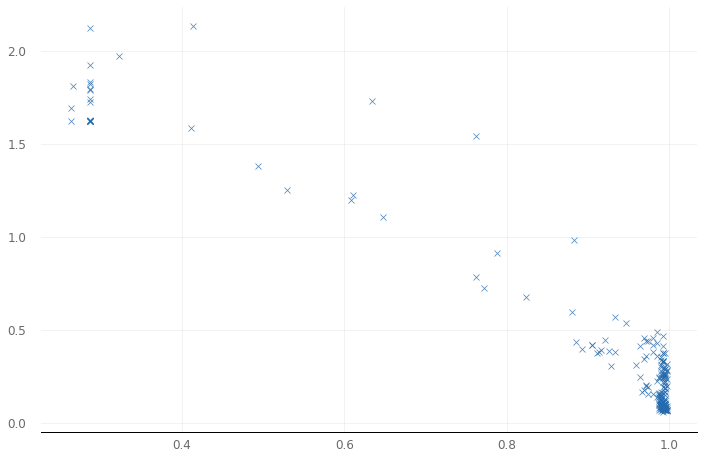

In [ ]:
# a regression plot for two dimensions
analyze_object.plot_regs('val_accuracy', 'val_loss')

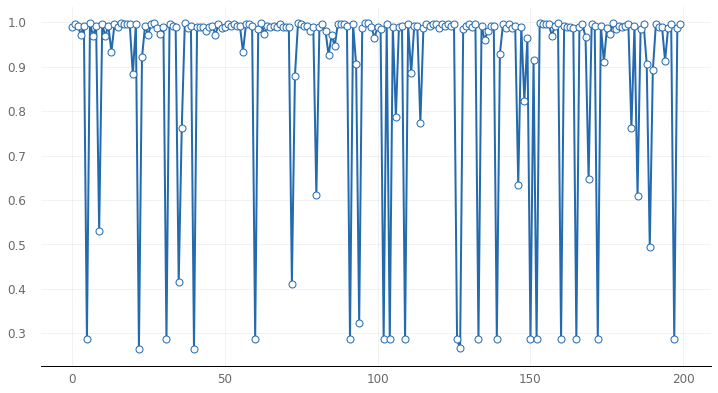

In [ ]:
# line plot
analyze_object.plot_line('val_accuracy')

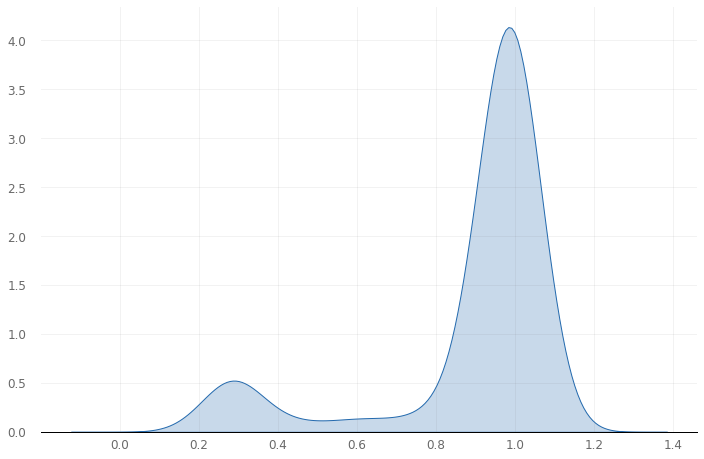

In [ ]:
# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_accuracy')

In [ ]:
# #####################################################
# # Setting the weights for the best model found and saving the model
# scan_object[1].load_weights(checkpoint_filepath)
# # Guardar el Modelo (Just only once if u are running the network again)
# scan_object[1].save('/content/drive/MyDrive/Model_Hyper_CNN.h5')
# /content/drive/MyDrive/CNN_Hyper/080522224246/68/saved_model.pb
######################################################################
# Loading model (already trained)
model2_ = keras.models.load_model('/content/drive/MyDrive/hyper_CNN.hdf5')
#####################################################################

In [ ]:
_, acc = model2_.evaluate(X_test,
                        y_test,
                        batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

_, acc = model2_.evaluate(X_train,
                        y_train,
                        batch_size=32)
print("\Train accuracy: %.1f%%" % (100.0 * acc))

13/13 [==============================] - 1s 11ms/step - loss: 0.1062 - accuracy: 1.0000

Test accuracy: 100.0%
49/49 [==============================] - 1s 11ms/step - loss: 0.1068 - accuracy: 0.9942
\Train accuracy: 99.4%


[Text(0, 0.5, 'Normal'),
 Text(0, 1.5, 'Hor Mis'),
 Text(0, 2.5, 'Imbalance'),
 Text(0, 3.5, 'Ver Mis'),
 Text(0, 4.5, 'Overhang'),
 Text(0, 5.5, 'Underhang')]

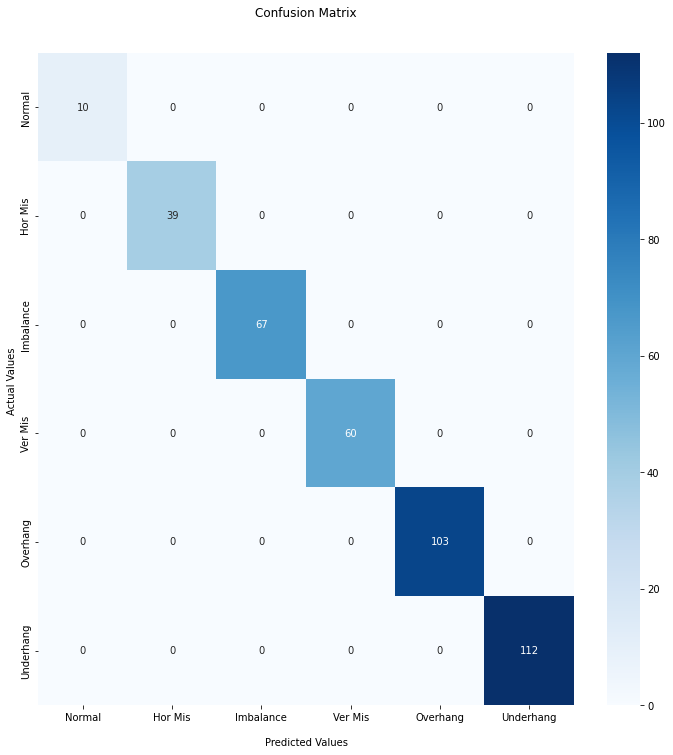

In [ ]:
# COnfusion matrix resulting

y_pred = model2_.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
underhang_y_test_cm = np.argmax(y_test, axis = -1)
matrix = confusion_matrix(underhang_y_test_cm, y_pred)

figure = plt.figure(figsize = (12,12))

ax = sns.heatmap(matrix, annot=True, cmap='Blues',fmt = 'g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])
ax.yaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])

[Text(0, 0.5, 'Normal'),
 Text(0, 1.5, 'Hor Mis'),
 Text(0, 2.5, 'Imbalance'),
 Text(0, 3.5, 'Ver Mis'),
 Text(0, 4.5, 'Overhang'),
 Text(0, 5.5, 'Underhang')]

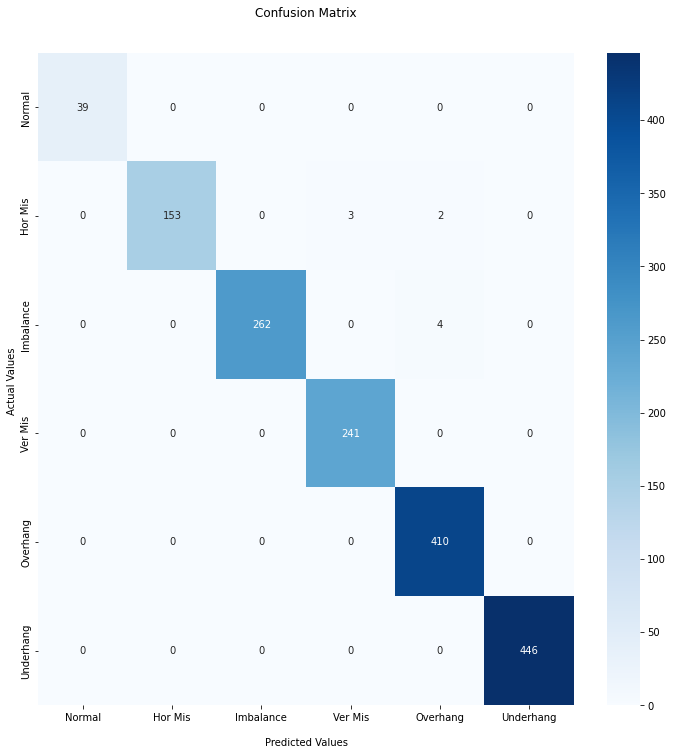

In [ ]:
# COnfusion matrix resulting

y_pred = model2_.predict(X_train)
y_pred = np.argmax(y_pred, axis=-1)
underhang_y_test_cm = np.argmax(y_train, axis = -1)
matrix = confusion_matrix(underhang_y_test_cm, y_pred)

figure = plt.figure(figsize = (12,12))

ax = sns.heatmap(matrix, annot=True, cmap='Blues',fmt = 'g')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])
ax.yaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])

In [ ]:
# Accuracy per class
names = ['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang']

for i in range(6):
  ac =0
  tot = 0
  for j in range(6):
    if i == j:
      ac += matrix[i][j]
      tot += matrix[i][j]
    else:
      tot += matrix[i][j]

  print("The accuracy for class", names[i], 'is:', round(100*ac/tot, 2), '% = ', ac, '/', tot)

The accuracy for class Normal is: 100.0 % =  39 / 39
The accuracy for class Hor Mis is: 96.84 % =  153 / 158
The accuracy for class Imbalance is: 98.5 % =  262 / 266
The accuracy for class Ver Mis is: 100.0 % =  241 / 241
The accuracy for class Overhang is: 100.0 % =  410 / 410
The accuracy for class Underhang is: 100.0 % =  446 / 446


### Explainability using Grad - CAM techniques

In [ ]:
# Needed for visualization

layer_name = "conv1d_4"  # last layer
cnt = 0
xticks = [int(xf[i]) for i in range(0, input_size, 749)]
ticks = [i for i in range(0, input_size, 749)]

In [ ]:
###########################################################################
# Independent heatmaps for each data point
###########################################################################

cnt_2 = 0

for i in X_test:
    data = np.expand_dims(i,0)
    pred = model2_.predict(data)
    # Printing a class in particular
    actual_class = np.argmax(y_test[cnt_2])


    if np.argmax(pred) != actual_class:

      heatmap = grad_cam(layer_name,data)

      fig1, (ax1) = plt.subplots(1, sharex = True, figsize = (30,10))

      ###########################################################################
      # AX1 - CNN selection with stacked data
      ###########################################################################

      ax1.imshow(heatmap, cmap='Reds', aspect="auto" ,extent=[0,5000,i.min(),i.max()], alpha=0.8)
      ax1.plot(i,'k')
      ax1.set_ylabel('Normalised Amplitud frequency')
      ax1.set_title('HeatMap for Incorrect data point')

      # Plotting 7 plots:
      # - Stacking on all 6 frequencies
      # - Axial/Radial/Tangencial Underhang Accelerometer
      # - Axial/Radial/Tangencial Overhang Accelerometer

      ###########################################################################
      # AX2 - Stacked data with colors
      ###########################################################################


      # df = pd.DataFrame(i)

      # ax2.plot(df.iloc[:,0], label = 'AxialUn')
      # ax2.plot(df.iloc[:,1], label = 'RadialUn')
      # ax2.plot(df.iloc[:,2], label = 'TangUn')
      # ax2.plot(df.iloc[:,3], label = 'AxialOv')
      # ax2.plot(df.iloc[:,4], label = 'RadialOv')
      # ax2.plot(df.iloc[:,5], label = 'TangOv')
      # ax2.set_title('Stacked data with colors')
      # ax2.set_xlabel('Frequency (Hz)')
      # ax2.set_xticks(ticks = ticks)
      # ax2.set_xticklabels(xticks)
      # ax2.set_ylabel('Normalised Amplitud frequency')
      # ax2.legend()


      fig1.savefig(directories[6] + '/' + str(cnt)+'_PlotStacked.png')
      plt.close()

      # Saving photos
      ###########################################<################
      # if names[np.argmax(pred)] != names[np.argmax(y_test[cnt])]:
      #   fig1.savefig(directories[6] + '/' + str(cnt)+'_PlotStacked.png')
      #   plt.close()
      # else:
      #   image_allocation(np.argmax(pred), fig1)
      ##############################################################


      ###########################################################################
      # AX1 - 6 remaining graphs regarding accelerometer
      ###########################################################################

      # fig2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex = True, figsize = (30,30))

      # ax1.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax1.plot(df.iloc[:,0], 'k', label = 'AxialUn')
      # ax1.set_title('Axial - Underhang Accelerometer')
      # ax1.set_ylabel('Normalised Amplitud frequency')

      # ax2.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax2.plot(df.iloc[:,1], 'k', label = 'RadialUn')
      # ax2.set_title('Radiale - Underhang Accelerometer')
      # ax2.set_ylabel('Normalised Amplitud frequency')

      # ax3.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax3.plot(df.iloc[:,2], 'k', label = 'TangUn')
      # ax3.set_title('Tangencial - Underhang Accelerometer')
      # ax3.set_ylabel('Normalised Amplitud frequency')

      # ax4.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax4.plot(df.iloc[:,3], 'k', label = 'AxialOv')
      # ax4.set_title('Axial - Overhang Accelerometer')
      # ax4.set_ylabel('Normalised Amplitud frequency')

      # ax5.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax5.plot(df.iloc[:,4], 'k', label = 'RadialOv')
      # ax5.set_title('Radiale - Underhang Accelerometer')
      # ax5.set_ylabel('Normalised Amplitud frequency')

      # ax6.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax6.plot(df.iloc[:,5], 'k', label = 'TangOv')
      # ax6.set_title('Tangecial - Underhang Accelerometer')
      # ax6.set_xlabel('Frequency (Hz)')
      # ax6.set_xlim([0,7509])
      # ax6.set_ylabel('Normalised Amplitud frequency')
      # ax6.set_xticks(ticks = ticks)
      # ax6.set_xticklabels(xticks)

      # # Saving photos
      # ###########################################<################
      # if names[np.argmax(pred)] != names[np.argmax(y_test[cnt])]:
      #   fig2.savefig(directories[6]+ '/' +str(cnt)+'_Plot6Accelerometer.png')
      #   plt.close()
      # else:
      #   image_allocation(np.argmax(pred), fig2, stacked = False)
      # ##############################################################

    cnt_2 += 1



334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


390


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


In [ ]:
%%capture
################################################################
# Training + Test
################################################################

X = np.moveaxis(new_signal2, 0, -1)
y = to_categorical(underhang_y)
average_spectrum(X, y, 'Tran_Test_Hyper', model2_ = model2_)
average_heatmap(X, y, 'Train_Test_Hyper', model2_ = model2_)

In [ ]:
%%capture

################################################################
# Training
################################################################

average_heatmap(X_train, y_train, 'Train_Hyper', model2_ = model2_)
average_spectrum(X_train, y_train, 'Train_Hyper', model2_ = model2_)

################################################################
# Test
################################################################

average_heatmap(X_test, y_test, 'Test_Hyper', model2_ = model2_)
average_spectrum(X_test, y_test, 'Test_Hyper', model2_ = model2_)

## Sparse CNN

In [ ]:
def create_sparsity_masks(model,sparsity):
    weights_list = model.get_weights()
    masks = []
    for weights in weights_list:
        #We can ignore biases
        if len(weights.shape) > 1:
            weights_abs = np.abs(weights)
            masks.append((weights_abs>np.percentile(weights_abs,sparsity))*1.)
    return masks

In [ ]:
masks = create_sparsity_masks(model2_,1) #Closest 70% to 0

In [ ]:
num_errors = 6
input_shape = (input_size ,6)
kernel_size = 9
pool_size = 2

sparse_model =  Sequential([
                    Conv1D(filters=16,
                                    kernel_size=13,
                                    activation='relu',
                                    input_shape=input_shape,
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    BatchNormalization(),

                    Dropout(0.1),


                    Conv1D(filters=32,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    BatchNormalization(),

                    Conv1D(filters=128,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    # dropout added as regularizer
                    Dropout(0.1),

                    Conv1D(filters=32,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    Conv1D(filters=16,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),


                    Flatten(),

                    Dense(num_errors),
                    Activation('softmax')

  ])
sparse_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_63 (Conv1D)          (None, 5000, 16)          1264      
                                                                 
 batch_normalization_35 (Bat  (None, 5000, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 5000, 16)          0         
                                                                 
 conv1d_64 (Conv1D)          (None, 5000, 32)          6688      
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 2500, 32)         0         
 g1D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 2500, 32)        

In [ ]:
########################################
# Training the model now (Underhang)
########################################
import tensorflow as tf

checkpoint_filepath = '/content/drive/MyDrive/sparse_model.hdf5'
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)

opt = tf.keras.optimizers.Adam(
    learning_rate= 0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

sparse_model.compile(loss='CategoricalCrossentropy',
              optimizer= opt,
              metrics=['accuracy'])

sparse_model.set_weights(model2_.get_weights())

# train the network
output = sparse_model.fit(X_train, y_train, epochs = 100, batch_size=8,
                    validation_data = (X_test , y_test),
                    callbacks = [save_best_model])

Epoch 1/100
195/195 [==============================] - ETA: 0s - loss: 3.7808 - accuracy: 0.5128
Epoch 1: val_accuracy improved from -inf to 0.29923, saving model to /content/drive/MyDrive/sparse_model.hdf5
195/195 [==============================] - 6s 20ms/step - loss: 3.7808 - accuracy: 0.5128 - val_loss: 11.8519 - val_accuracy: 0.2992
Epoch 2/100
193/195 [============================>.] - ETA: 0s - loss: 0.9011 - accuracy: 0.7591
Epoch 2: val_accuracy improved from 0.29923 to 0.59847, saving model to /content/drive/MyDrive/sparse_model.hdf5
195/195 [==============================] - 3s 15ms/step - loss: 0.8974 - accuracy: 0.7596 - val_loss: 1.3569 - val_accuracy: 0.5985
Epoch 3/100
194/195 [============================>.] - ETA: 0s - loss: 0.7852 - accuracy: 0.7938
Epoch 3: val_accuracy improved from 0.59847 to 0.83120, saving model to /content/drive/MyDrive/sparse_model.hdf5
195/195 [==============================] - 3s 15ms/step - loss: 0.7836 - accuracy: 0.7942 - val_loss: 1.0478

KeyboardInterrupt: ignored

In [ ]:
######################################################
# Setting the weights for the best model found and saving the model
sparse_model.load_weights(checkpoint_filepath)
# Guardar el Modelo (Just only once if u are running the network again)
sparse_model.save('/content/drive/MyDrive/Sparse_CNN.h5')

######################################################################
# Loading model (already trained)
sparse_model = keras.models.load_model('/content/drive/MyDrive/Sparse_CNN.h5')
#####################################################################

In [ ]:
# Minimum value of cross entropy

print("The minimum loss training found is:", round(min(output.history['loss']),6) ," and was found in epoch number:", np.argmin(output.history['loss']))
print("The minimum loss test found is:", round(min(output.history['val_loss']),6) ," and was found in epoch number:", np.argmin(output.history['val_loss']))

# Maximum accuracy

print("The maximum accuracy training found is:", round(100*max(output.history['accuracy']),2) ,"% and was found in epoch number:", np.argmax(output.history['accuracy']))
print("The maximum accuracy test found is:", round(100*max(output.history['val_accuracy']),2) ,"% and was found in epoch number:", np.argmax(output.history['val_accuracy']))

In [ ]:
# Plotting loss and val_loss vs epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
fig.suptitle('History Epochs - Loss')

ax1.plot(range(100),output.history['loss'],output.history['val_loss'])
ax1.set(ylabel= "Loss", xlabel = "epochs")
ax1.legend(["Training", "Validation"],loc = "best")
ax1.set_ylim([0, 0.5])

ax2.plot(range(100),output.history['loss'],output.history['val_loss'])
ax2.set(ylabel= "Loss", xlabel = "epochs")
ax2.legend(["Training", "Validation"],loc = "best")
ax2.set_xlim([20,100])
ax2.set_ylim([0, 0.4])

In [ ]:
# Plotting accuracy and val_accuracy vs epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
fig.suptitle('History Epochs - Accuracy')

ax1.plot(range(100),output.history['accuracy'],output.history['val_accuracy'])
ax1.set(ylabel= "Loss", xlabel = "epochs")
ax1.legend(["Training", "Validation"],loc = "best")
ax1.set_ylim([0.7, 1.05])

ax2.plot(range(100),output.history['accuracy'],output.history['val_accuracy'])
ax2.set(ylabel= "Loss", xlabel = "epochs")
ax2.legend(["Training", "Validation"],loc = "best")
ax2.set_xlim([20,100])
ax2.set_ylim([0.94, 1.02])

In [ ]:
_, acc = sparse_model.evaluate(X_test,
                        y_test,
                        batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

_, acc = sparse_model.evaluate(X_train,
                        y_train,
                        batch_size=32)
print("\Train accuracy: %.1f%%" % (100.0 * acc))

In [ ]:
# COnfusion matrix resulting

y_pred = sparse_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
underhang_y_test_cm = np.argmax(y_test, axis = -1)
matrix = confusion_matrix(underhang_y_test_cm, y_pred)

figure = plt.figure(figsize = (12,12))

ax = sns.heatmap(matrix, annot=True, cmap='Blues',fmt = 'g')

ax.set_title('Underhang Test - Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])
ax.yaxis.set_ticklabels(['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang'])

In [ ]:
# Accuracy per class
names = ['Normal','Hor Mis','Imbalance', 'Ver Mis', 'Overhang', 'Underhang']

for i in range(6):
  ac =0
  tot = 0
  for j in range(6):
    if i == j:
      ac += matrix[i][j]
      tot += matrix[i][j]
    else:
      tot += matrix[i][j]

  print("The accuracy for class", names[i], 'is:', round(100*ac/tot, 2), '% = ', ac, '/', tot)

### Explainability using Grad - CAM techniques

In [ ]:
# Needed for visualization

layer_name = "conv1d_24"  # last layer
cnt = 0
xticks = [int(xf[i]) for i in range(0, input_size, 749)]
ticks = [i for i in range(0, input_size, 749)]

In [ ]:
###########################################################################
# Independent heatmaps for each data point
###########################################################################

cnt_2 = 0

for i in X_test:
    data = np.expand_dims(i,0)
    pred = sparse_model.predict(data)
    # Printing a class in particular
    actual_class = np.argmax(y_test[cnt_2])


    if np.argmax(pred) != actual_class:

      heatmap = grad_cam(layer_name,data)

      fig1, (ax1) = plt.subplots(1, sharex = True, figsize = (30,10))

      ###########################################################################
      # AX1 - CNN selection with stacked data
      ###########################################################################

      ax1.imshow(heatmap, cmap='Reds', aspect="auto" ,extent=[0,5000,i.min(),i.max()], alpha=0.8)
      ax1.plot(i,'k')
      ax1.set_ylabel('Normalised Amplitud frequency')
      ax1.set_title('HeatMap for Incorrect data point')

      # Plotting 7 plots:
      # - Stacking on all 6 frequencies
      # - Axial/Radial/Tangencial Underhang Accelerometer
      # - Axial/Radial/Tangencial Overhang Accelerometer

      ###########################################################################
      # AX2 - Stacked data with colors
      ###########################################################################


      # df = pd.DataFrame(i)

      # ax2.plot(df.iloc[:,0], label = 'AxialUn')
      # ax2.plot(df.iloc[:,1], label = 'RadialUn')
      # ax2.plot(df.iloc[:,2], label = 'TangUn')
      # ax2.plot(df.iloc[:,3], label = 'AxialOv')
      # ax2.plot(df.iloc[:,4], label = 'RadialOv')
      # ax2.plot(df.iloc[:,5], label = 'TangOv')
      # ax2.set_title('Stacked data with colors')
      # ax2.set_xlabel('Frequency (Hz)')
      # ax2.set_xticks(ticks = ticks)
      # ax2.set_xticklabels(xticks)
      # ax2.set_ylabel('Normalised Amplitud frequency')
      # ax2.legend()


      fig1.savefig(directories[6] + '/' + str(cnt)+'_PlotStacked.png')
      plt.close()

      # Saving photos
      ###########################################<################
      # if names[np.argmax(pred)] != names[np.argmax(y_test[cnt])]:
      #   fig1.savefig(directories[6] + '/' + str(cnt)+'_PlotStacked.png')
      #   plt.close()
      # else:
      #   image_allocation(np.argmax(pred), fig1)
      ##############################################################


      ###########################################################################
      # AX1 - 6 remaining graphs regarding accelerometer
      ###########################################################################

      # fig2, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, sharex = True, figsize = (30,30))

      # ax1.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax1.plot(df.iloc[:,0], 'k', label = 'AxialUn')
      # ax1.set_title('Axial - Underhang Accelerometer')
      # ax1.set_ylabel('Normalised Amplitud frequency')

      # ax2.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax2.plot(df.iloc[:,1], 'k', label = 'RadialUn')
      # ax2.set_title('Radiale - Underhang Accelerometer')
      # ax2.set_ylabel('Normalised Amplitud frequency')

      # ax3.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax3.plot(df.iloc[:,2], 'k', label = 'TangUn')
      # ax3.set_title('Tangencial - Underhang Accelerometer')
      # ax3.set_ylabel('Normalised Amplitud frequency')

      # ax4.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax4.plot(df.iloc[:,3], 'k', label = 'AxialOv')
      # ax4.set_title('Axial - Overhang Accelerometer')
      # ax4.set_ylabel('Normalised Amplitud frequency')

      # ax5.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax5.plot(df.iloc[:,4], 'k', label = 'RadialOv')
      # ax5.set_title('Radiale - Underhang Accelerometer')
      # ax5.set_ylabel('Normalised Amplitud frequency')

      # ax6.imshow(heatmap,cmap='Greens', aspect="auto", interpolation='nearest',extent=[0,7509,i.min(),i.max()], alpha=0.8)
      # ax6.plot(df.iloc[:,5], 'k', label = 'TangOv')
      # ax6.set_title('Tangecial - Underhang Accelerometer')
      # ax6.set_xlabel('Frequency (Hz)')
      # ax6.set_xlim([0,7509])
      # ax6.set_ylabel('Normalised Amplitud frequency')
      # ax6.set_xticks(ticks = ticks)
      # ax6.set_xticklabels(xticks)

      # # Saving photos
      # ###########################################<################
      # if names[np.argmax(pred)] != names[np.argmax(y_test[cnt])]:
      #   fig2.savefig(directories[6]+ '/' +str(cnt)+'_Plot6Accelerometer.png')
      #   plt.close()
      # else:
      #   image_allocation(np.argmax(pred), fig2, stacked = False)
      # ##############################################################

    cnt_2 += 1



334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


390


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


In [ ]:
%%capture
################################################################
# Training + Test
################################################################

X = np.moveaxis(new_signal2, 0, -1)
y = to_categorical(underhang_y)
average_spectrum(X, y, 'Tran_Test_Sparse', model2_ = sparse_model)
average_heatmap(X, y, 'Train_Test_Sparse', model2_ = sparse_model)

In [ ]:
%%capture

################################################################
# Training
################################################################

average_heatmap(X_train, y_train, 'Train_Sparse', model2_ = sparse_model)
average_spectrum(X_train, y_train, 'Train_sparse', model2_ = sparse_model)

################################################################
# Test
################################################################

average_heatmap(X_test, y_test, 'Test_Sparse', model2_ = sparse_model)
average_spectrum(X_test, y_test, 'Test_Sparse', model2_ = sparse_model)

## Normal and Underhang

In [ ]:
##############################
# Creating labels
##############################

underhang_y = []

# Normal
for i in range(49):
  underhang_y.append(0)

# Underhang

# Cage Fault
for i in range(188):
  underhang_y.append(1)

# Outer Race
for i in range(184):
  underhang_y.append(2)

# Ball Fault
for i in range(186):
  underhang_y.append(3)

underhang_y = np.array(underhang_y)

In [ ]:
##########################################################
# Splitting and shuffling the data
##########################################################

new_signal2 = new_signal.reshape(6, 1951, input_size)
new_sig_bin = np.concatenate((new_signal2[:,0:49,:] , new_signal2[:,1393:1951, :]), axis = 1)

# Splitting it 65% - 35% (train-test)
all_indices = list(range(607))
# , stratify = underhang_y
train_ind, test_ind = train_test_split(all_indices,stratify = underhang_y, test_size=0.2, shuffle = True,
                                       random_state = 420)

X_train = np.moveaxis(new_sig_bin[:,train_ind,:], 0, -1)
X_test = np.moveaxis(new_sig_bin[:,test_ind, :], 0, -1)
# One-hot encoding
y_train = to_categorical(underhang_y[train_ind])
y_test = to_categorical(underhang_y[test_ind])

print("""
########################################
# Underhang Accelerometer
########################################
""")
print('Underhang - Training size:', X_train.shape)
print('Underhang - Test size:', X_test.shape)
print('Underhang_y - Training size:', y_train.shape)
print('Underhang_y - Test size:', y_test.shape)



########################################
# Underhang Accelerometer
########################################

Underhang - Training size: (485, 5000, 6)
Underhang - Test size: (122, 5000, 6)
Underhang_y - Training size: (485, 4)
Underhang_y - Test size: (122, 4)


In [ ]:
# Obtaining the same model as described in the paper

num_errors = 4
input_shape = (input_size ,6)
kernel_size = 9
pool_size = 2
dropout = 0.1

model2_ =  Sequential([
                    Conv1D(filters=16,
                                    kernel_size=13,
                                    activation='relu',
                                    input_shape=input_shape,
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    BatchNormalization(),

                    Dropout(dropout),

                    Conv1D(filters=32,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    BatchNormalization(),

                    Conv1D(filters=128,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    # dropout added as regularizer
                    Dropout(dropout),

                    Conv1D(filters=32,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),

                    Conv1D(filters=16,
                                    kernel_size=13,
                                    activation='relu',
                                    padding = 'same',
                                    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                                    bias_regularizer=regularizers.L2(1e-4),
                                    activity_regularizer=regularizers.L2(1e-5)),

                    MaxPooling1D(pool_size),


                    Flatten(),

                    Dense(num_errors),
                    Activation('softmax')

  ])
model2_.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (None, 5000, 16)          1264      
                                                                 
 batch_normalization_12 (Bat  (None, 5000, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 5000, 16)          0         
                                                                 
 conv1d_31 (Conv1D)          (None, 5000, 32)          6688      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 2500, 32)         0         
 g1D)                                                            
                                                                 
 batch_normalization_13 (Bat  (None, 2500, 32)        

In [ ]:
########################################
# Training the model now (Underhang)
########################################
import tensorflow as tf

checkpoint_filepath = '/content/drive/MyDrive/best_model.hdf5'
save_best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None
)

opt = tf.keras.optimizers.Adam(
    learning_rate= 0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
  )

model2_.compile(loss='CategoricalCrossentropy',
              optimizer= opt,
              metrics=['accuracy'])

# train the network
output = model2_.fit(X_train, y_train, epochs = 100, batch_size=8,
                    validation_data = (X_test , y_test),
                    callbacks = [save_best_model])

Epoch 1/100
58/61 [===========================>..] - ETA: 0s - loss: 0.9157 - accuracy: 0.9138
Epoch 1: val_accuracy improved from -inf to 0.31148, saving model to /content/drive/MyDrive/best_model.hdf5
61/61 [==============================] - 3s 26ms/step - loss: 0.9192 - accuracy: 0.9113 - val_loss: 1.3362 - val_accuracy: 0.3115
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.9505
Epoch 2: val_accuracy improved from 0.31148 to 0.51639, saving model to /content/drive/MyDrive/best_model.hdf5
61/61 [==============================] - 1s 17ms/step - loss: 0.6888 - accuracy: 0.9505 - val_loss: 1.3056 - val_accuracy: 0.5164
Epoch 3/100
59/61 [============================>.] - ETA: 0s - loss: 0.5323 - accuracy: 0.9873
Epoch 3: val_accuracy improved from 0.51639 to 0.53279, saving model to /content/drive/MyDrive/best_model.hdf5
61/61 [==============================] - 1s 19ms/step - loss: 0.5310 - accuracy: 0.9876 - val_loss: 1.3256 - val_accuracy: 0.

In [ ]:
# ######################################################
# # Setting the weights for the best model found and saving the model
# model2_.load_weights(checkpoint_filepath)
# # Guardar el Modelo (Just only once if u are running the network again)
# model2_.save('/content/drive/MyDrive/Model_CNN_Binary.h5')

######################################################################
# Loading model (already trained)
model2_ = keras.models.load_model('/content/drive/MyDrive/Model_CNN_Binary.h5')
#####################################################################

In [ ]:
# Minimum value of cross entropy

print("The minimum loss training found is:", round(min(output.history['loss']),6) ," and was found in epoch number:", np.argmin(output.history['loss']))
print("The minimum loss test found is:", round(min(output.history['val_loss']),6) ," and was found in epoch number:", np.argmin(output.history['val_loss']))

# Maximum accuracy

print("The maximum accuracy training found is:", round(100*max(output.history['accuracy']),2) ,"% and was found in epoch number:", np.argmax(output.history['accuracy']))
print("The maximum accuracy test found is:", round(100*max(output.history['val_accuracy']),2) ,"% and was found in epoch number:", np.argmax(output.history['val_accuracy']))

The minimum loss training found is: 0.051027  and was found in epoch number: 99
The minimum loss test found is: 0.050591  and was found in epoch number: 99
The maximum accuracy training found is: 100.0 % and was found in epoch number: 11
The maximum accuracy test found is: 100.0 % and was found in epoch number: 9


(0.0, 0.4)

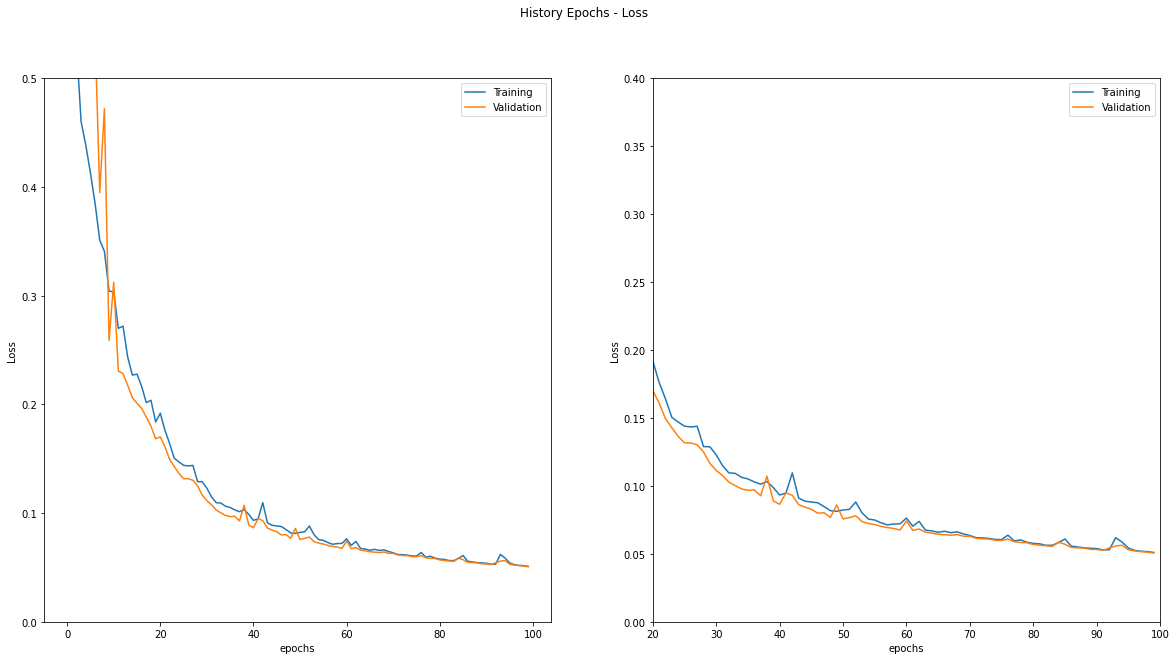

In [ ]:
# Plotting loss and val_loss vs epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
fig.suptitle('History Epochs - Loss')

ax1.plot(range(100),output.history['loss'],output.history['val_loss'])
ax1.set(ylabel= "Loss", xlabel = "epochs")
ax1.legend(["Training", "Validation"],loc = "best")
ax1.set_ylim([0, 0.5])

ax2.plot(range(100),output.history['loss'],output.history['val_loss'])
ax2.set(ylabel= "Loss", xlabel = "epochs")
ax2.legend(["Training", "Validation"],loc = "best")
ax2.set_xlim([20,100])
ax2.set_ylim([0, 0.4])

(0.94, 1.02)

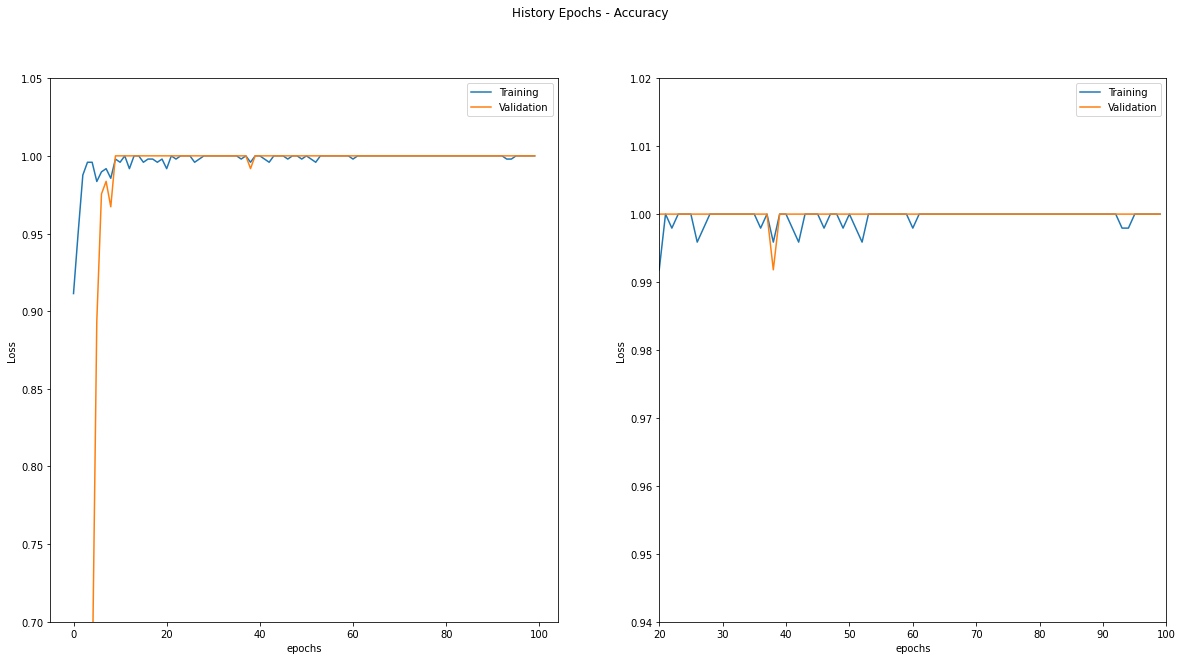

In [ ]:
# Plotting accuracy and val_accuracy vs epochs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
fig.suptitle('History Epochs - Accuracy')

ax1.plot(range(100),output.history['accuracy'],output.history['val_accuracy'])
ax1.set(ylabel= "Loss", xlabel = "epochs")
ax1.legend(["Training", "Validation"],loc = "best")
ax1.set_ylim([0.7, 1.05])

ax2.plot(range(100),output.history['accuracy'],output.history['val_accuracy'])
ax2.set(ylabel= "Loss", xlabel = "epochs")
ax2.legend(["Training", "Validation"],loc = "best")
ax2.set_xlim([20,100])
ax2.set_ylim([0.94, 1.02])

In [ ]:
_, acc = model2_.evaluate(X_test,
                        y_test,
                        batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

_, acc = model2_.evaluate(X_train,
                        y_train,
                        batch_size=32)
print("\Train accuracy: %.1f%%" % (100.0 * acc))

4/4 [==============================] - 1s 71ms/step - loss: 0.2588 - accuracy: 1.0000

Test accuracy: 100.0%
16/16 [==============================] - 0s 12ms/step - loss: 0.2624 - accuracy: 1.0000
\Train accuracy: 100.0%


[Text(0, 0.5, 'Normal'),
 Text(0, 1.5, 'Cage Fault'),
 Text(0, 2.5, 'Outer Race'),
 Text(0, 3.5, 'Ball Fault')]

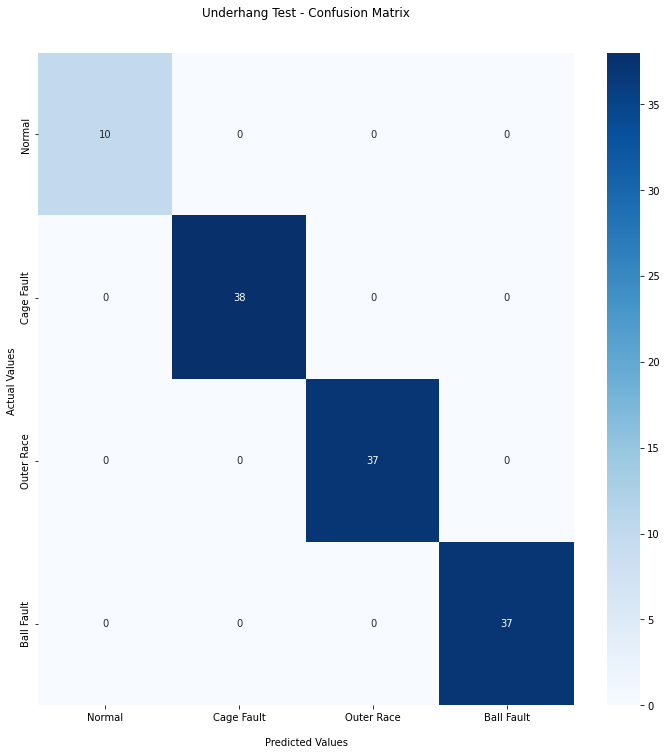

In [ ]:
# COnfusion matrix resulting

y_pred = model2_.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
underhang_y_test_cm = np.argmax(y_test, axis = -1)
matrix = confusion_matrix(underhang_y_test_cm, y_pred)

figure = plt.figure(figsize = (12,12))

ax = sns.heatmap(matrix, annot=True, cmap='Blues',fmt = 'g')

ax.set_title('Underhang Test - Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Cage Fault','Outer Race', 'Ball Fault'])
ax.yaxis.set_ticklabels(['Normal','Cage Fault','Outer Race', 'Ball Fault'])

In [ ]:
# Accuracy per class
names = ['Normal','Cage Fault','Outer Race', 'Ball Fault']

for i in range(4):
  ac =0
  tot = 0
  for j in range(4):
    if i == j:
      ac += matrix[i][j]
      tot += matrix[i][j]
    else:
      tot += matrix[i][j]

  print("The accuracy for class", names[i], 'is:', round(100*ac/tot, 2), '% = ', ac, '/', tot)

The accuracy for class Normal is: 100.0 % =  10 / 10
The accuracy for class Cage Fault is: 100.0 % =  38 / 38
The accuracy for class Outer Race is: 100.0 % =  37 / 37
The accuracy for class Ball Fault is: 100.0 % =  37 / 37


### Explainability using Grad - CAM techniques

In [ ]:
# Needed for visualization

layer_name = "conv1d_29"
cnt = 0
xticks = [int(xf[i]) for i in range(0, input_size, 749)]
ticks = [i for i in range(0, input_size, 749)]

In [ ]:
%%capture
################################################################
# Training + Test
################################################################

X = np.moveaxis(new_sig_bin, 0, -1)
y = to_categorical(underhang_y)
average_spectrum(X, y, 'Tran_Test_Binary',model2_ = model2_,  Binary = False)
average_heatmap(X, y, 'Train_Test_Binary',model2_ = model2_,  Binary = False)

In [ ]:
%%capture

################################################################
# Training
################################################################

average_heatmap(X_train, y_train, 'Train_Binary',model2_ = model2_,  Binary = False)
average_spectrum(X_train, y_train, 'Train_Binary',model2_ = model2_,  Binary = False)

################################################################
# Test
################################################################

average_heatmap(X_test, y_test, 'Test_Binary',model2_ = model2_,  Binary = False)
average_spectrum(X_test, y_test, 'Test_Binary',model2_ = model2_,  Binary = False)